In [2]:
%matplotlib inline

import csv
from IPython.display import display
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, ElasticNet, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier


#### Let's load the train data and its label.

In [3]:
def load_data(data):
    temp_df = pd.read_csv(data, sep=' ', header=None)
    temp_df.drop(500, axis=1,inplace=True)
    return temp_df

In [4]:
train_data = load_data('madelon_train.data')
label = pd.read_csv('madelon_train.labels', header=None, names= ['label'])


#### Let's take a look at basic statistics and information on our train data.

In [120]:
train_data.head()

0    1    2    3    4    5    6    7    8    9   ...   490  491  492  493  \
0  485  477  537  479  452  471  491  476  475  473 ...   477  481  477  485   
1  483  458  460  487  587  475  526  479  485  469 ...   463  478  487  338   
2  487  542  499  468  448  471  442  478  480  477 ...   487  481  492  650   
3  480  491  510  485  495  472  417  474  502  476 ...   491  480  474  572   
4  484  502  528  489  466  481  402  478  487  468 ...   488  479  452  435   

   494  495  496  497  498  499  
0  511  485  481  479  475  496  
1  513  486  483  492  510  517  
2  506  501  480  489  499  498  
3  454  469  475  482  494  461  
4  486  508  481  504  495  511  

[5 rows x 500 columns]

In [121]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 500 entries, 0 to 499
dtypes: int64(500)
memory usage: 7.6 MB


In [124]:
train_stats_df = train_data.describe().T

In [129]:
train_stats_df.sample(n=20, axis=0)

count      mean        std    min    25%    50%    75%    max
203  2000.0  508.1945  42.703132  332.0  481.0  509.0  537.0  647.0
26   2000.0  484.7835  21.573278  421.0  471.0  485.0  499.0  573.0
296  2000.0  475.1750  24.965957  394.0  459.0  475.0  491.0  561.0
198  2000.0  476.5120   1.404223  472.0  476.0  477.0  477.0  481.0
9    2000.0  478.7890   7.190920  455.0  474.0  479.0  484.0  503.0
170  2000.0  494.6405  42.958701  350.0  467.0  495.0  522.0  639.0
485  2000.0  482.7790  11.275936  444.0  475.0  483.0  490.0  523.0
363  2000.0  486.1715  24.397596  410.0  469.0  486.0  502.0  573.0
92   2000.0  479.3155  20.979061  399.0  465.0  479.0  493.0  551.0
73   2000.0  484.1835  36.814080  354.0  460.0  484.0  508.0  629.0
126  2000.0  483.3870  12.921018  440.0  475.0  483.0  492.0  530.0
97   2000.0  478.9505  23.181345  406.0  463.0  479.0  494.0  554.0
316  2000.0  477.3155  10.116478  448.0  471.0  477.0  484.0  510.0
93   2000.0  492.5830  18.754332  438.0  480.0  492.0  505.0  557.0
271  2000.0  498.9620  41.093624  369.0  471.0  499.0  526.0  639.0
21   2000.0  494.2390  22.344295  412.0  479.0  494.0  509.0  571.0
307  2000.0  480.8795   8.985062  450.0  475.0  481.0  487.0  512.0
163  2000.0  479.9680   6.126316  458.0  476.0  480.0  484.0  500.0
192  2000.0  495.4240  19.671291  428.0  483.0  496.0  508.0  559.0
109  2000.0  480.8710  10.096154  442.0  474.0  481.0  487.0  518.0

Luckily, the data does not contain any null value. The data consists of intergers only with classification labels. Therefore, do not need to treat categorical features. 

Let's take 3 sets of 10% sample from our train data. Each scoring and feature selections will be performed separately per samples.

In [5]:
def sample(data, target, seed):
    result = pd.concat([data, target], axis=1)
    temp_sample = result.sample(frac = 1/10, random_state=seed)
    return temp_sample

In [6]:
sample_1_train_df = sample(train_data, label, 1)
sample_2_train_df = sample(train_data, label, 2)
sample_3_train_df = sample(train_data, label, 3)

I will load valid data and its label and utilize them as the test data.

In [7]:
test_data = load_data('madelon_valid.data')
test_y = pd.read_csv('madelon_valid.label', header=None, names= ['label'])

Let's take a look at samples one by one

In [202]:
sample_1_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 674 to 926
Columns: 501 entries, 0 to label
dtypes: int64(501)
memory usage: 784.4 KB


In [7]:
sample_1_train_df.head()

0    1    2    3    4    5    6    7    8    9  ...    491  492  493  \
674   487  470  536  473  506  465  543  477  478  474  ...    475  507  438   
1699  467  446  518  494  491  483  497  478  471  488  ...    483  471  294   
1282  486  496  463  473  488  482  432  474  500  476  ...    482  520  535   
1315  480  444  514  489  536  473  470  477  486  486  ...    482  445  657   
1210  486  549  594  480  439  479  370  475  496  483  ...    469  478  437   

      494  495  496  497  498  499  label  
674   523  442  487  485  489  523     -1  
1699  477  497  474  478  459  454      1  
1282  517  461  479  513  552  478      1  
1315  481  557  478  484  468  490      1  
1210  476  460  477  519  495  483      1  

[5 rows x 501 columns]

In [8]:
sample_2_train_df.head()

0    1    2    3    4    5    6    7    8    9  ...    491  492  493  \
278   481  497  489  489  475  488  573  474  510  486  ...    479  515  614   
492   482  461  517  490  485  476  484  475  493  480  ...    479  498  456   
1266  491  503  500  485  565  479  588  477  468  485  ...    479  487  721   
557   481  498  491  475  489  472  456  476  457  488  ...    481  509  335   
871   494  490  494  483  467  474  461  478  494  477  ...    485  533  495   

      494  495  496  497  498  499  label  
278   524  514  470  465  489  481      1  
492   435  553  489  495  523  492     -1  
1266  480  548  482  479  519  482      1  
557   440  517  478  482  541  524      1  
871   496  510  480  463  446  487      1  

[5 rows x 501 columns]

In [9]:
sample_3_train_df.head()

0    1    2    3    4    5    6    7    8    9  ...    491  492  493  \
933   469  488  558  477  531  477  482  476  493  482  ...    482  484  388   
1459  484  517  562  489  526  477  444  476  517  481  ...    482  458  382   
1338  479  489  434  487  388  481  455  476  495  483  ...    482  492  592   
1802  485  430  435  488  420  493  517  478  461  474  ...    483  464  648   
263   479  444  537  505  614  481  531  478  502  480  ...    478  465  173   

      494  495  496  497  498  499  label  
933   496  457  490  483  540  504     -1  
1459  516  533  479  510  478  510     -1  
1338  467  529  474  483  545  466     -1  
1802  499  476  475  484  510  500      1  
263   465  468  474  473  548  502     -1  

[5 rows x 501 columns]

None of the samples are identical. Let's split the sample to feature and target

In [8]:
sample_1_X = sample_1_train_df.drop('label', axis=1)
sample_1_y = sample_1_train_df['label']

sample_2_X = sample_2_train_df.drop('label', axis=1) 
sample_2_y = sample_2_train_df['label']

sample_3_X = sample_3_train_df.drop('label', axis=1)
sample_3_y = sample_3_train_df['label']

### Let's take a look at distribution of each columns through some EDA
    - Let's take a look at all the feature of sample 1

In [122]:
def plot_histogram_dv(x,y):
    plt.hist(list(x[y==-1]), alpha=0.5, label='Outcome=-1')
    plt.hist(list(x[y==1]), alpha=0.5, label='Outcome=1')
    plt.title("Histogram of '{var_name}' by Outcome Category".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

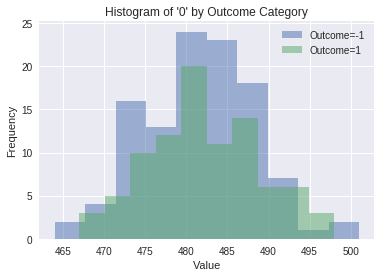

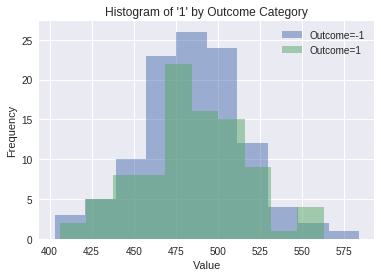

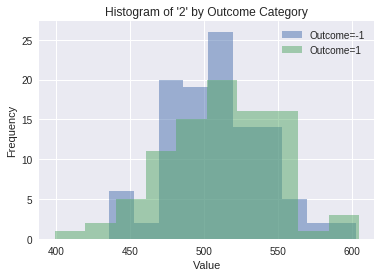

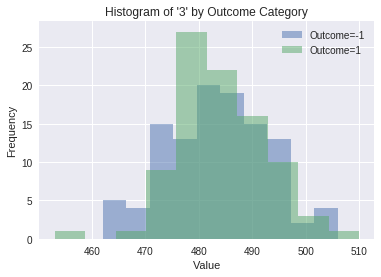

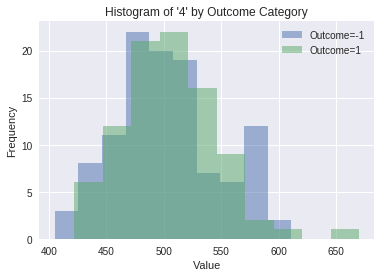

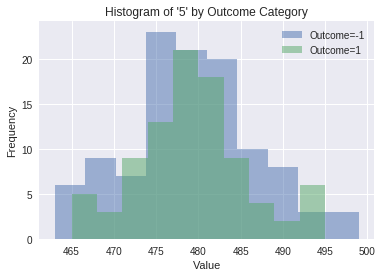

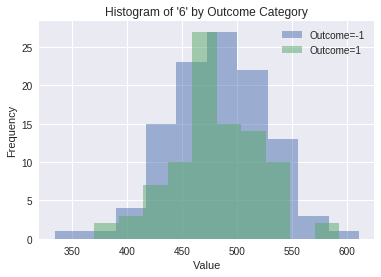

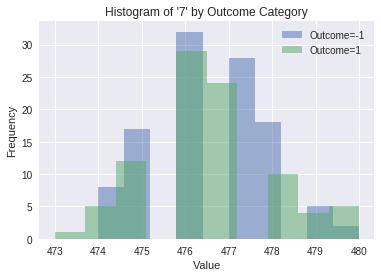

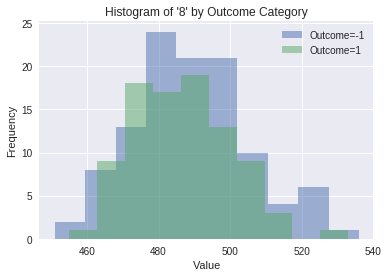

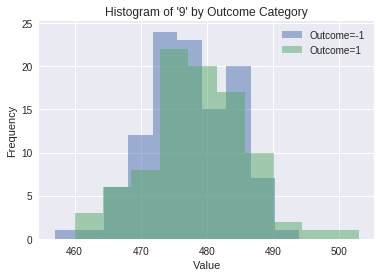

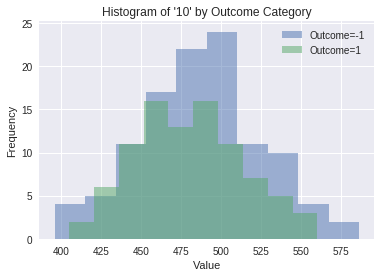

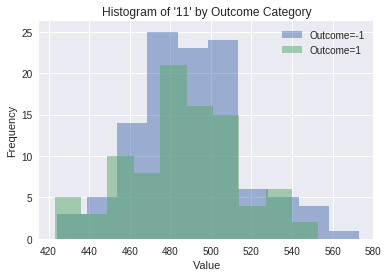

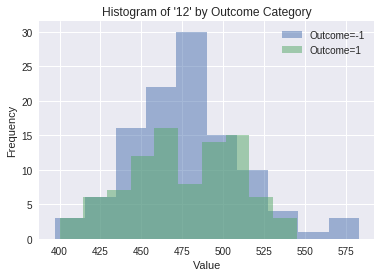

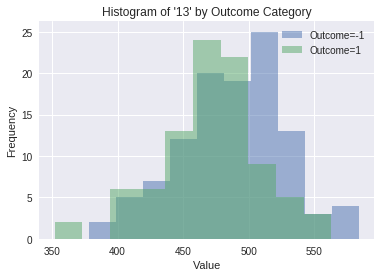

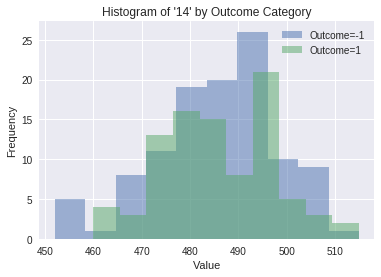

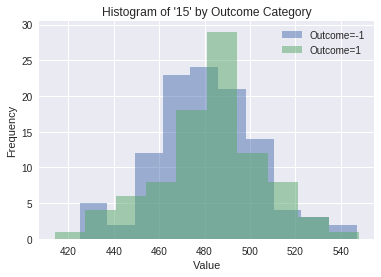

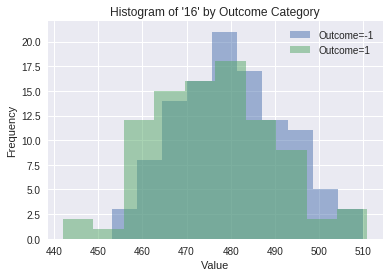

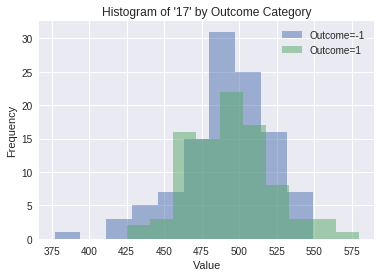

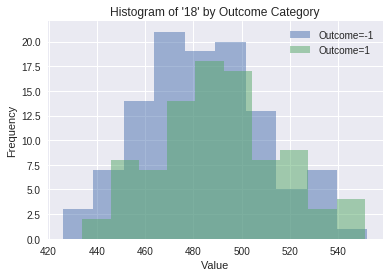

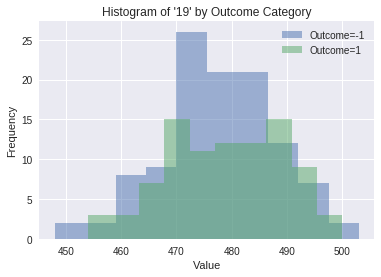

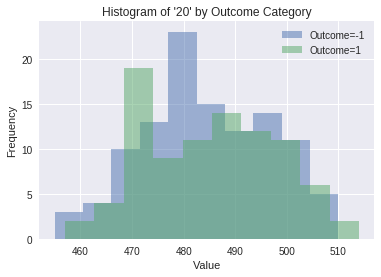

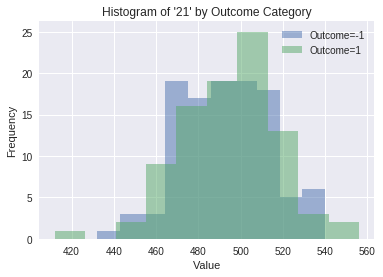

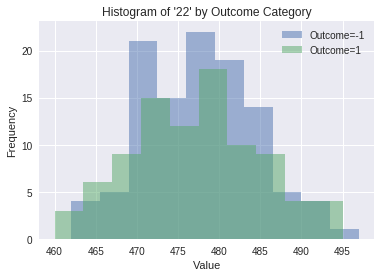

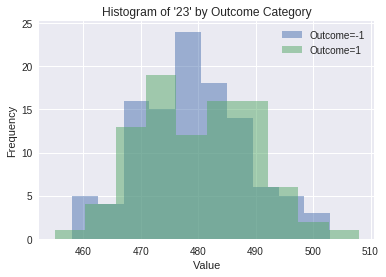

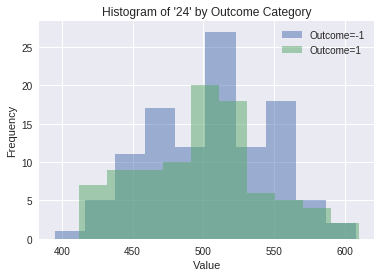

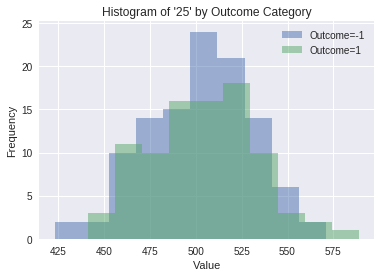

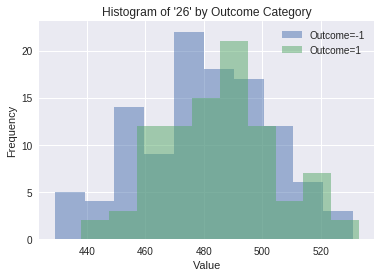

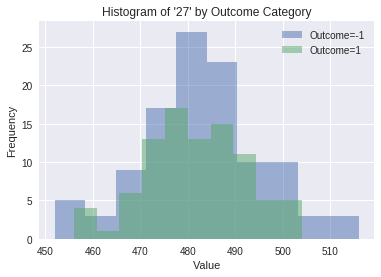

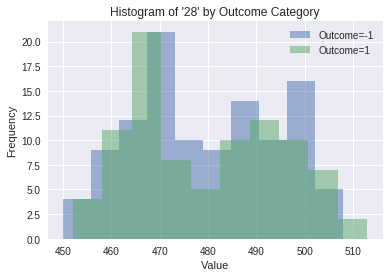

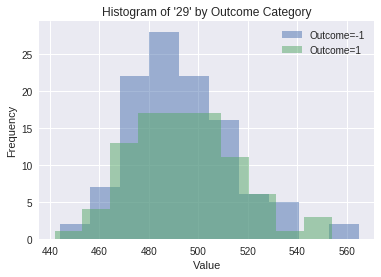

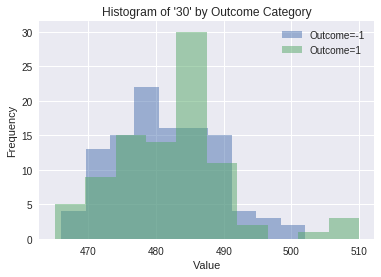

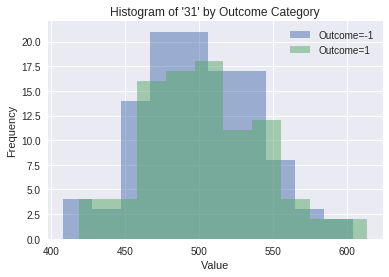

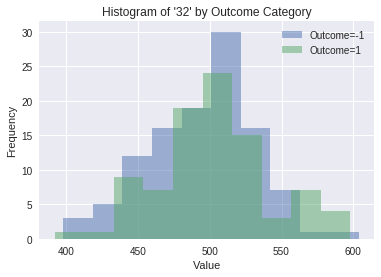

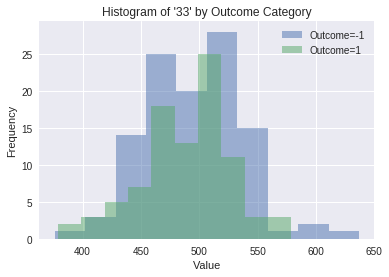

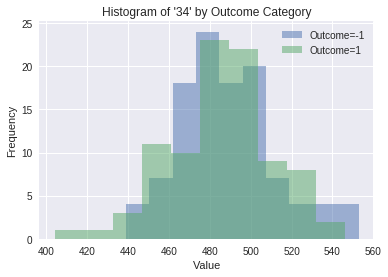

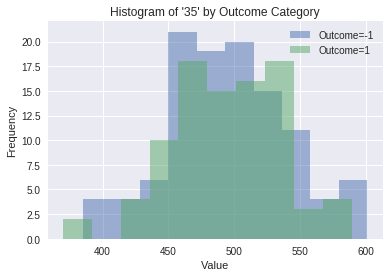

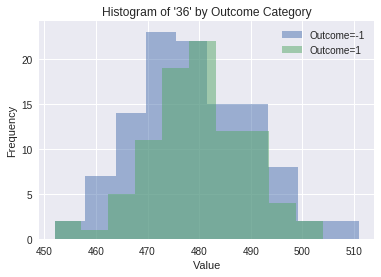

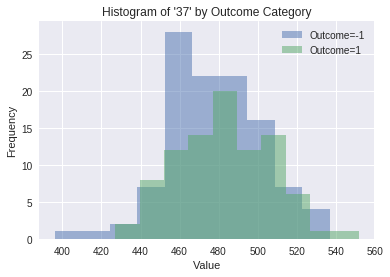

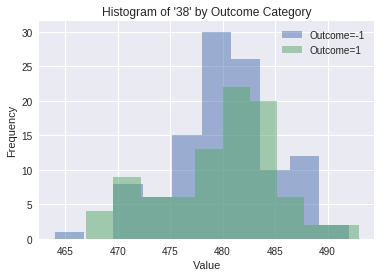

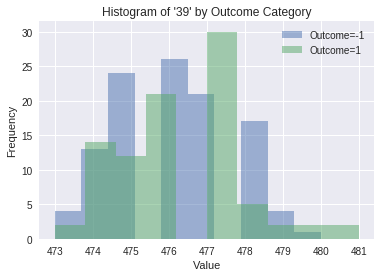

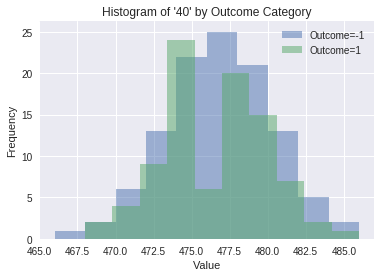

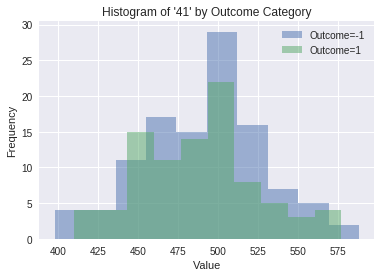

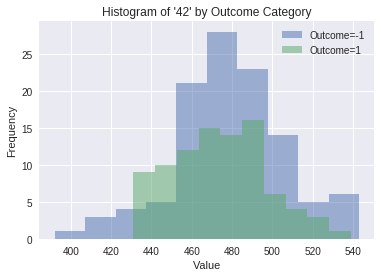

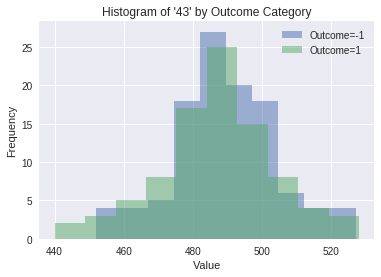

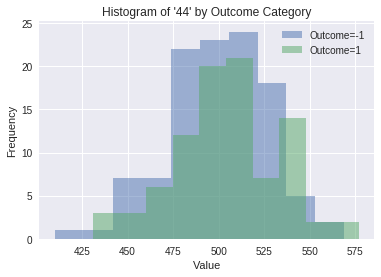

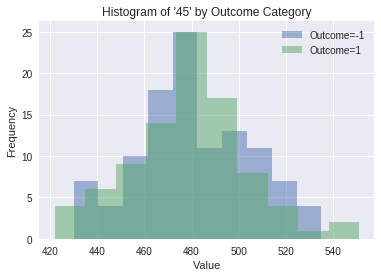

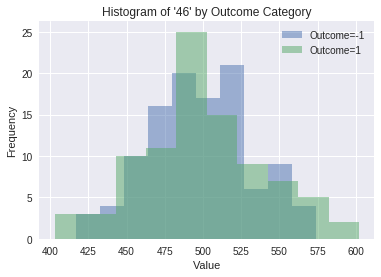

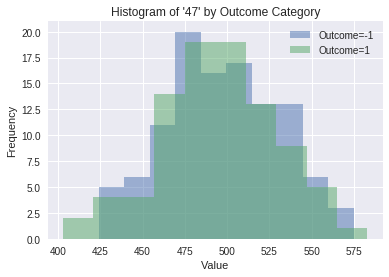

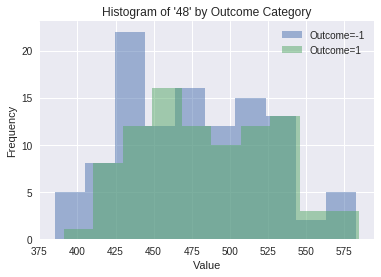

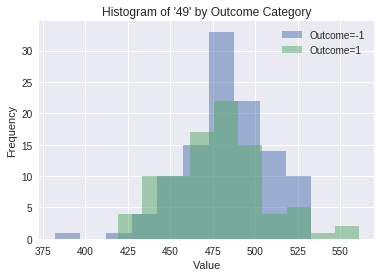

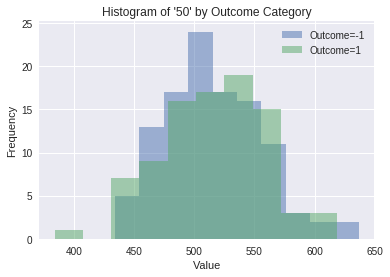

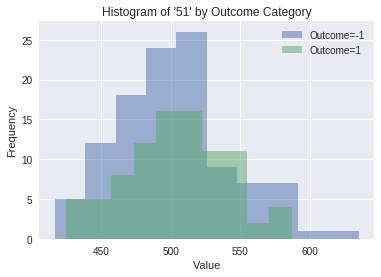

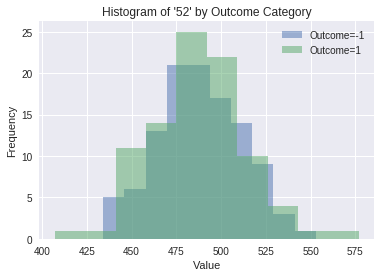

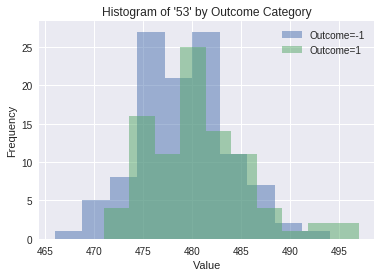

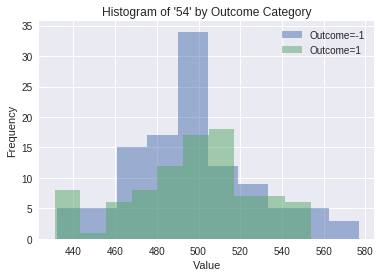

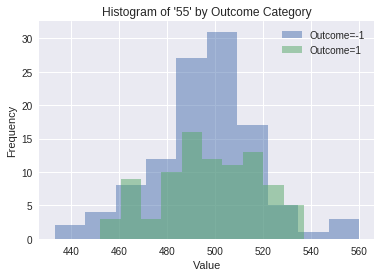

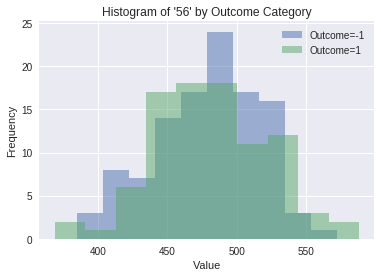

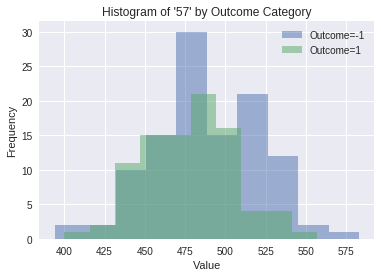

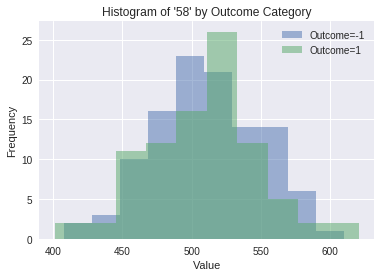

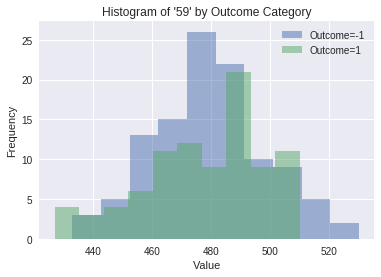

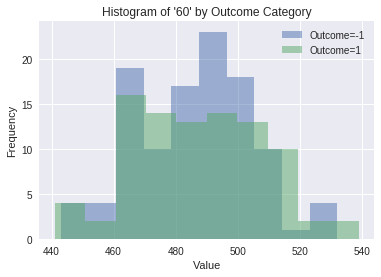

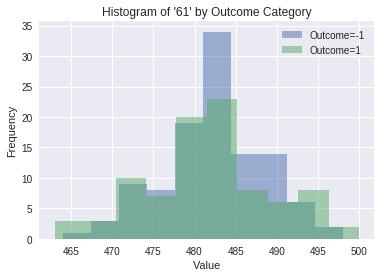

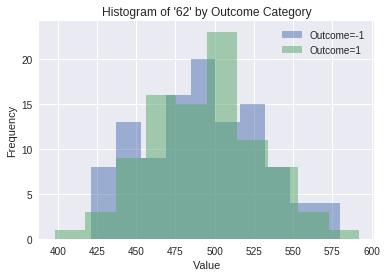

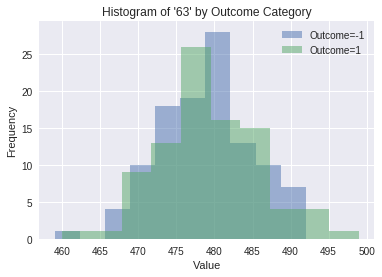

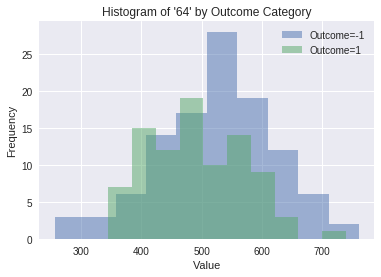

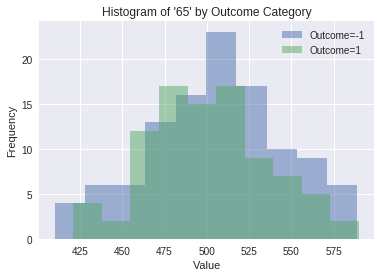

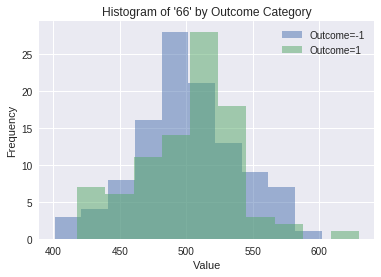

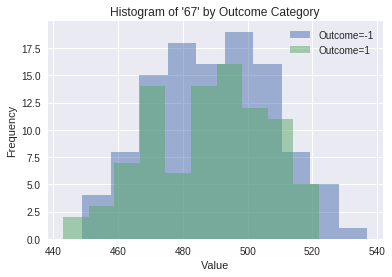

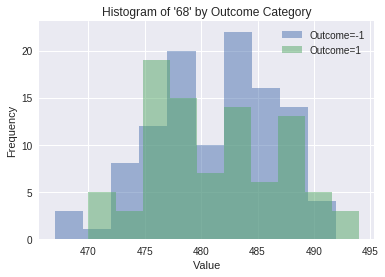

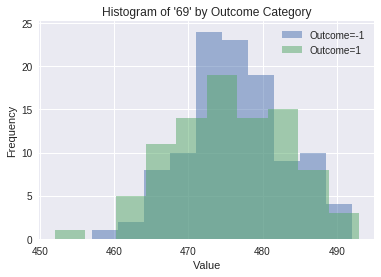

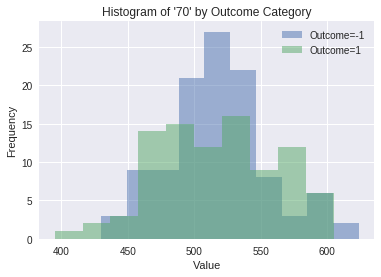

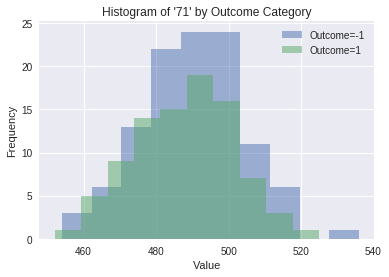

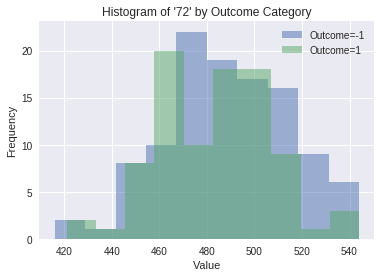

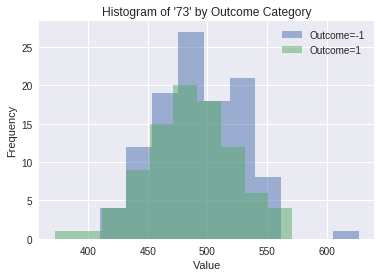

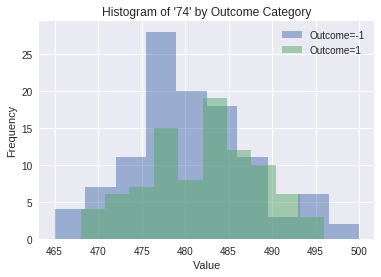

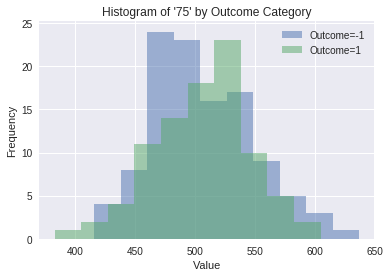

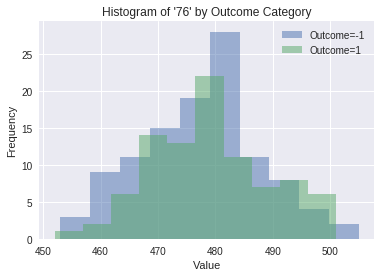

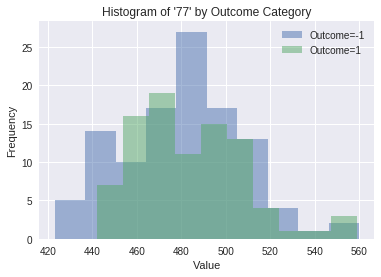

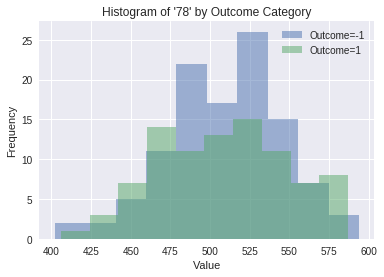

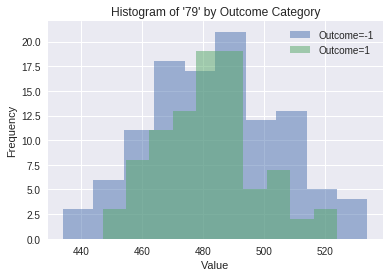

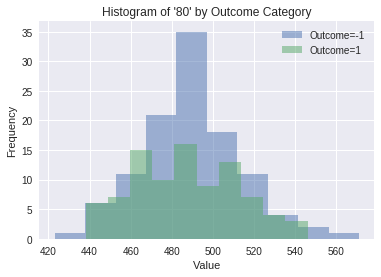

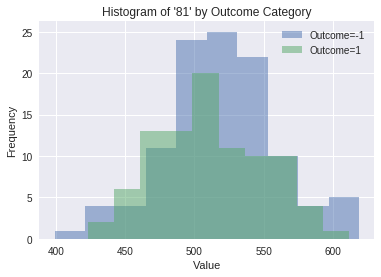

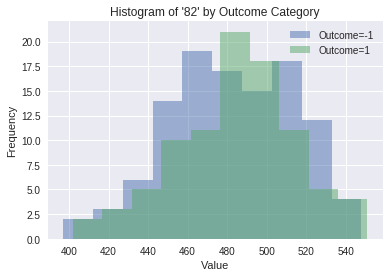

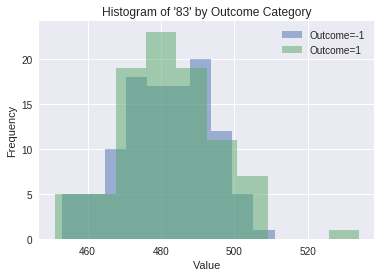

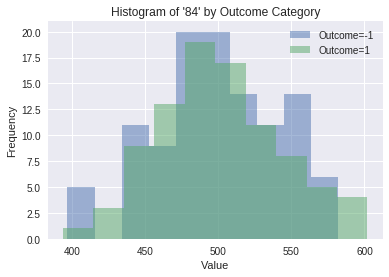

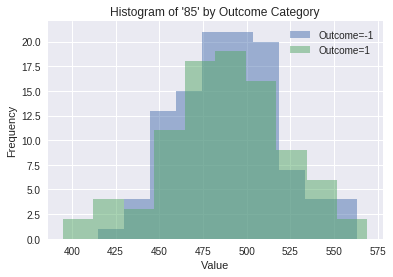

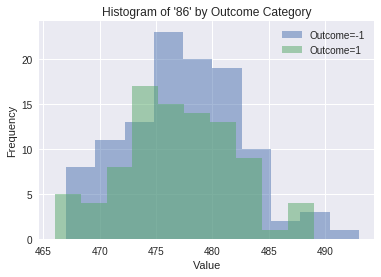

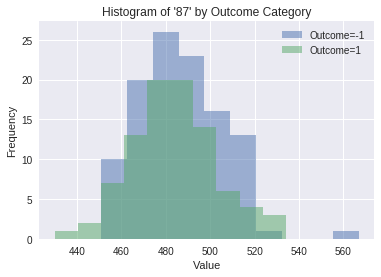

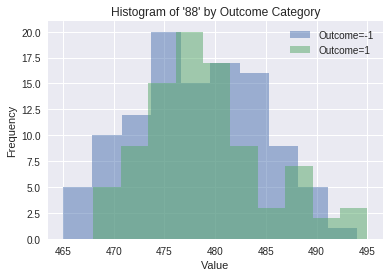

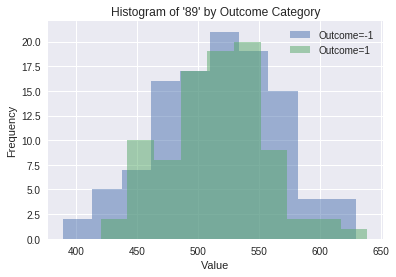

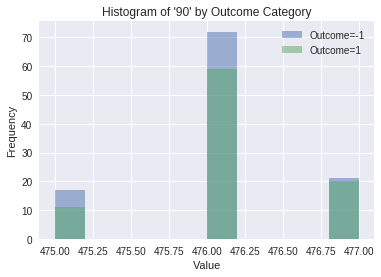

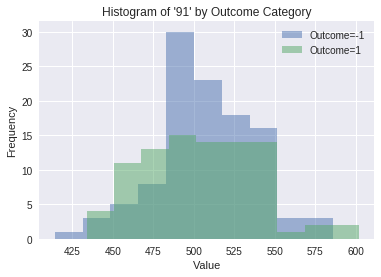

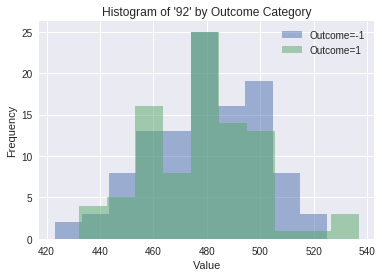

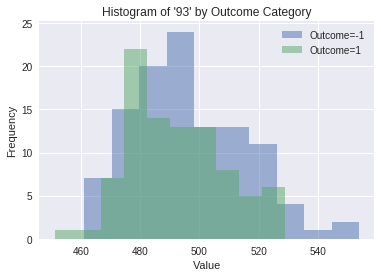

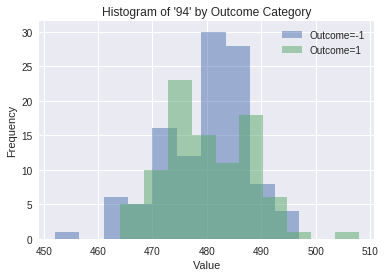

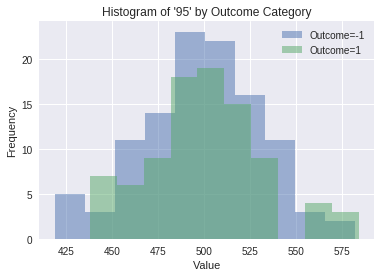

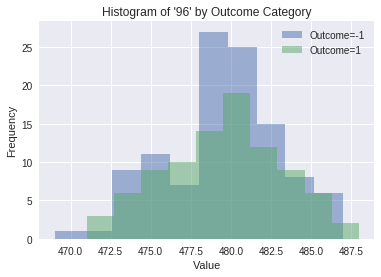

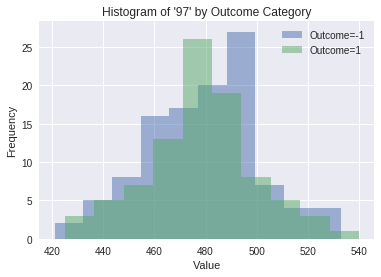

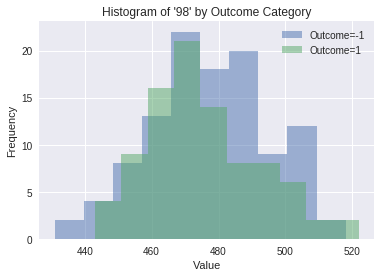

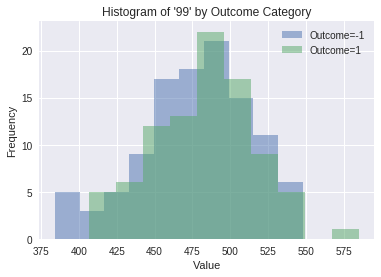

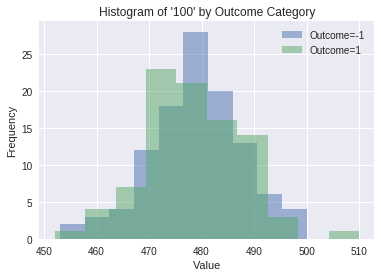

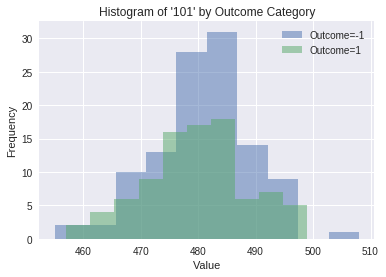

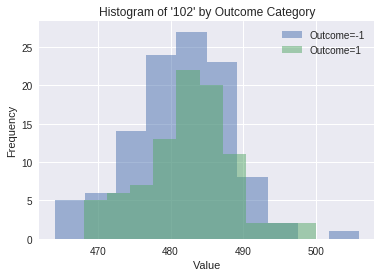

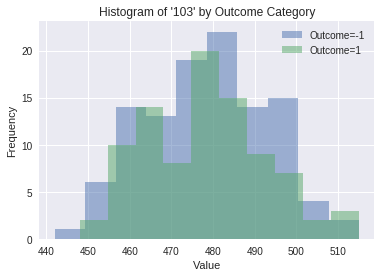

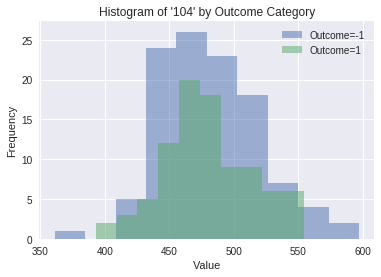

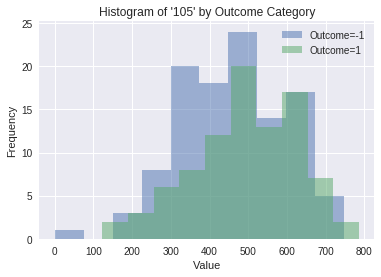

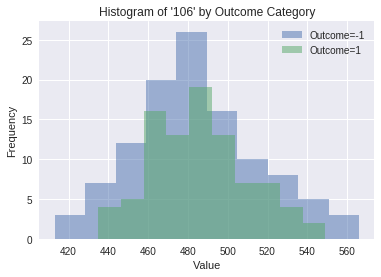

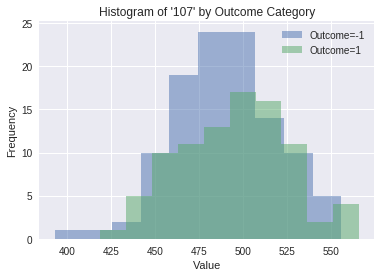

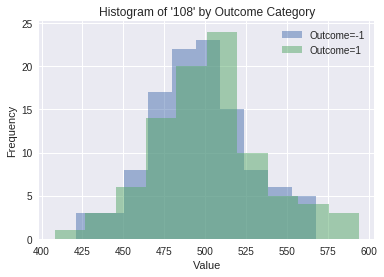

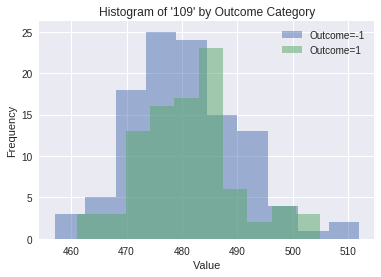

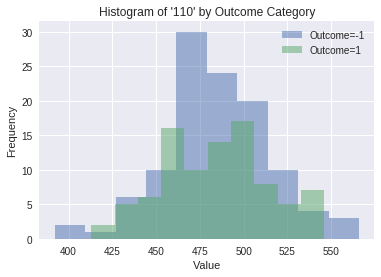

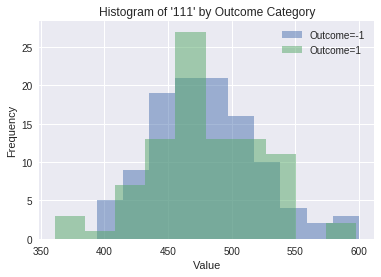

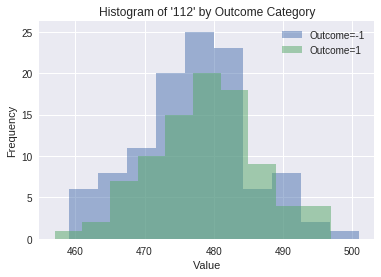

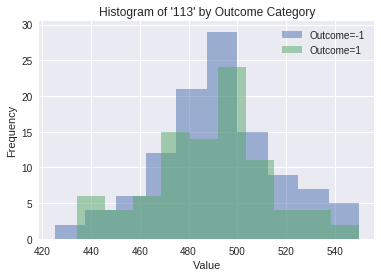

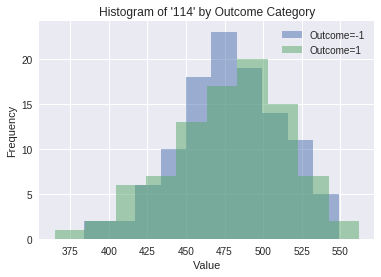

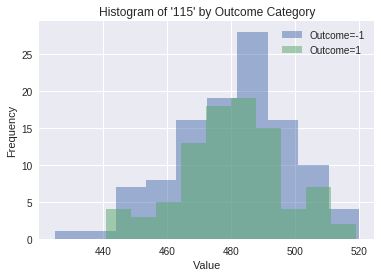

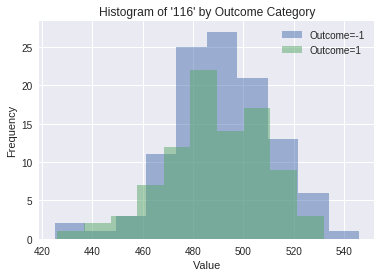

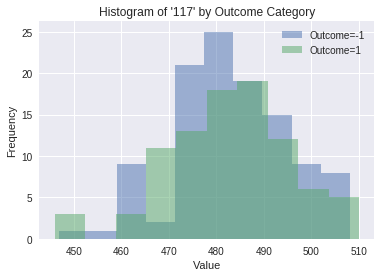

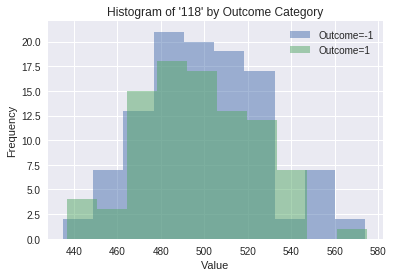

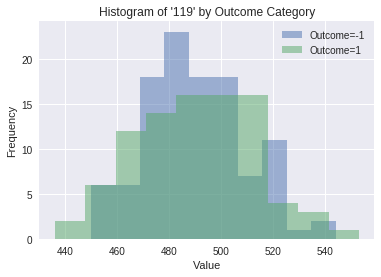

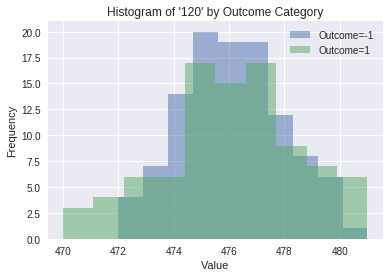

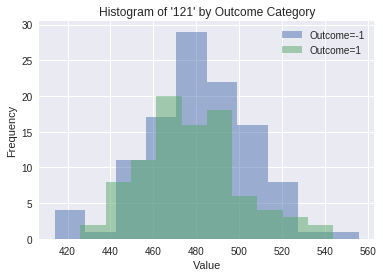

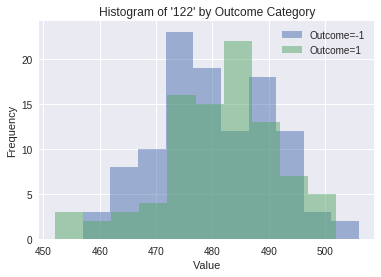

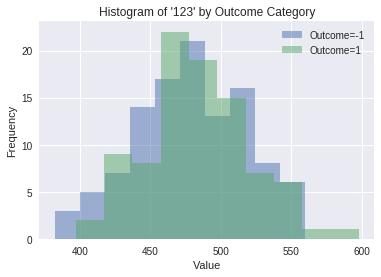

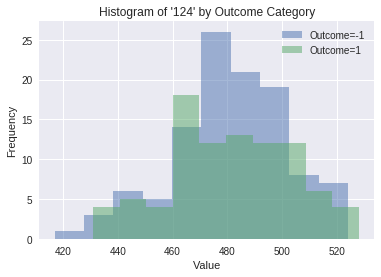

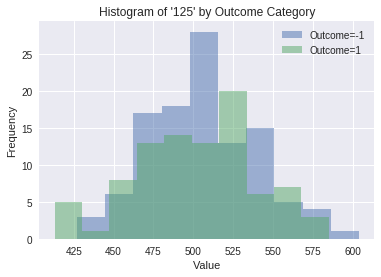

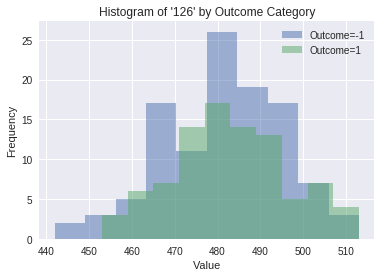

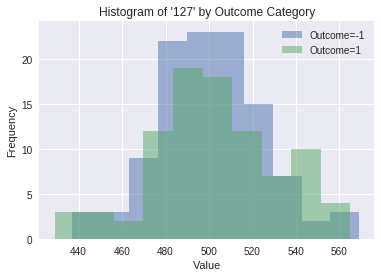

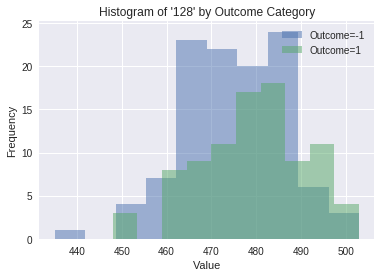

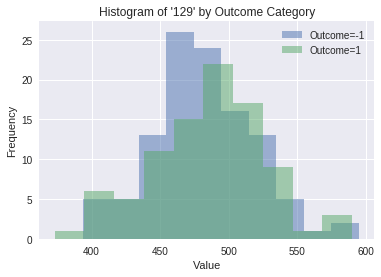

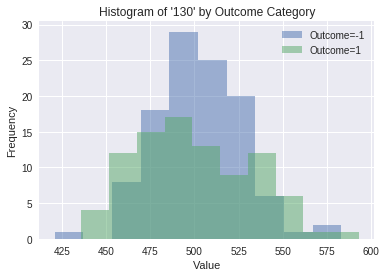

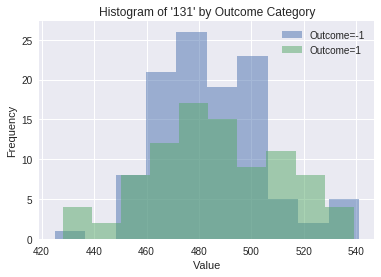

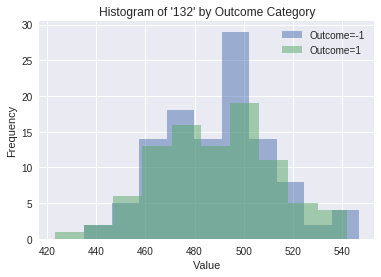

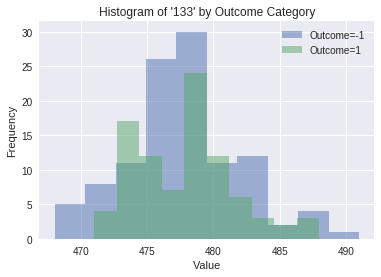

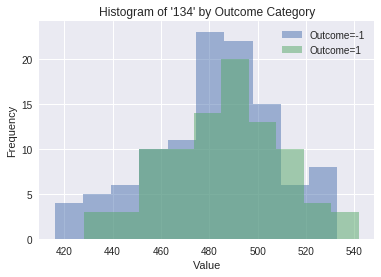

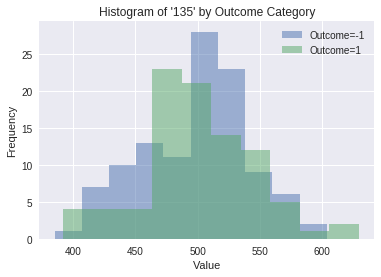

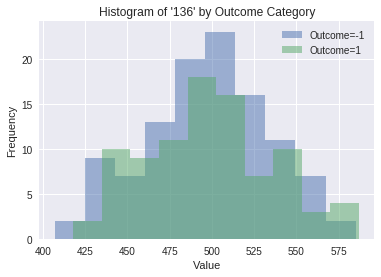

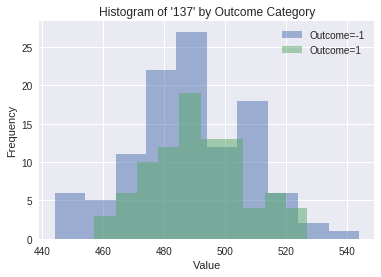

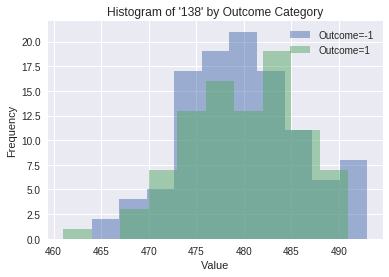

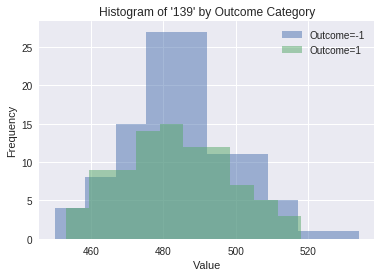

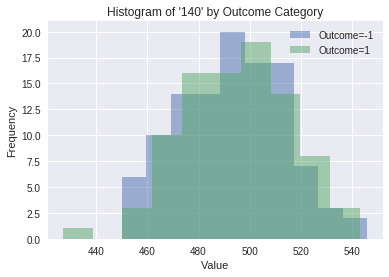

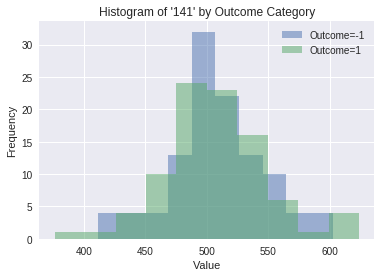

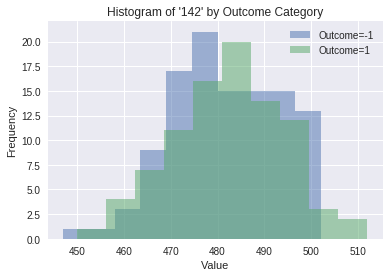

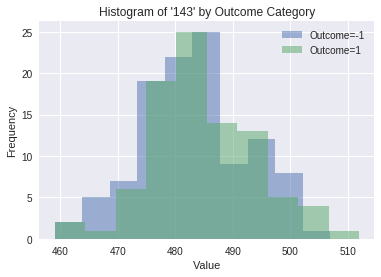

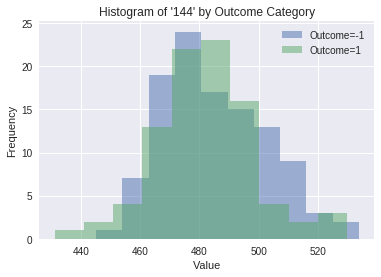

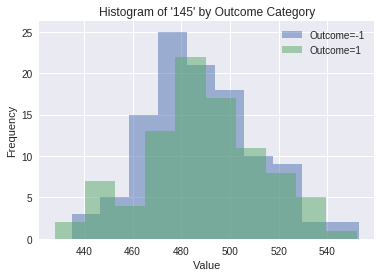

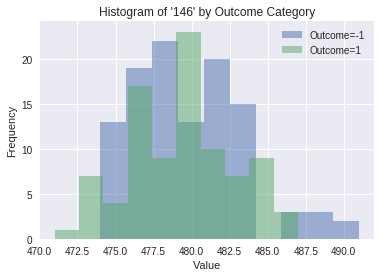

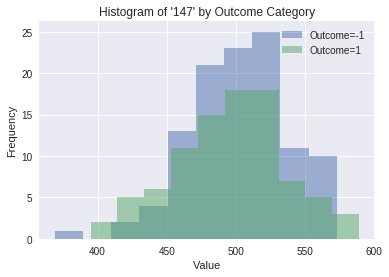

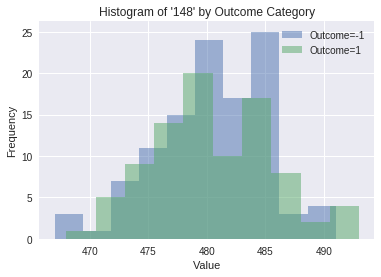

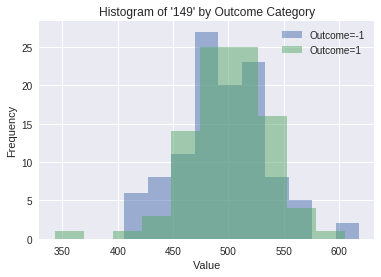

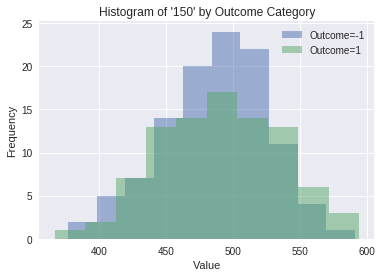

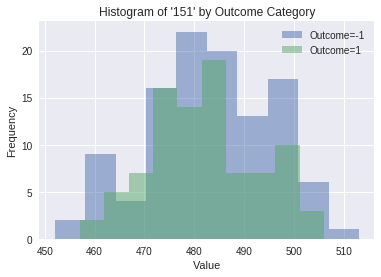

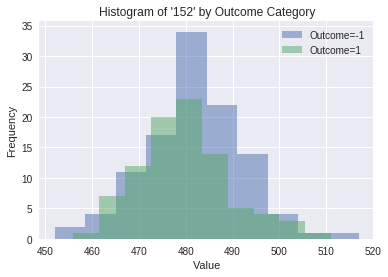

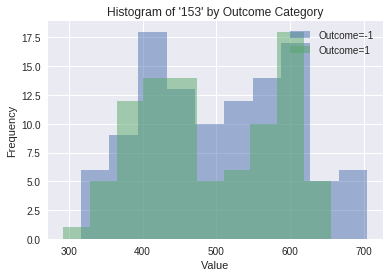

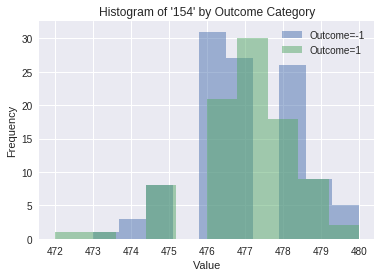

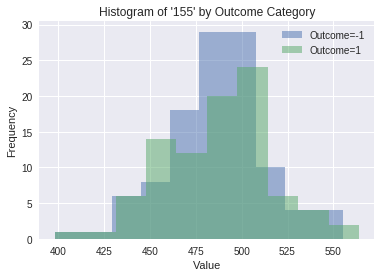

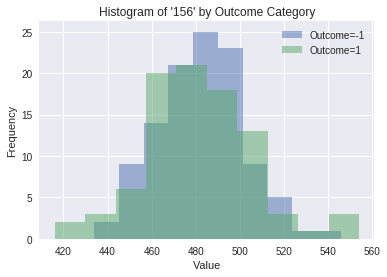

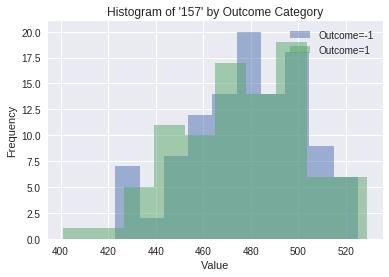

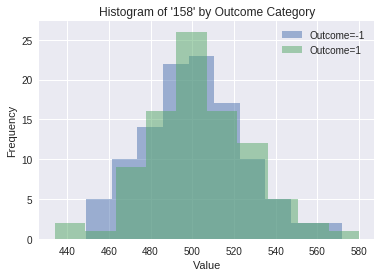

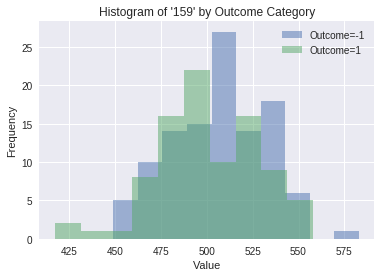

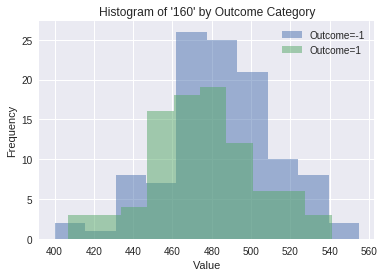

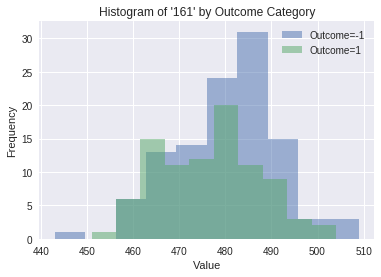

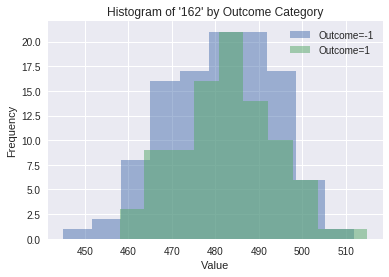

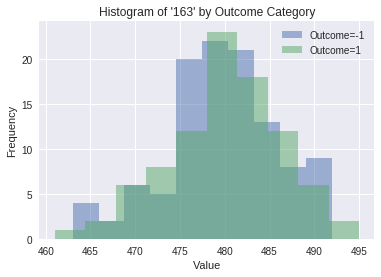

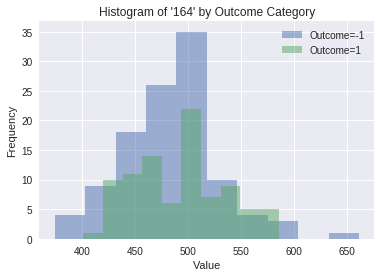

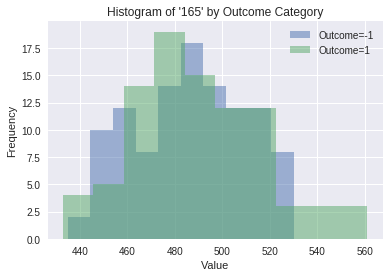

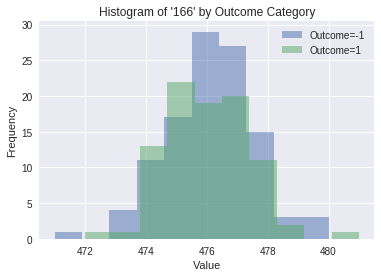

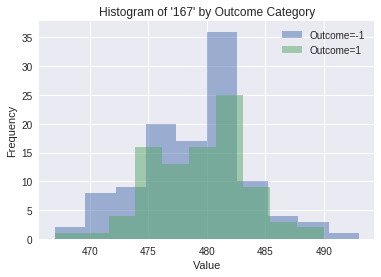

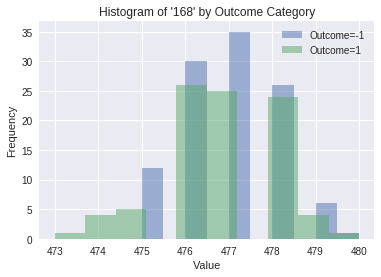

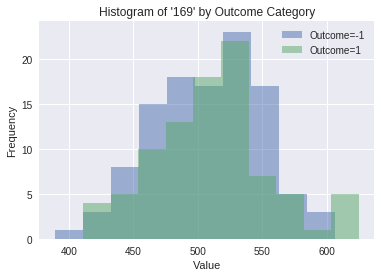

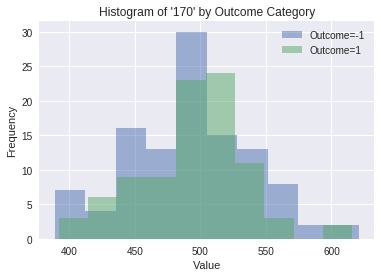

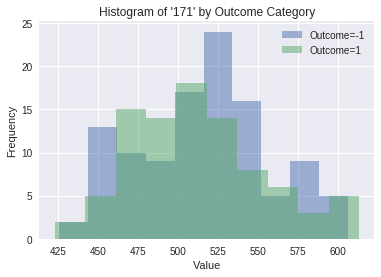

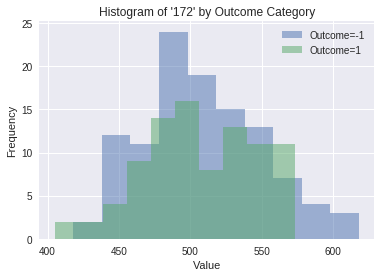

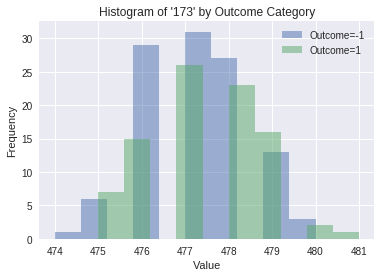

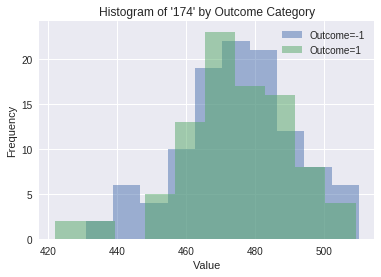

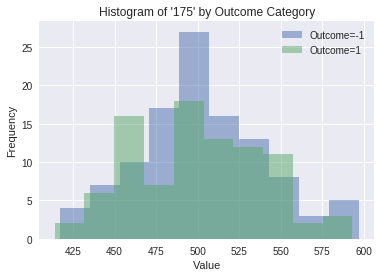

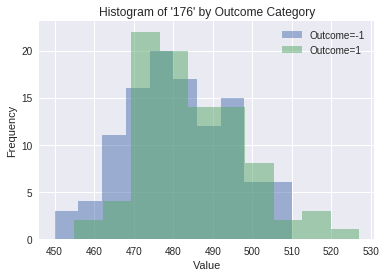

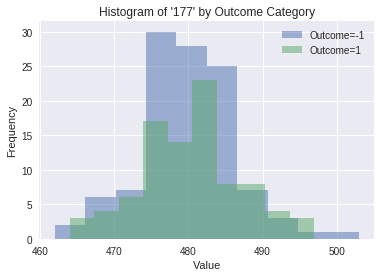

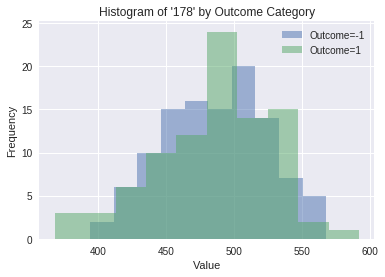

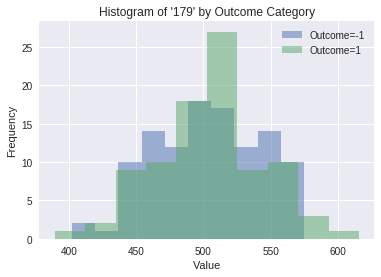

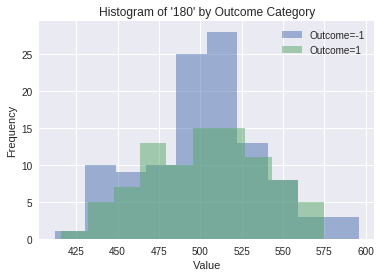

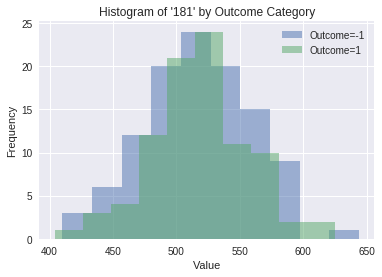

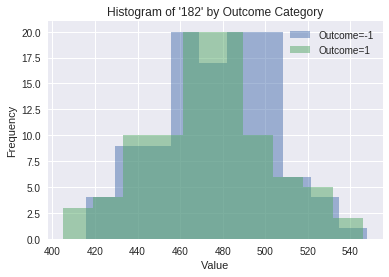

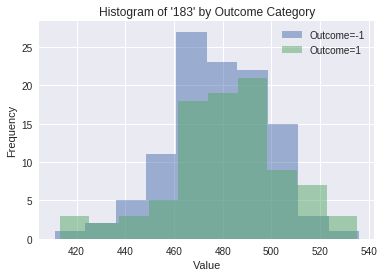

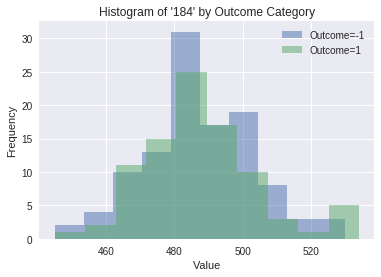

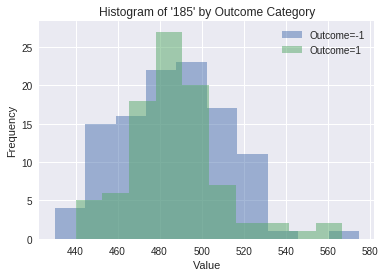

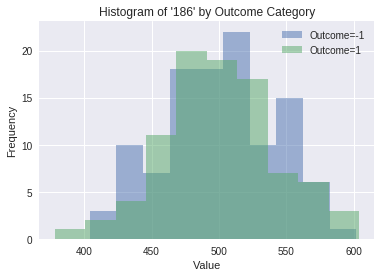

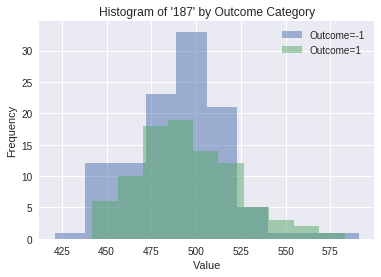

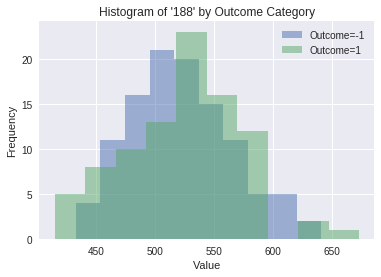

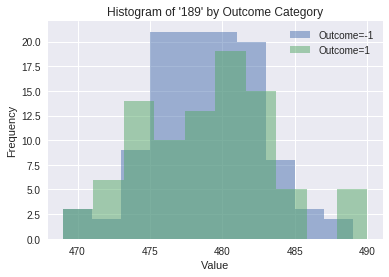

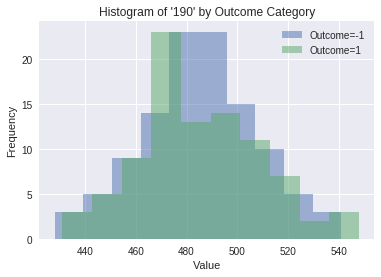

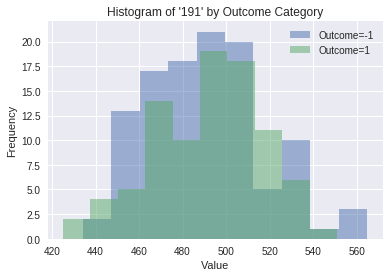

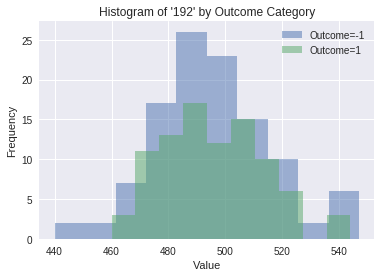

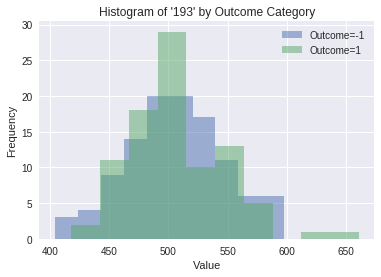

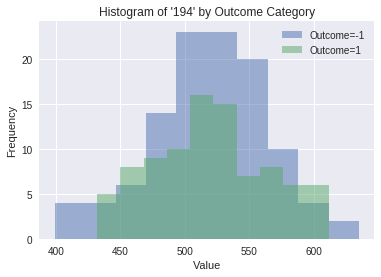

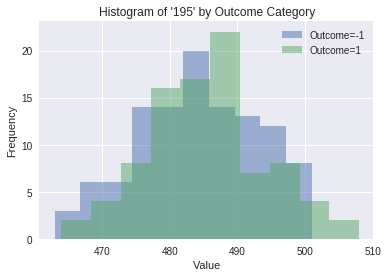

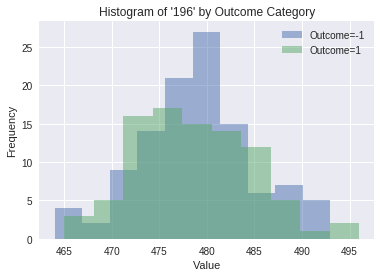

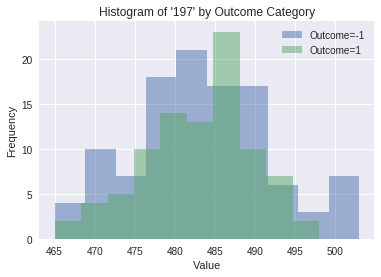

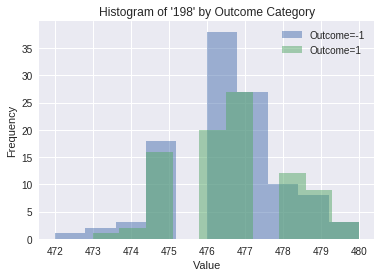

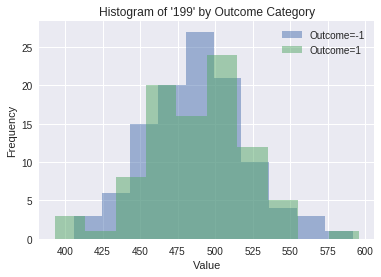

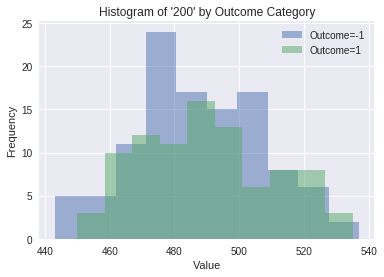

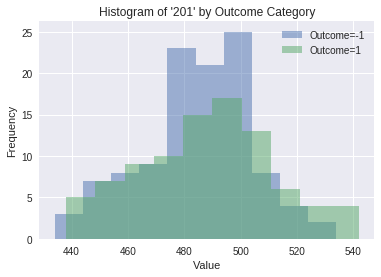

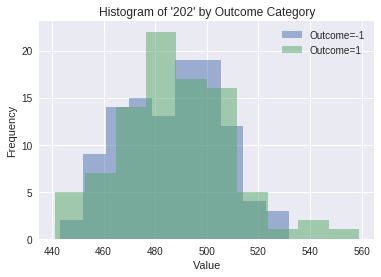

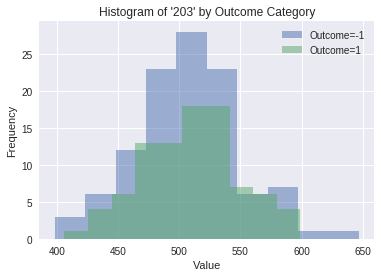

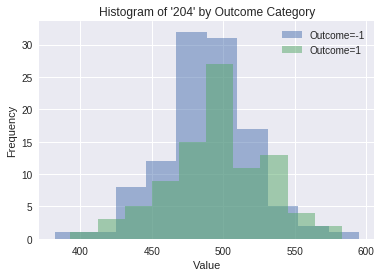

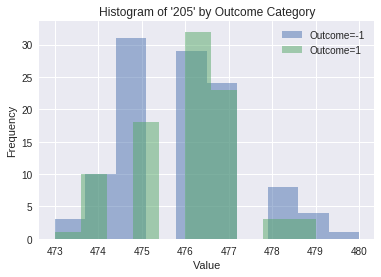

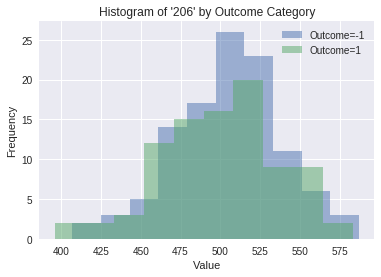

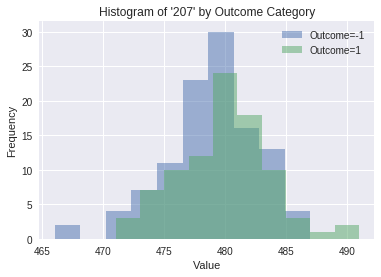

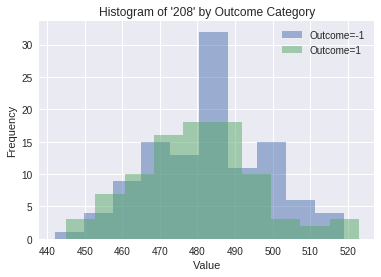

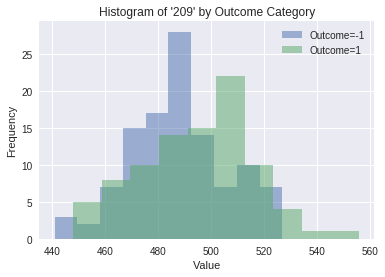

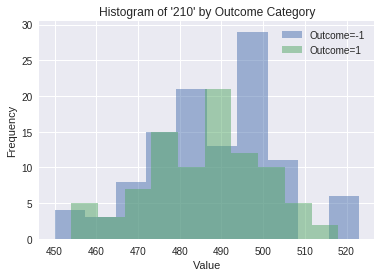

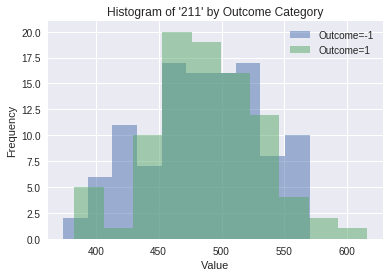

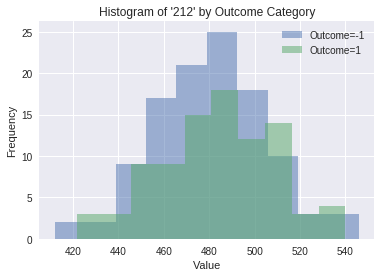

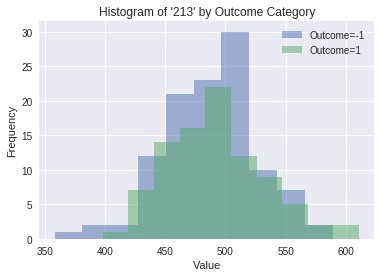

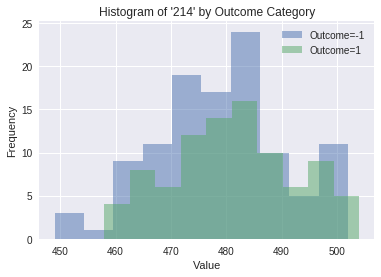

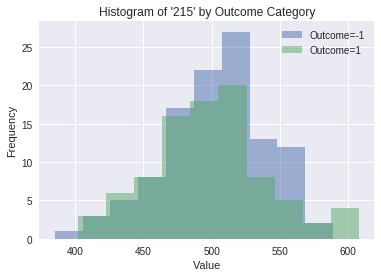

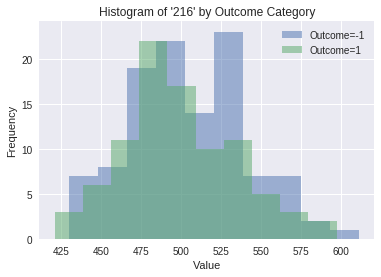

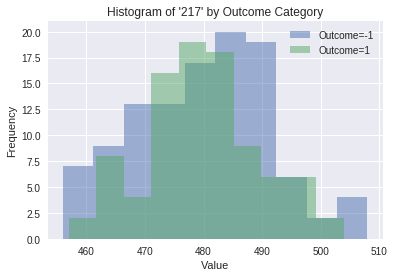

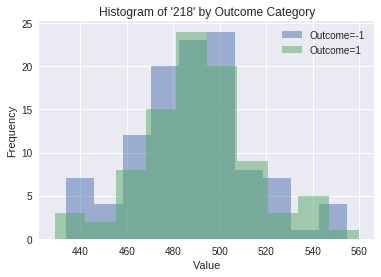

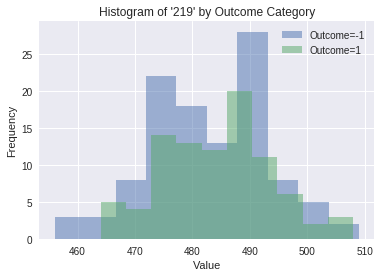

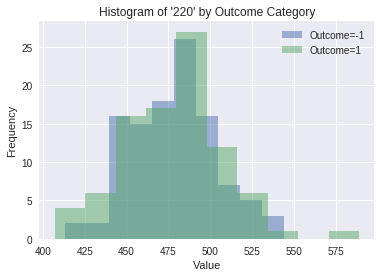

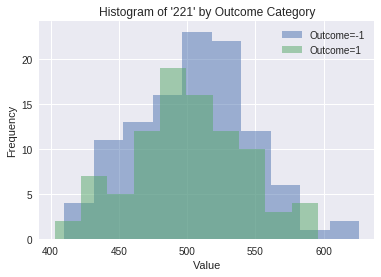

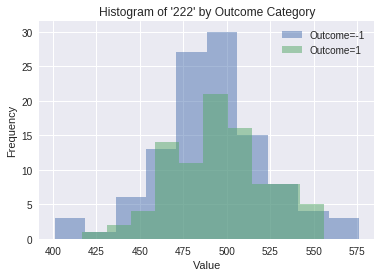

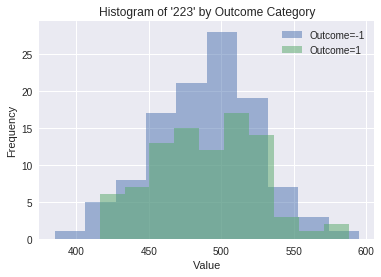

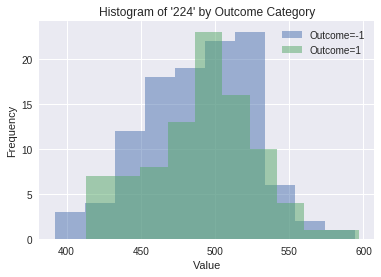

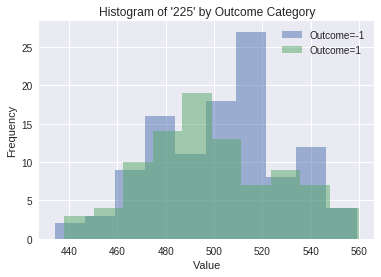

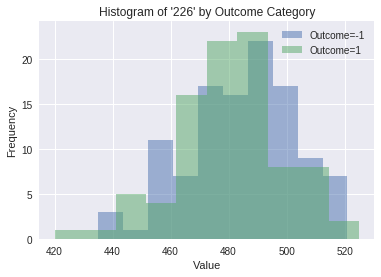

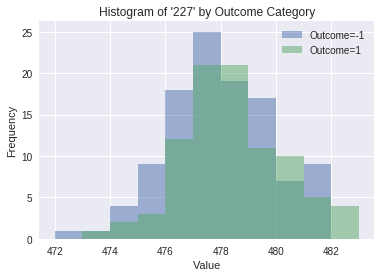

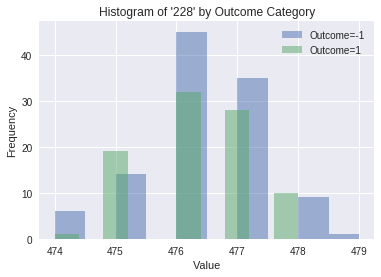

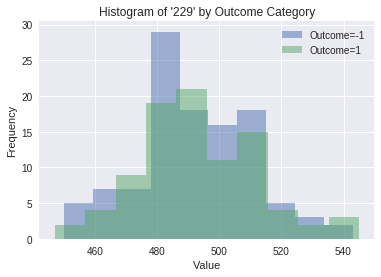

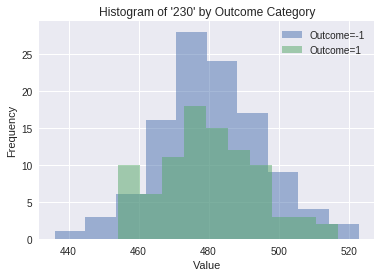

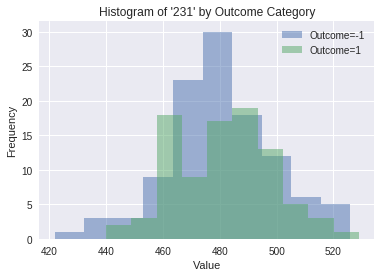

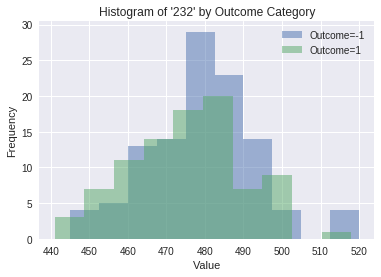

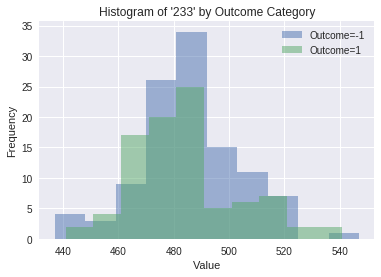

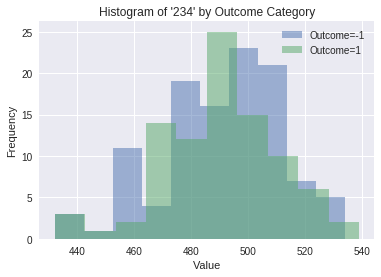

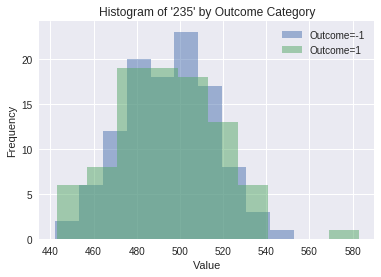

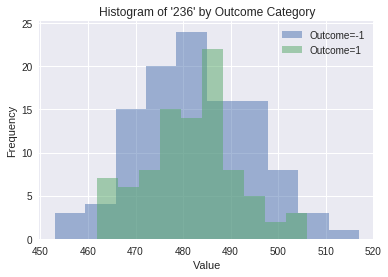

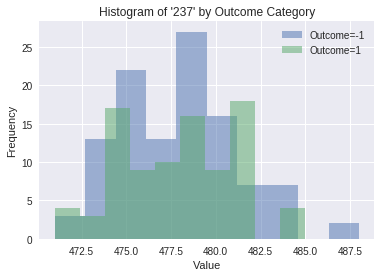

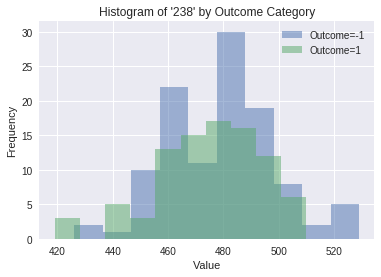

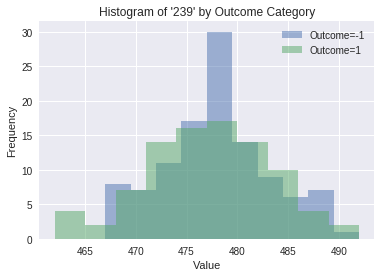

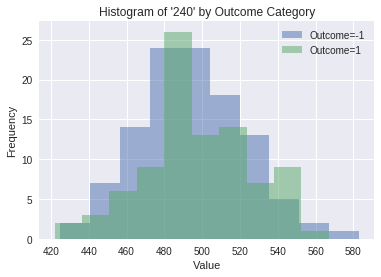

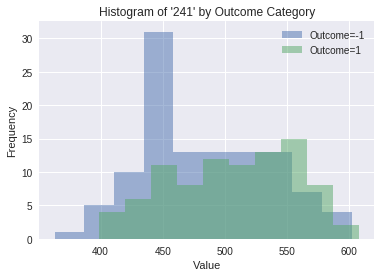

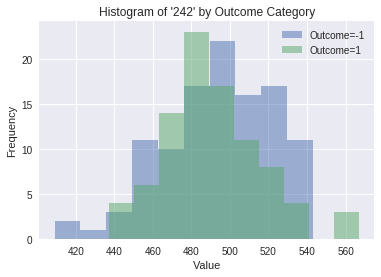

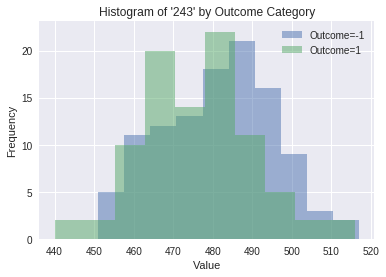

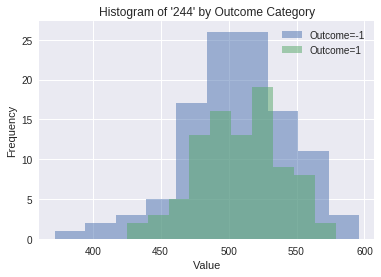

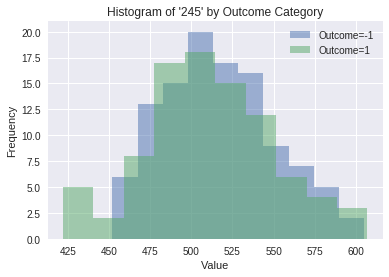

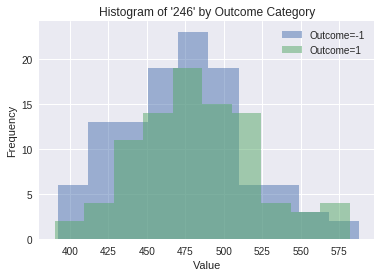

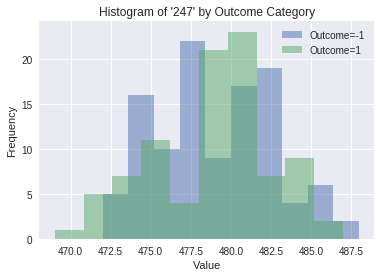

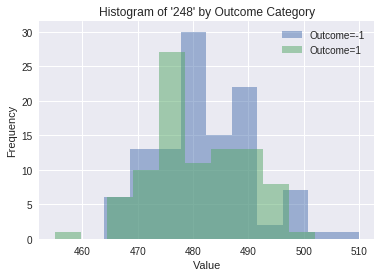

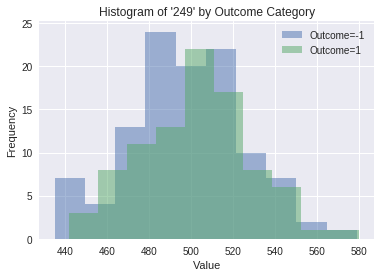

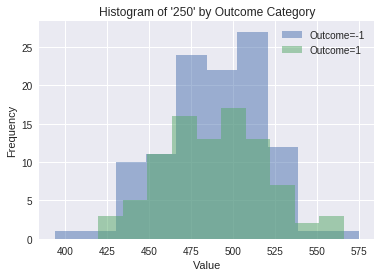

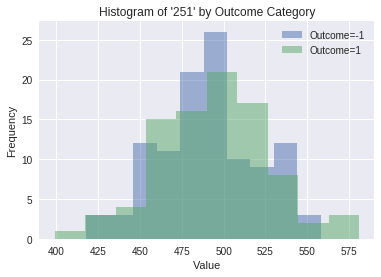

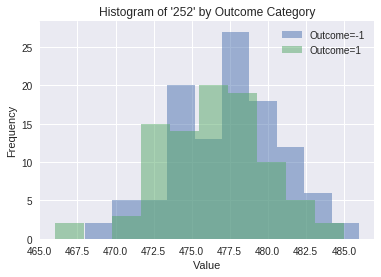

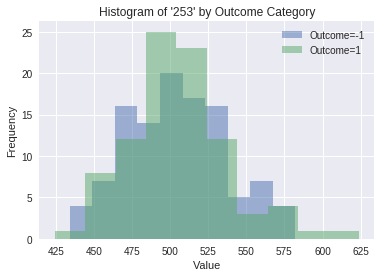

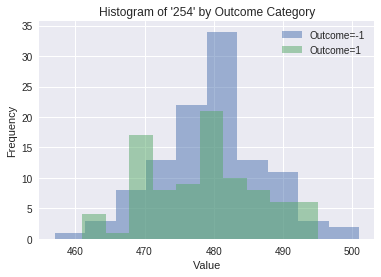

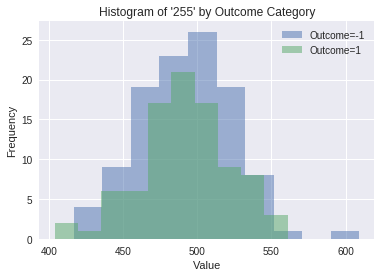

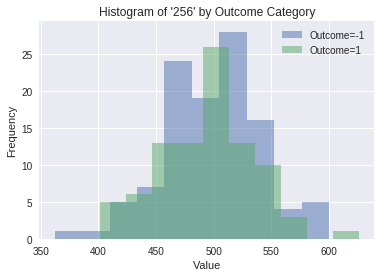

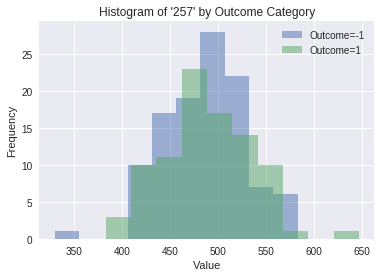

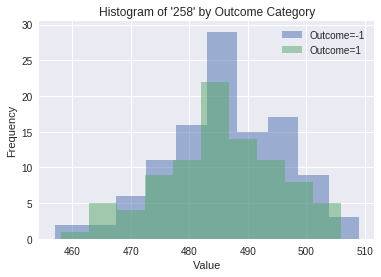

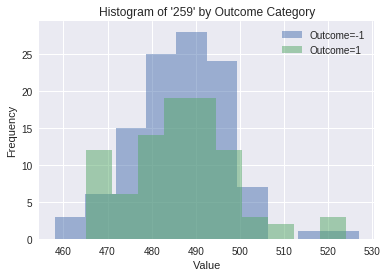

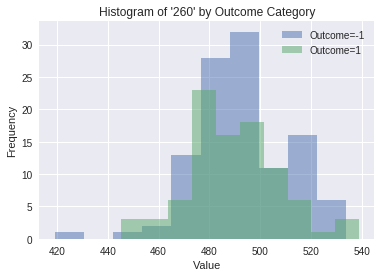

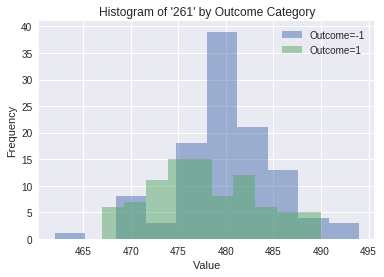

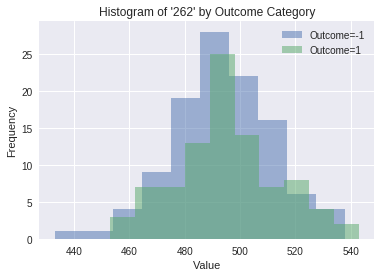

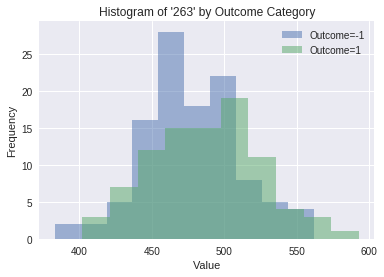

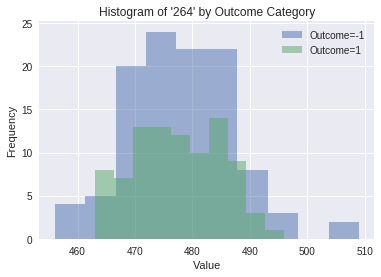

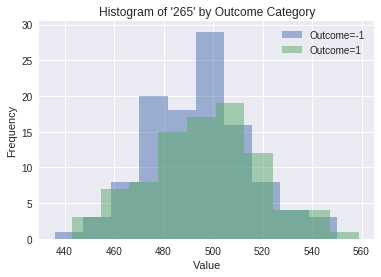

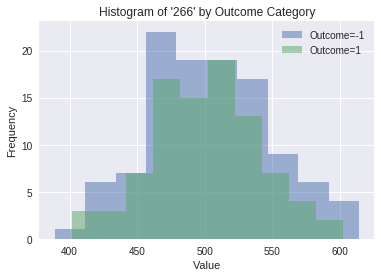

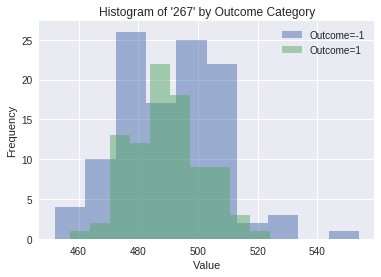

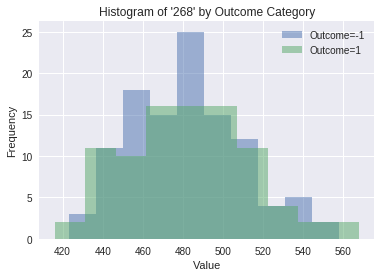

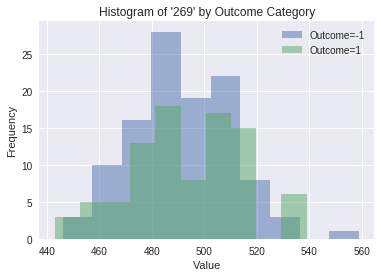

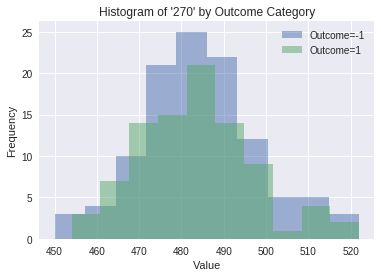

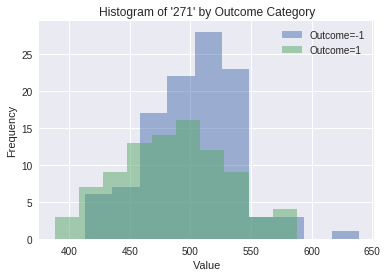

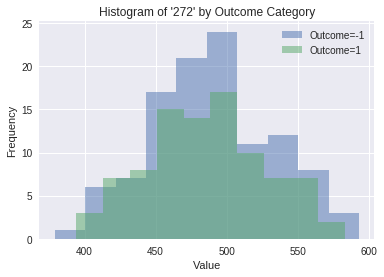

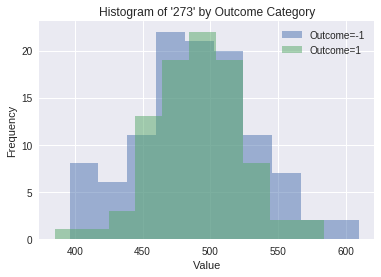

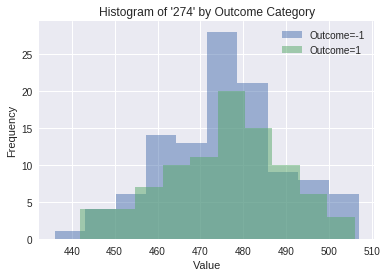

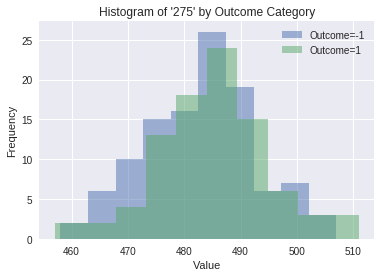

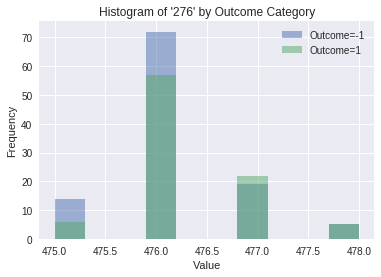

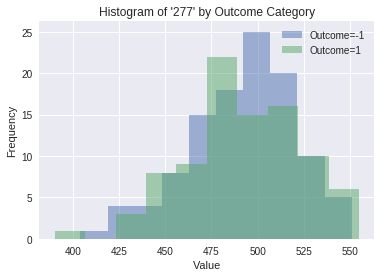

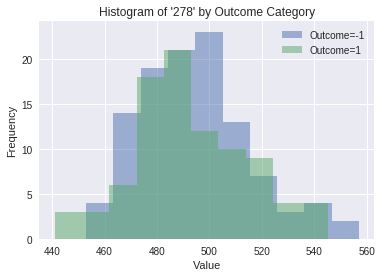

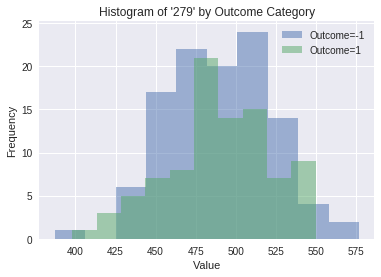

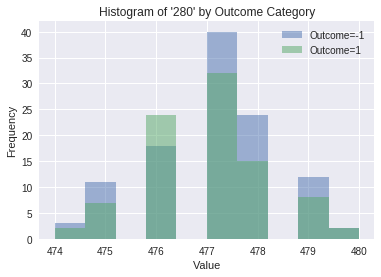

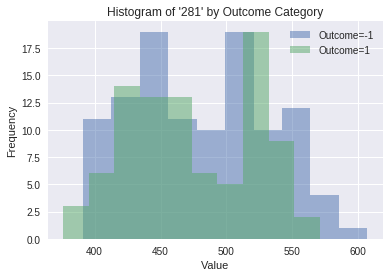

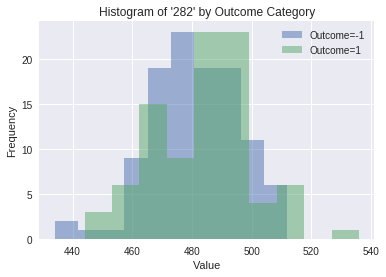

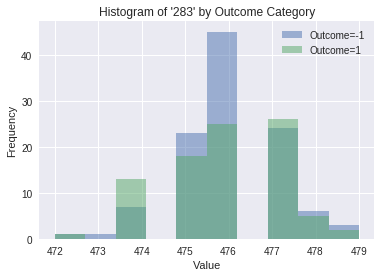

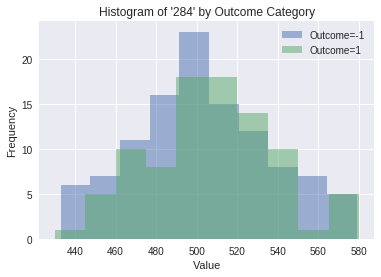

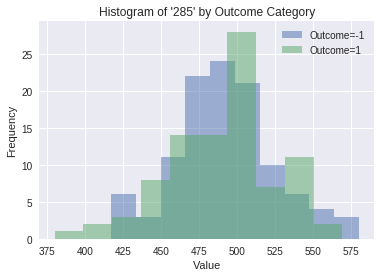

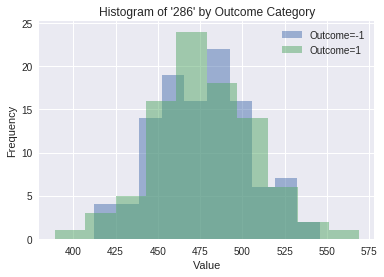

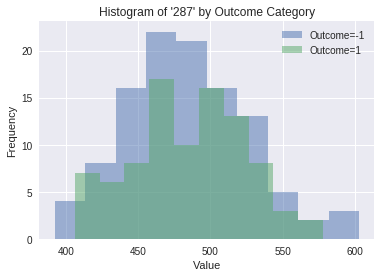

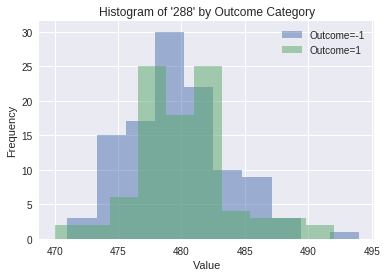

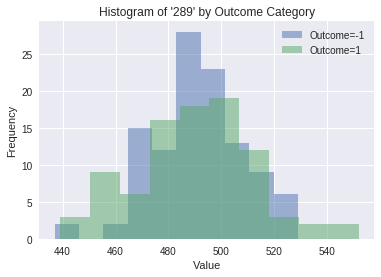

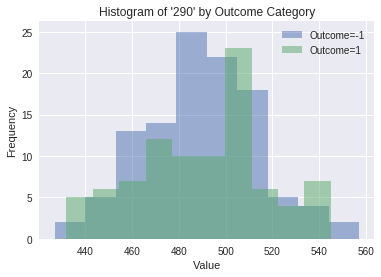

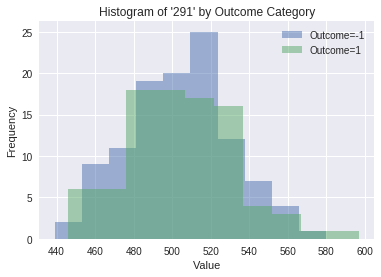

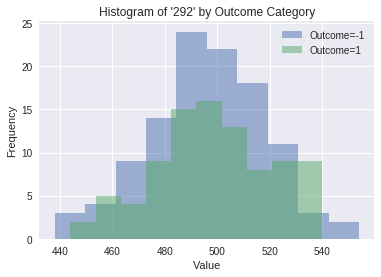

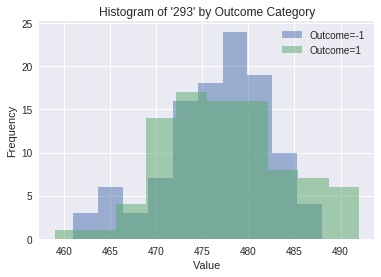

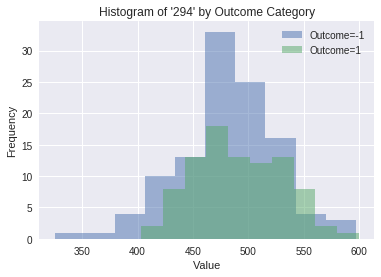

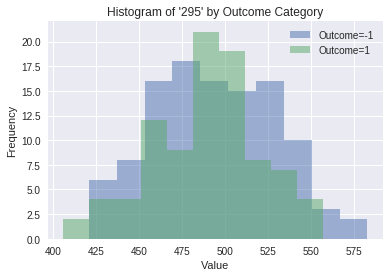

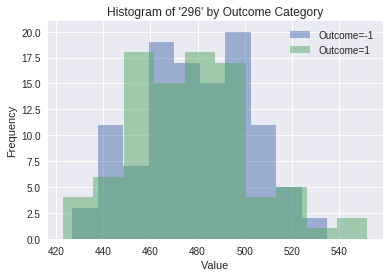

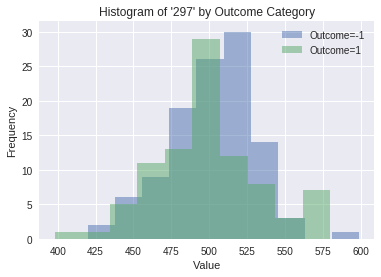

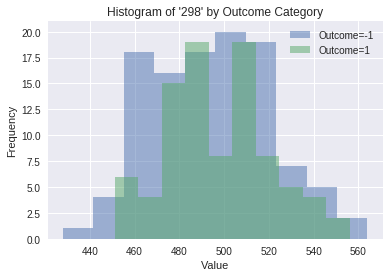

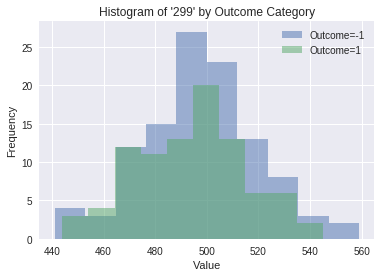

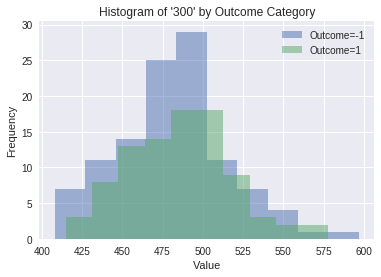

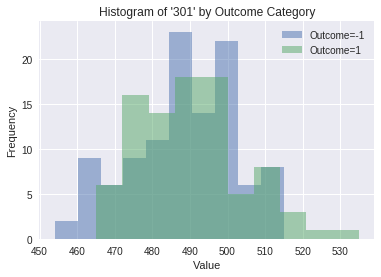

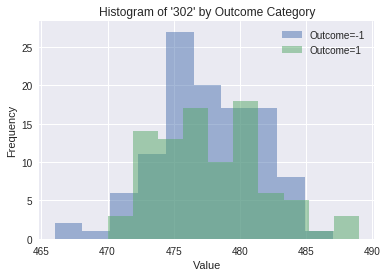

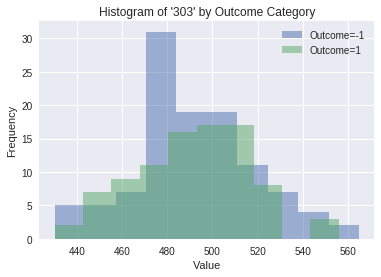

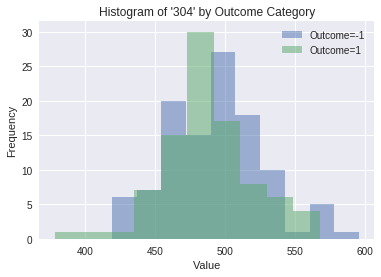

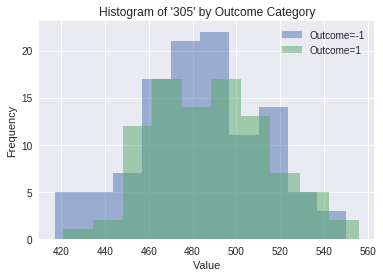

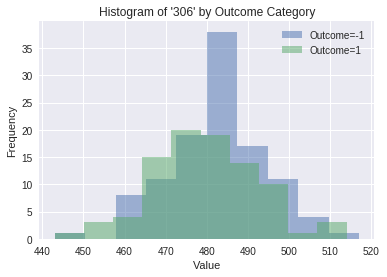

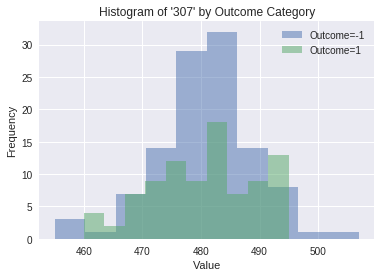

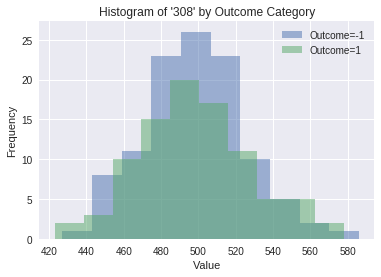

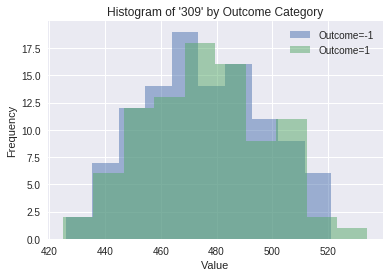

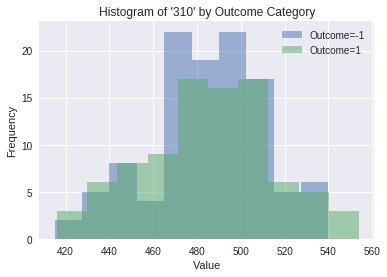

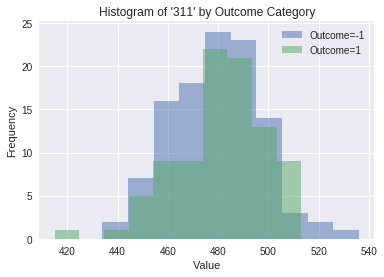

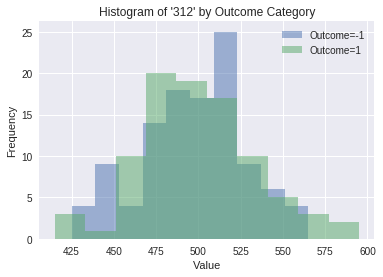

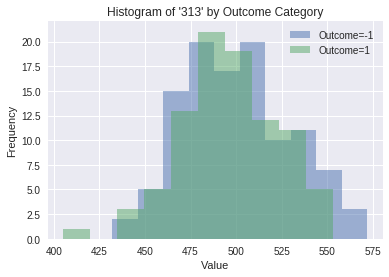

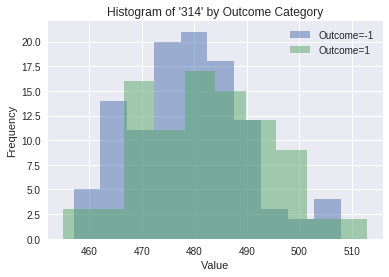

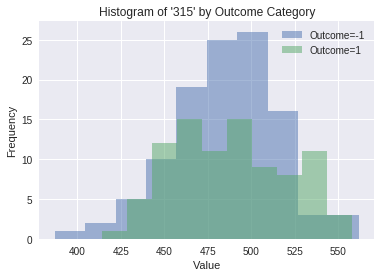

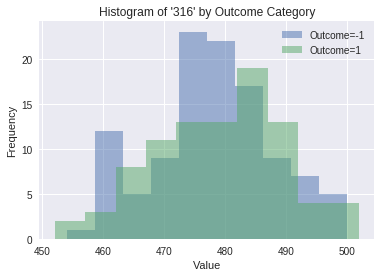

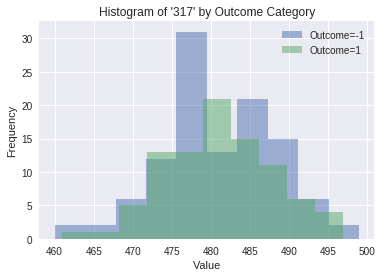

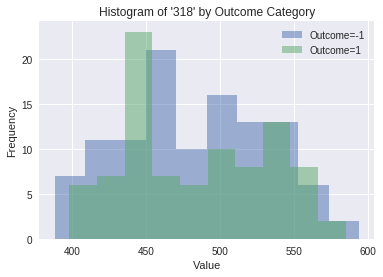

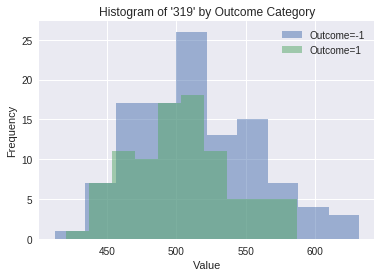

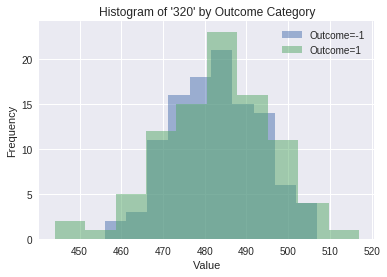

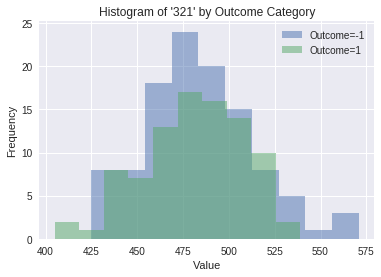

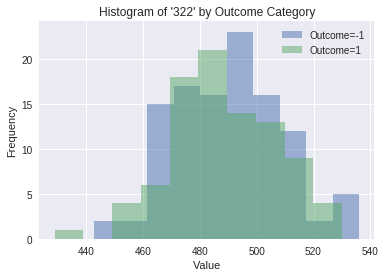

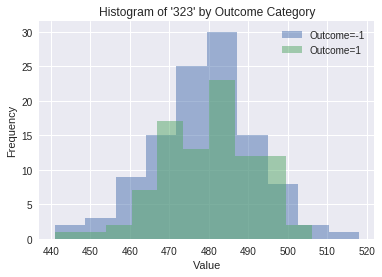

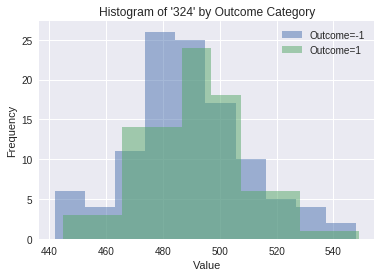

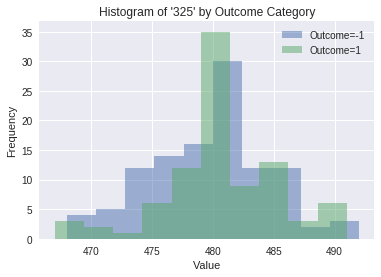

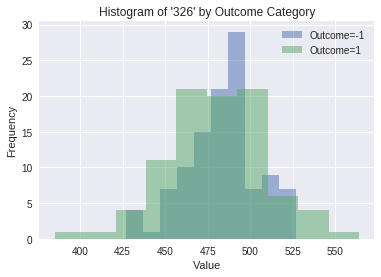

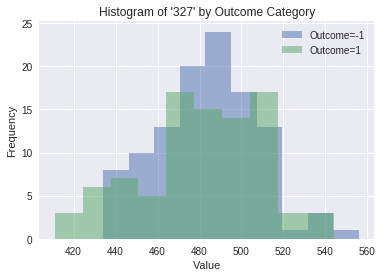

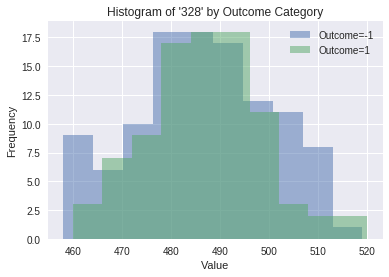

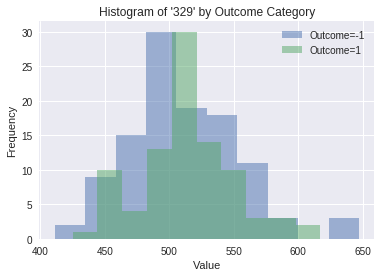

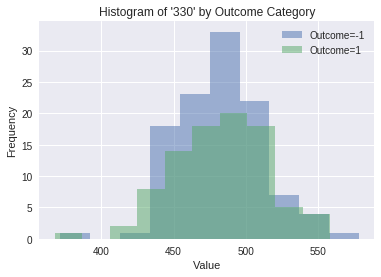

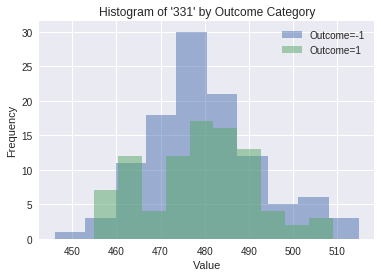

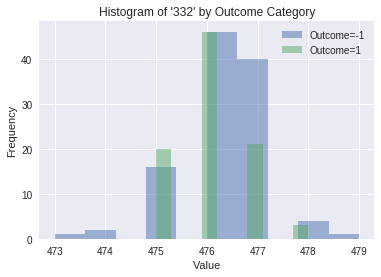

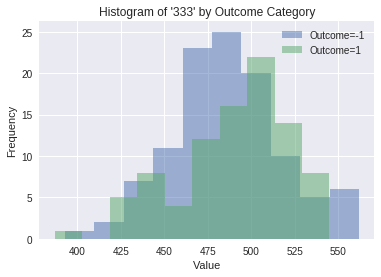

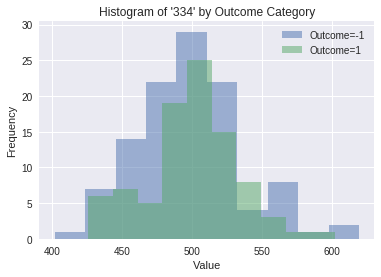

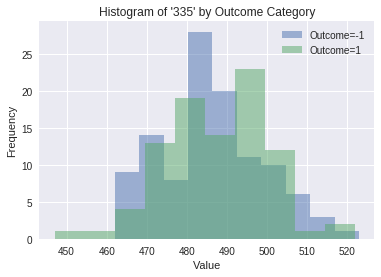

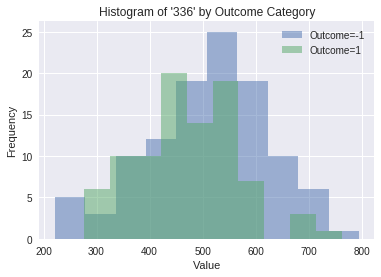

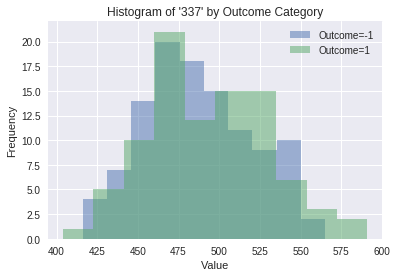

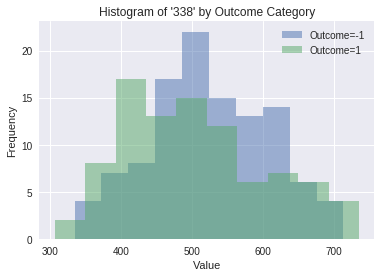

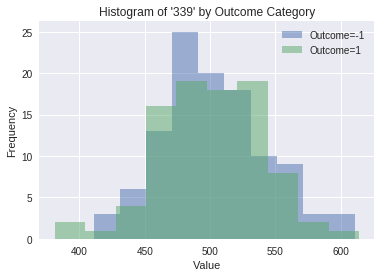

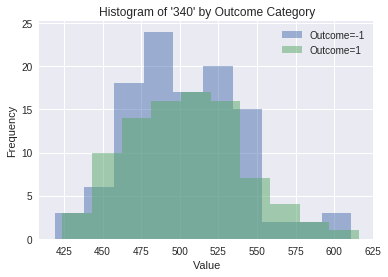

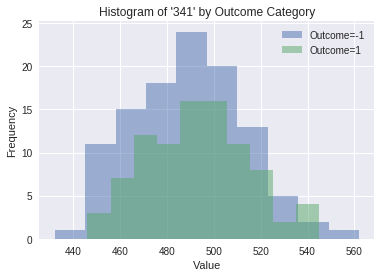

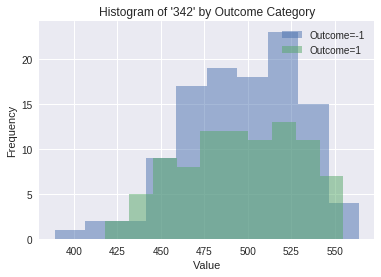

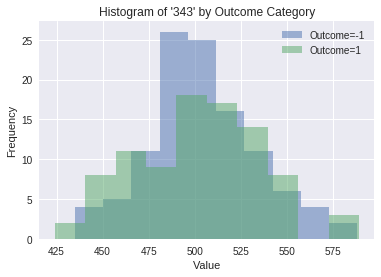

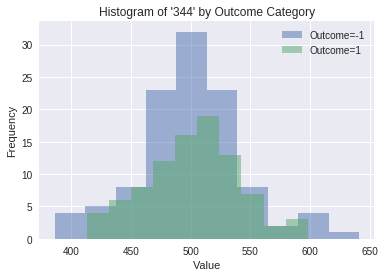

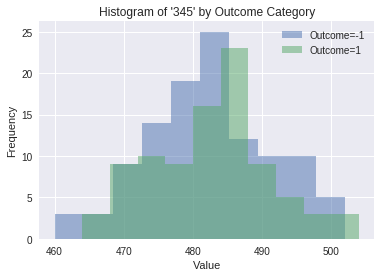

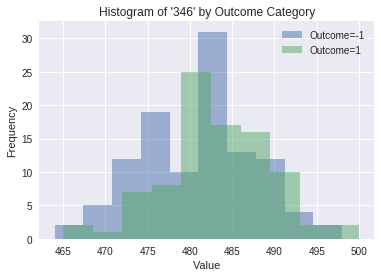

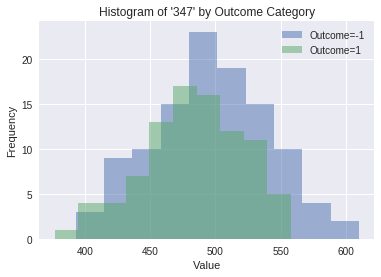

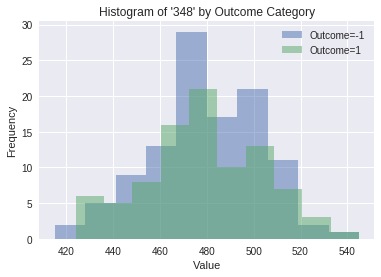

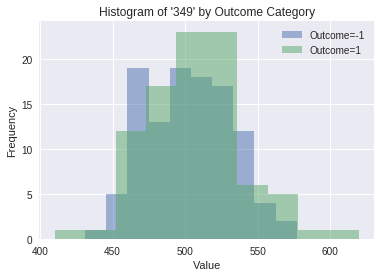

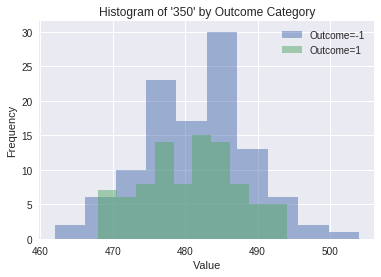

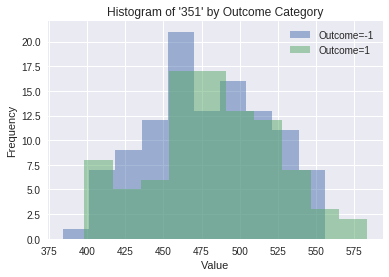

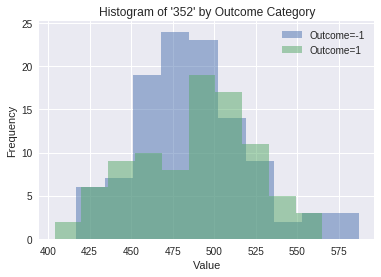

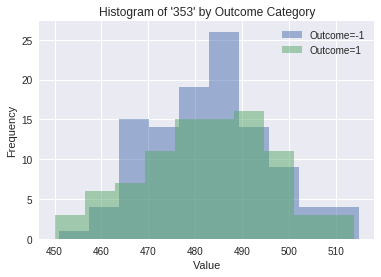

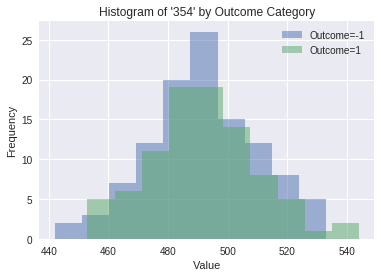

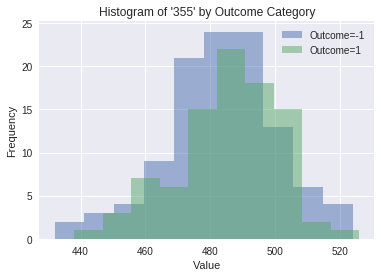

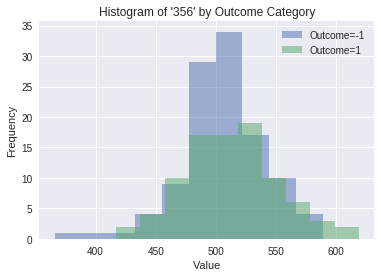

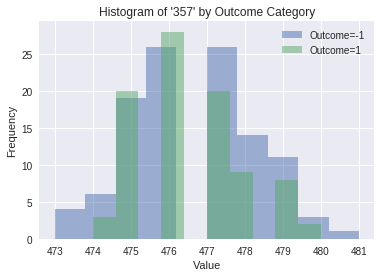

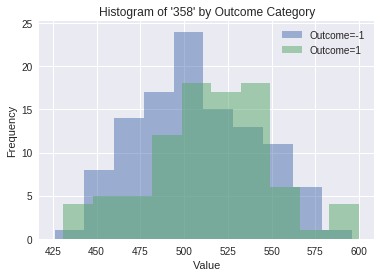

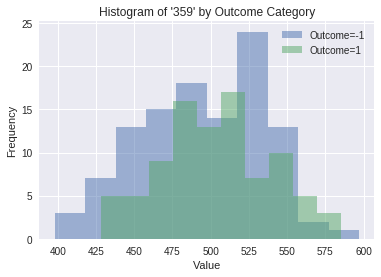

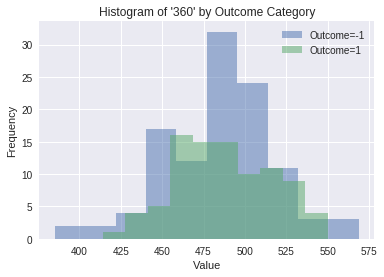

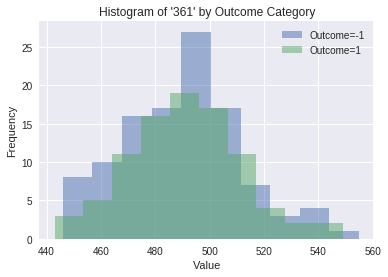

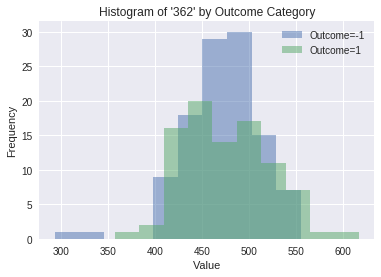

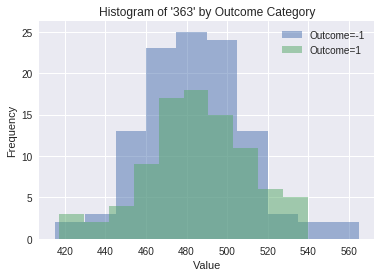

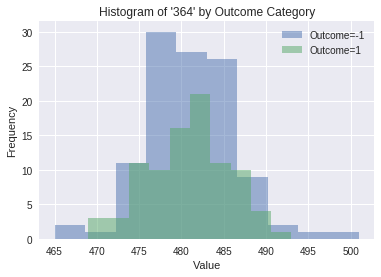

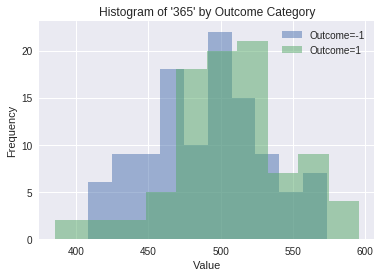

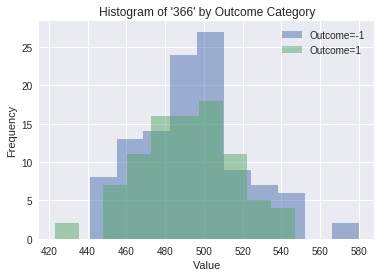

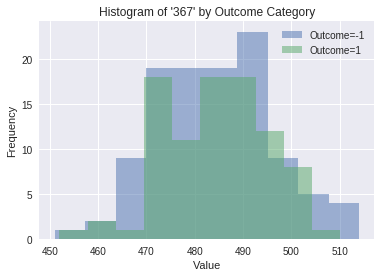

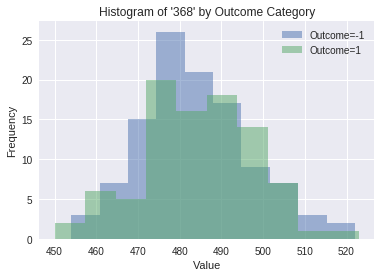

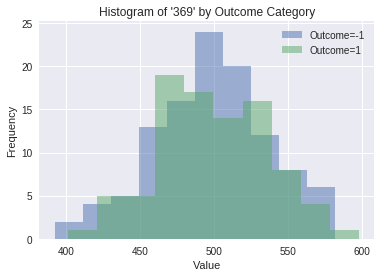

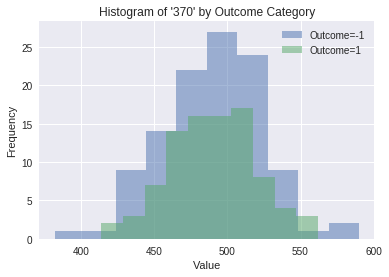

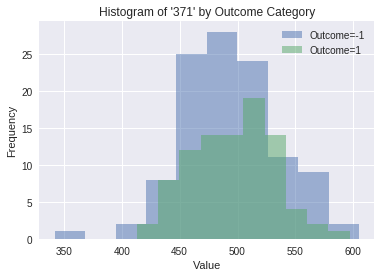

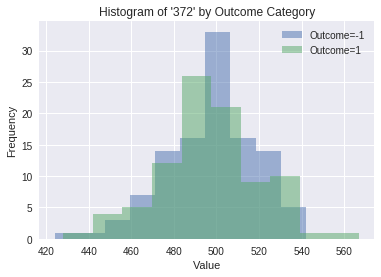

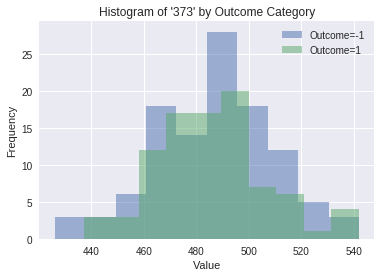

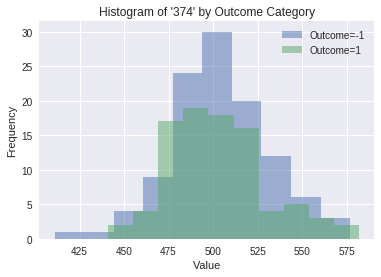

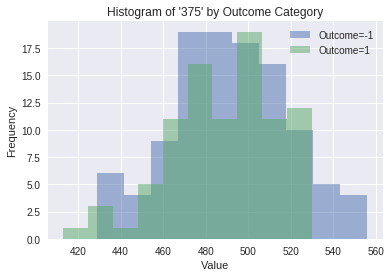

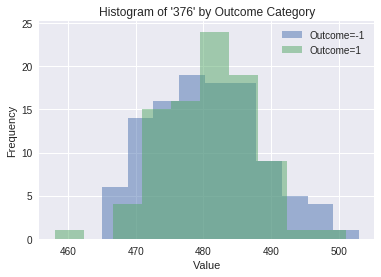

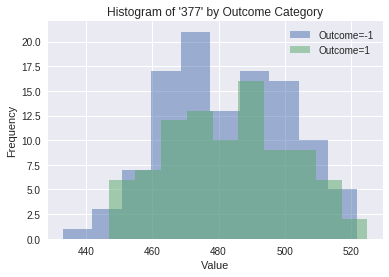

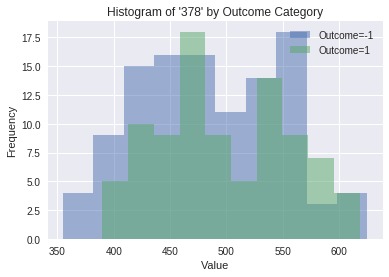

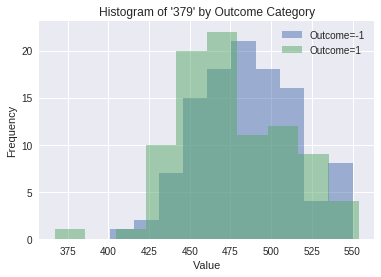

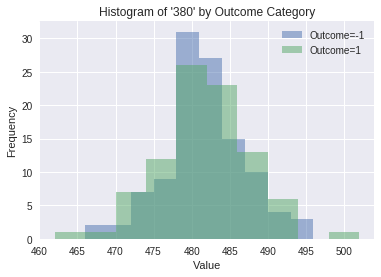

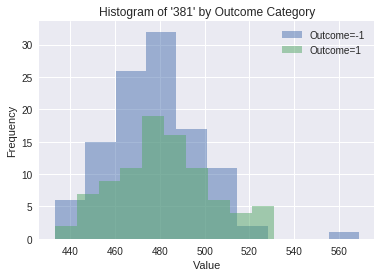

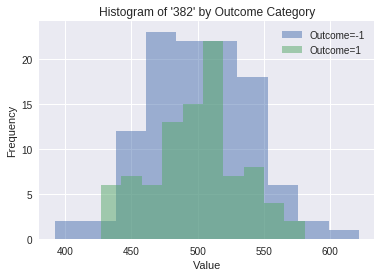

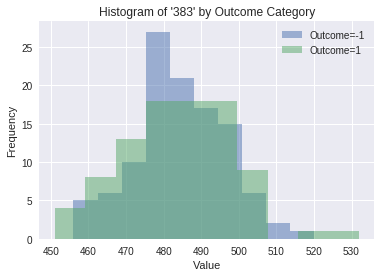

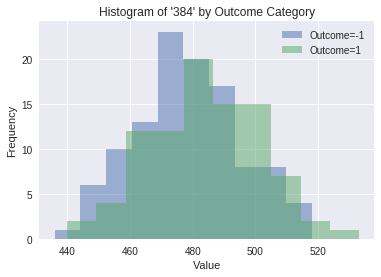

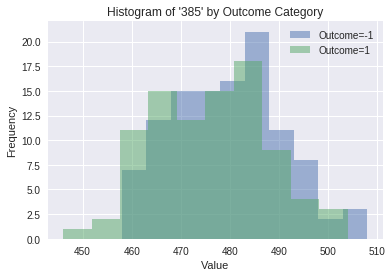

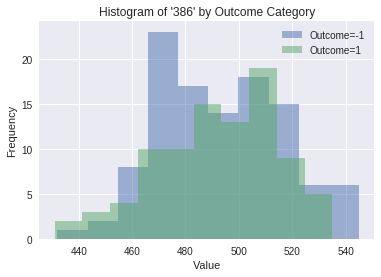

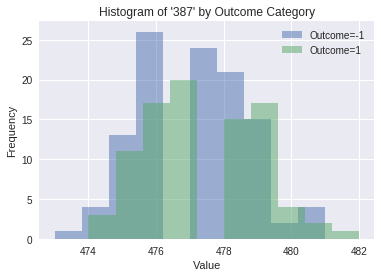

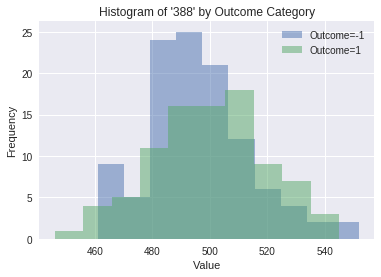

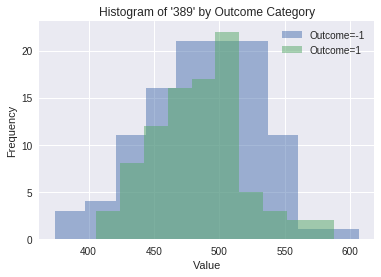

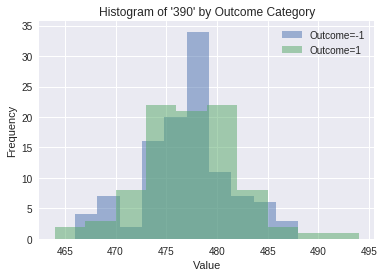

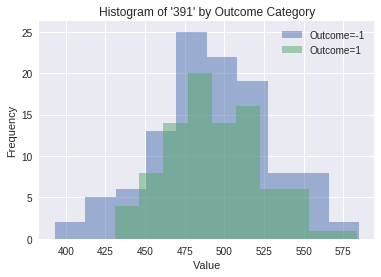

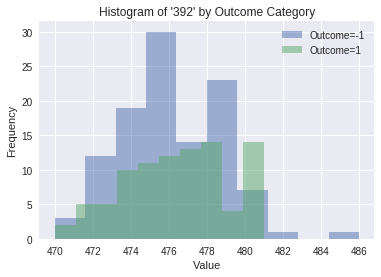

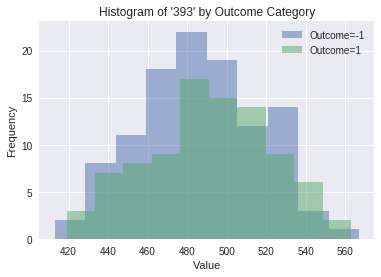

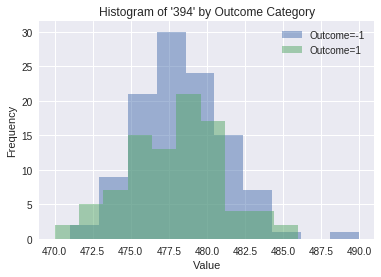

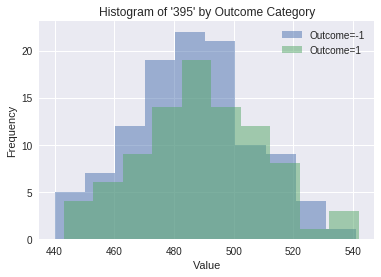

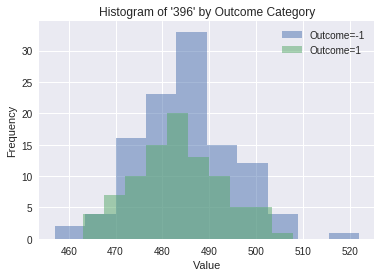

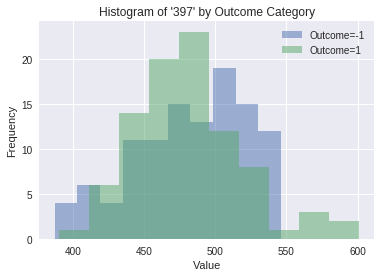

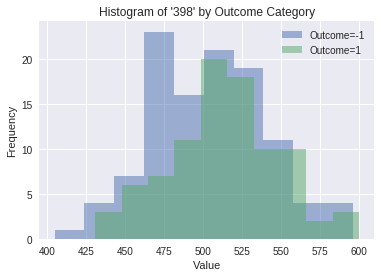

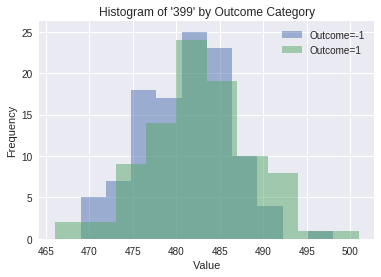

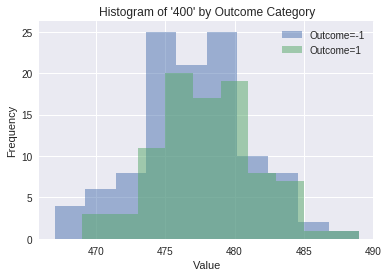

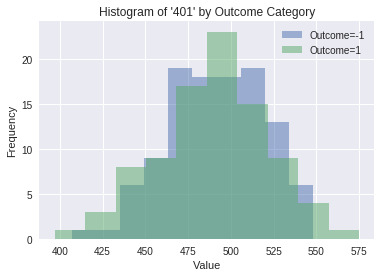

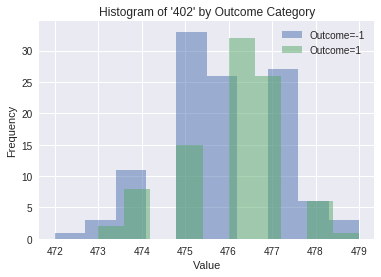

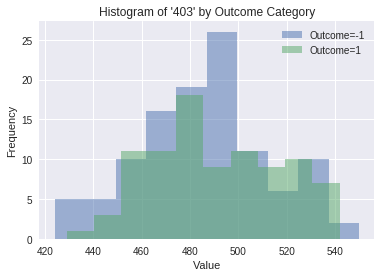

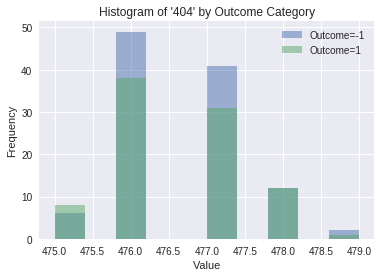

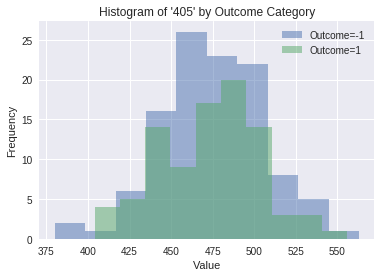

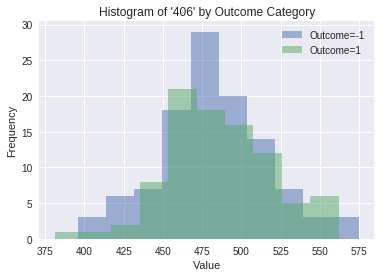

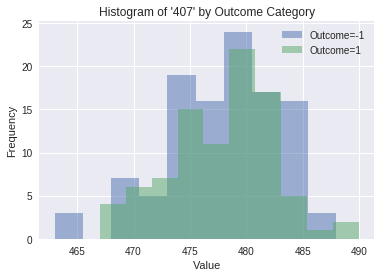

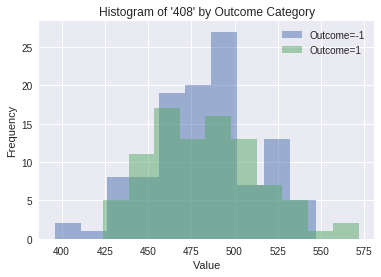

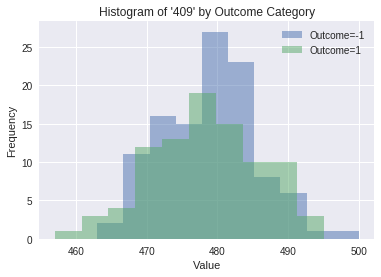

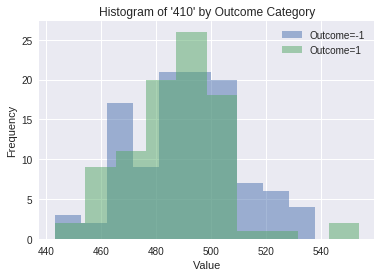

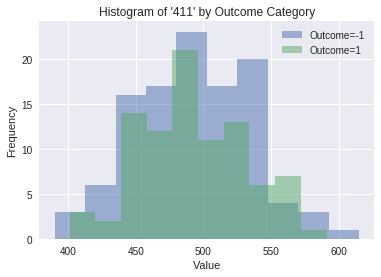

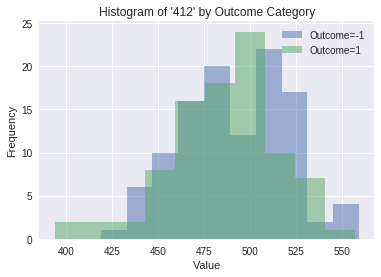

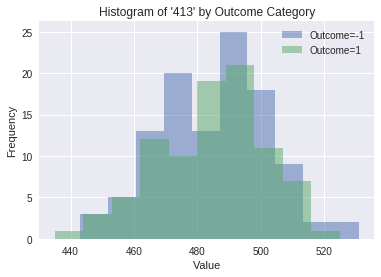

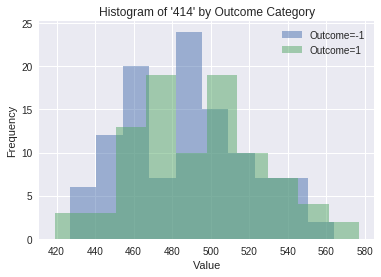

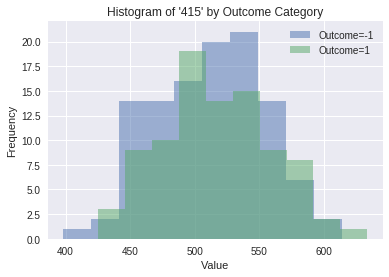

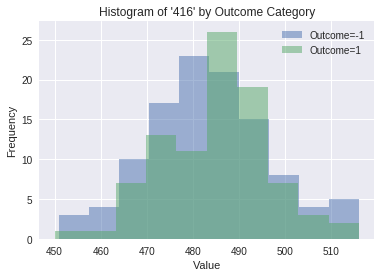

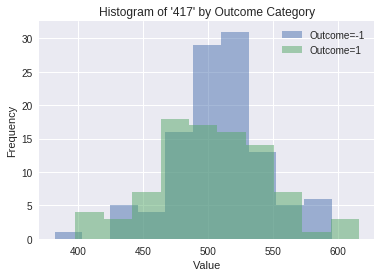

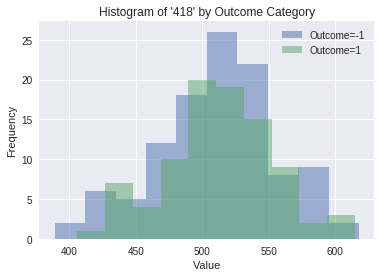

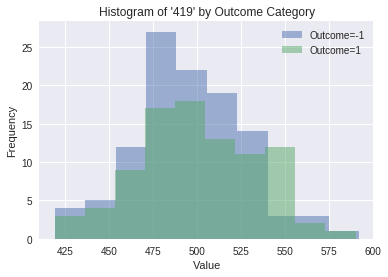

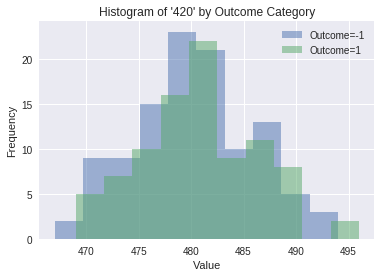

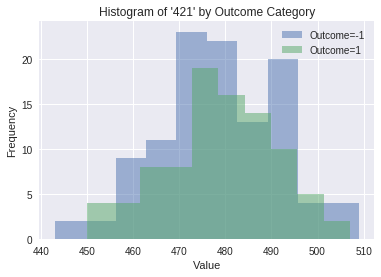

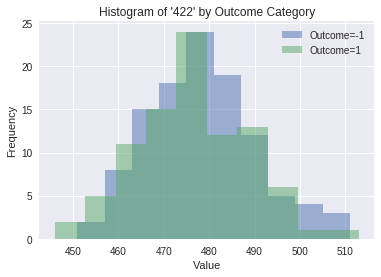

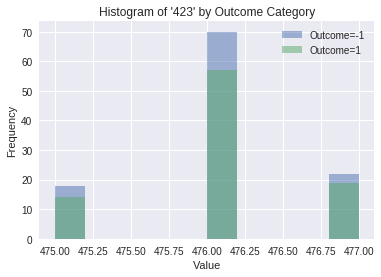

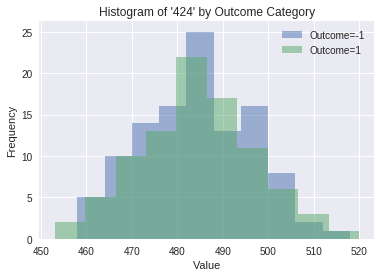

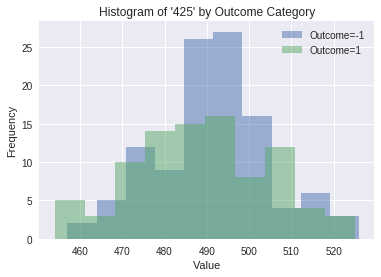

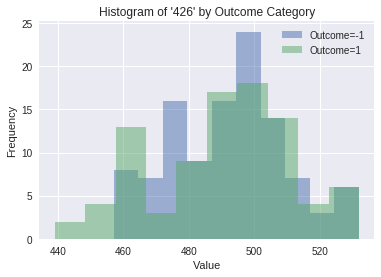

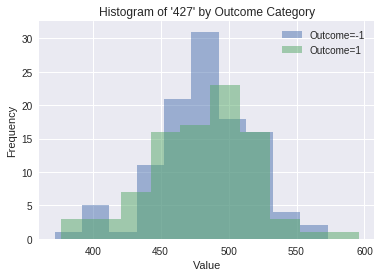

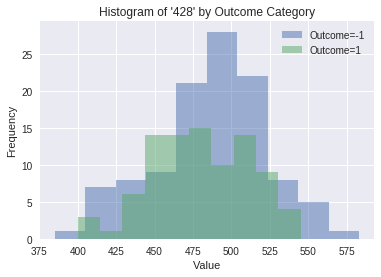

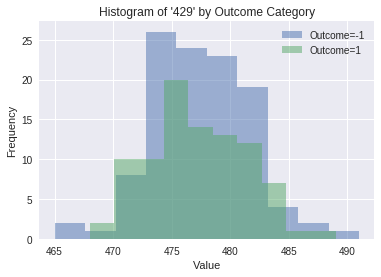

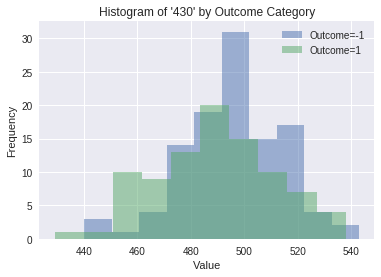

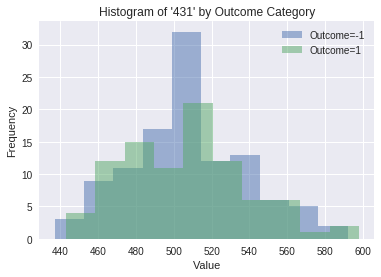

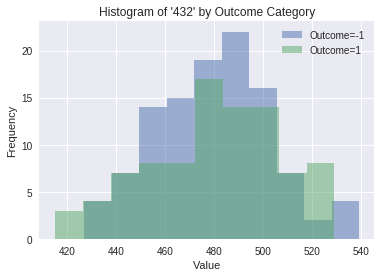

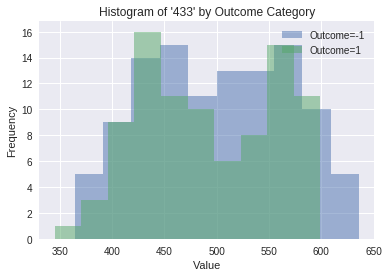

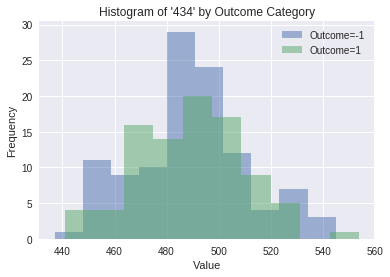

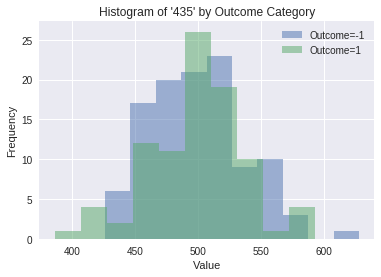

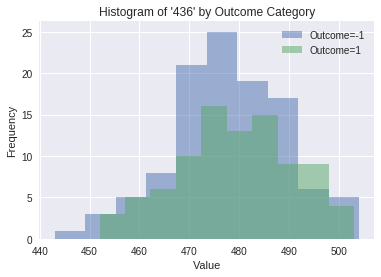

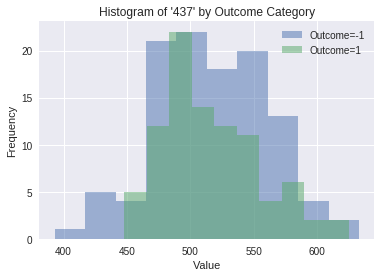

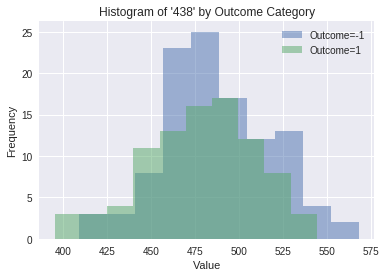

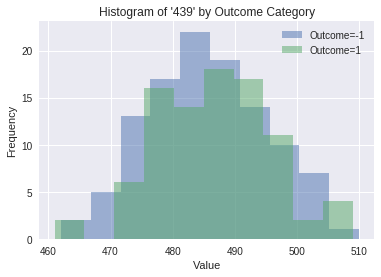

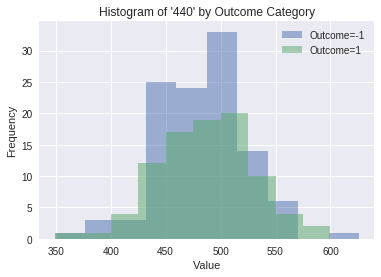

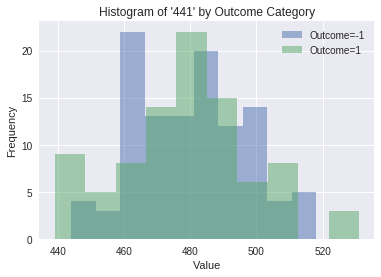

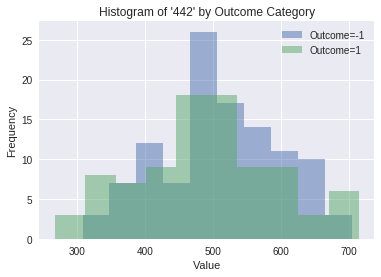

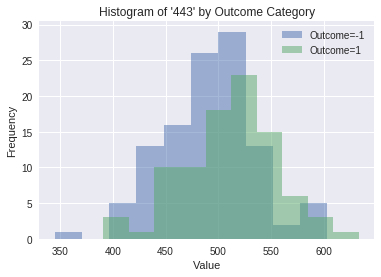

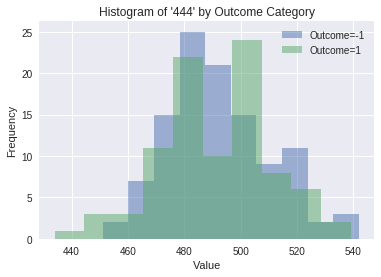

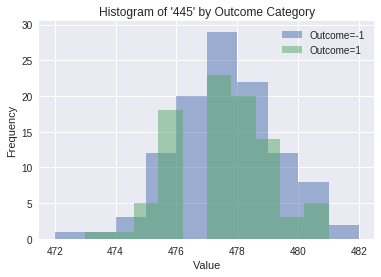

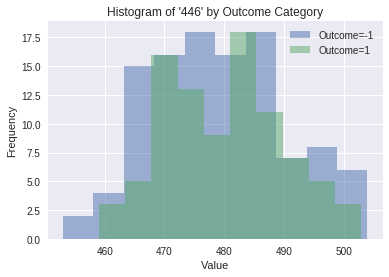

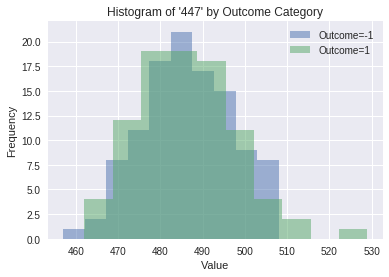

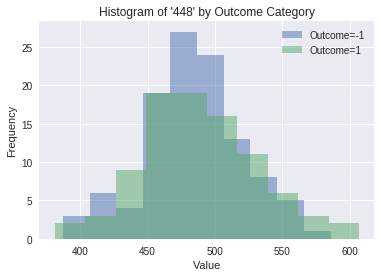

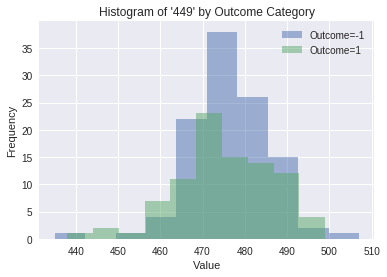

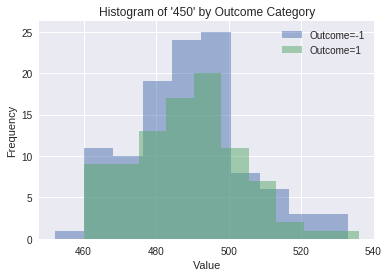

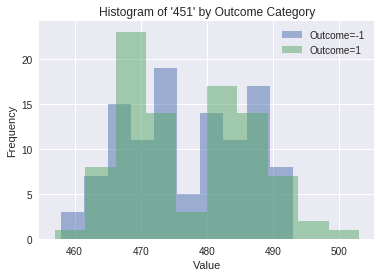

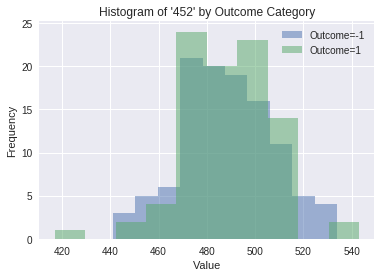

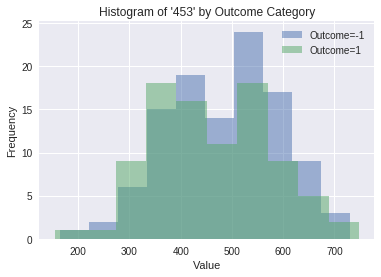

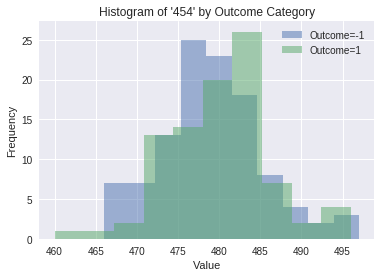

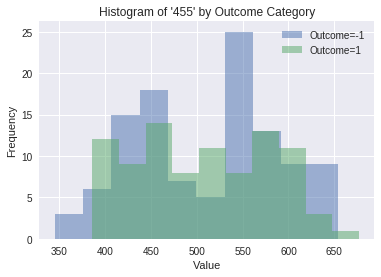

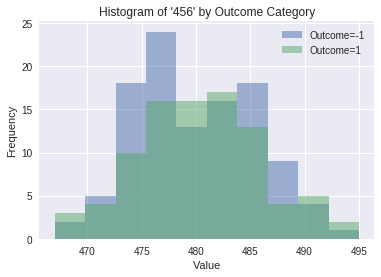

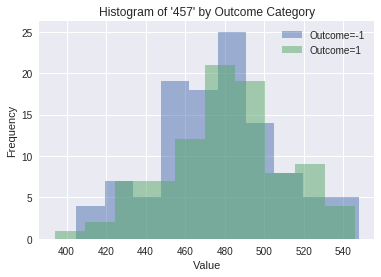

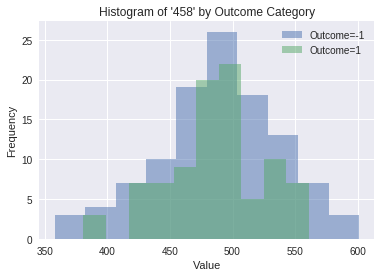

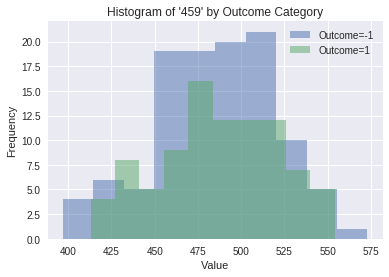

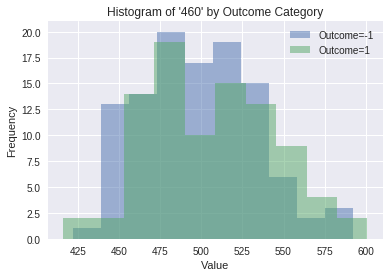

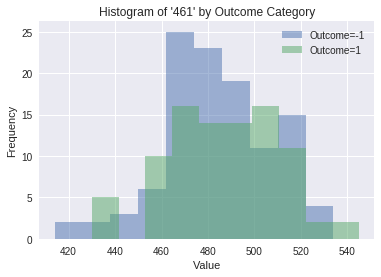

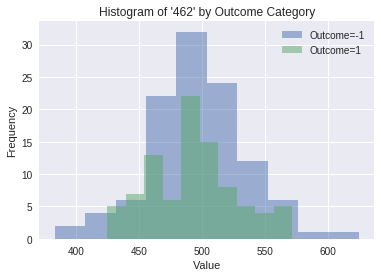

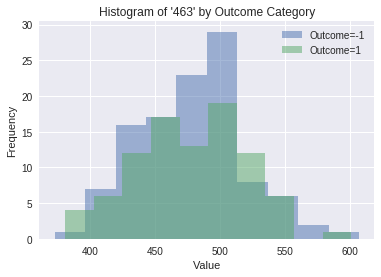

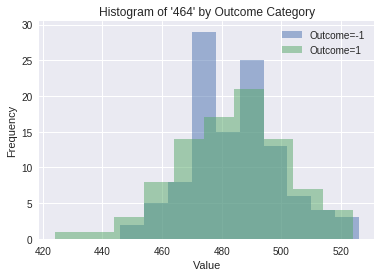

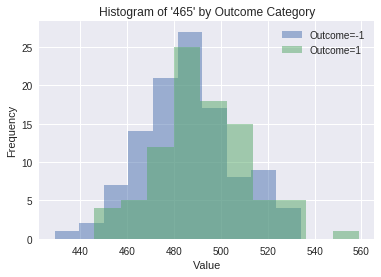

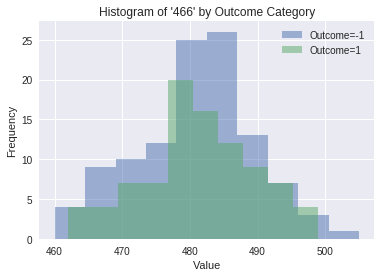

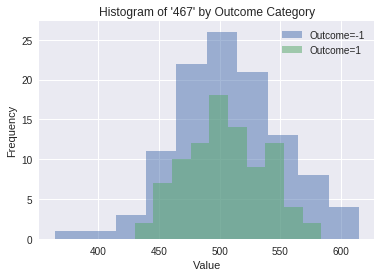

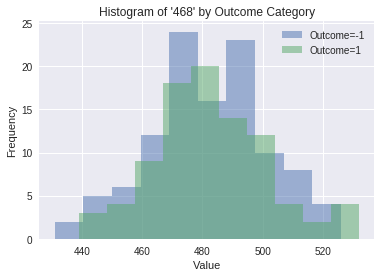

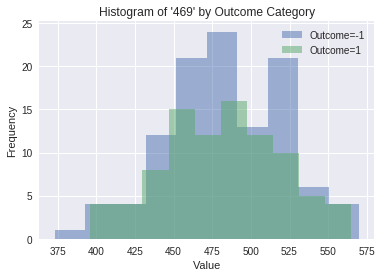

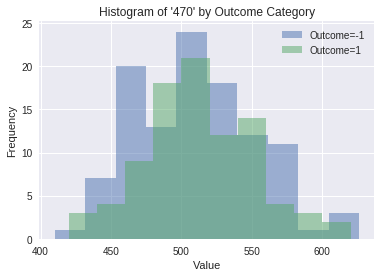

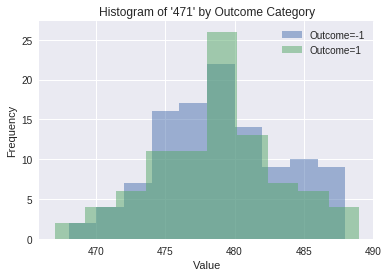

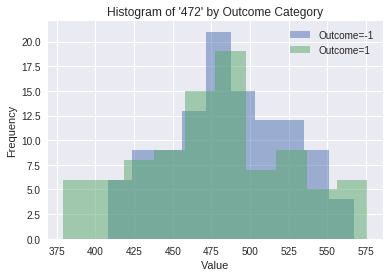

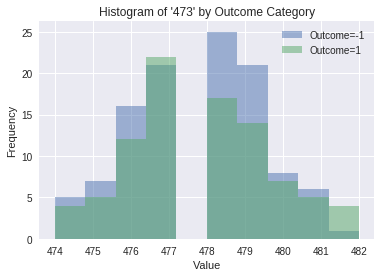

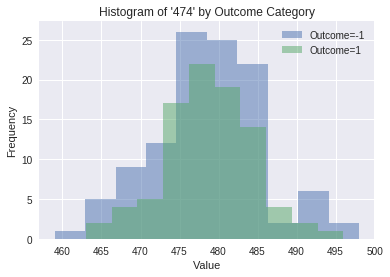

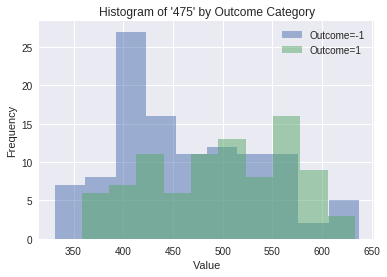

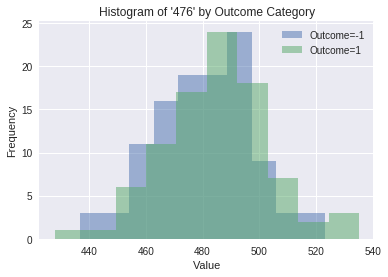

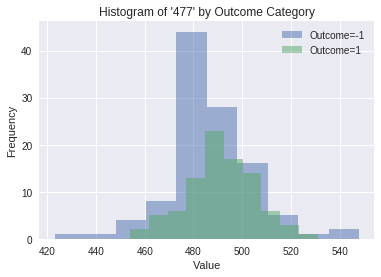

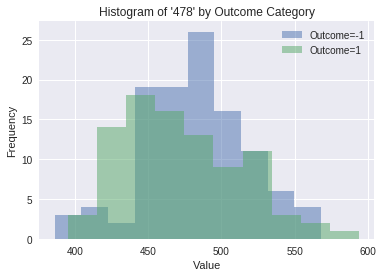

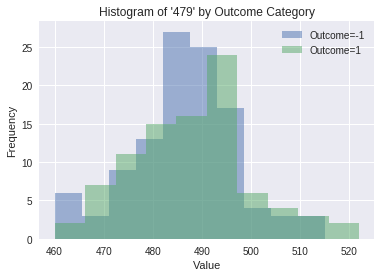

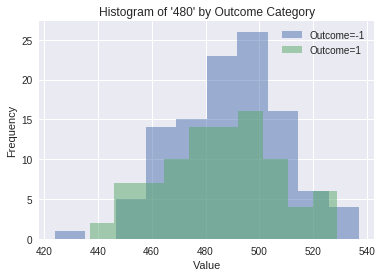

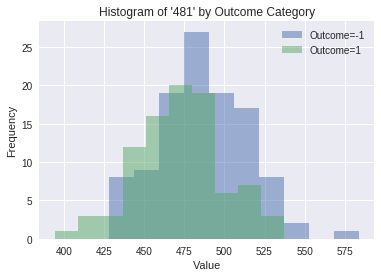

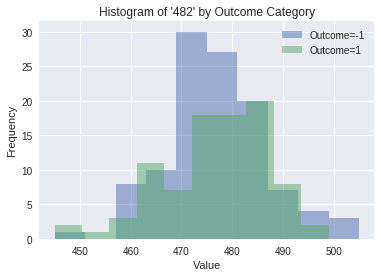

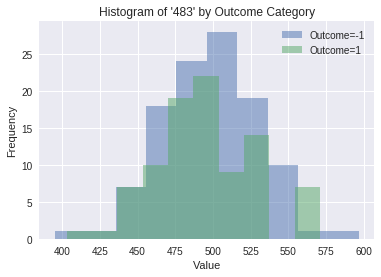

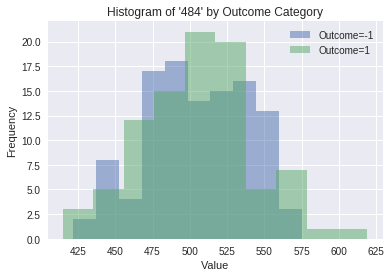

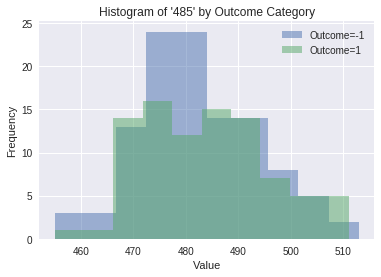

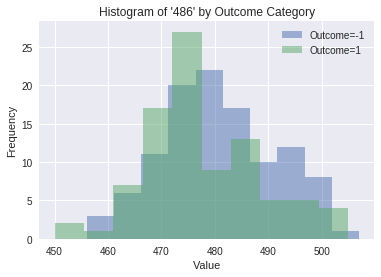

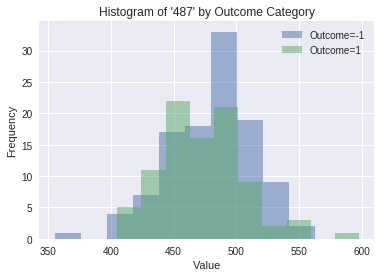

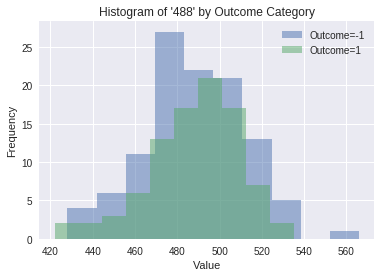

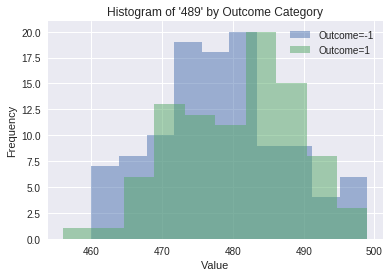

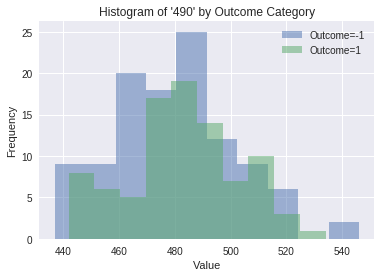

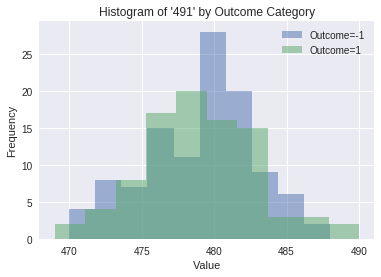

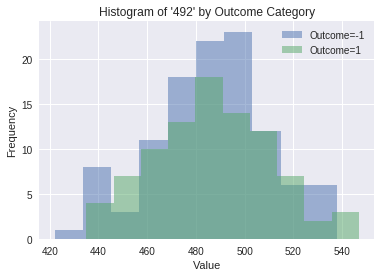

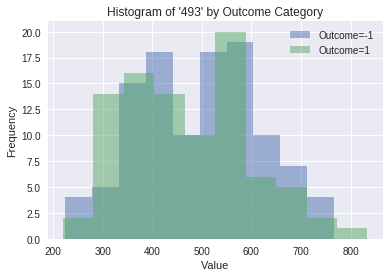

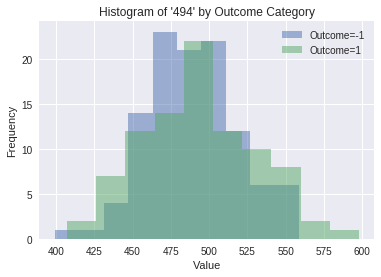

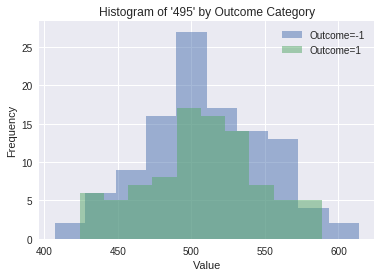

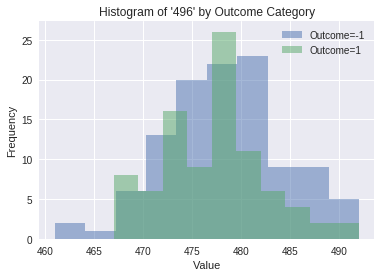

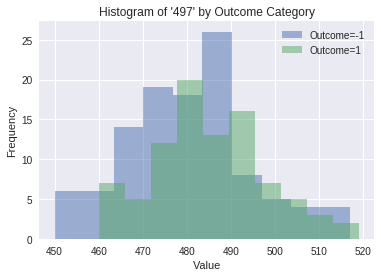

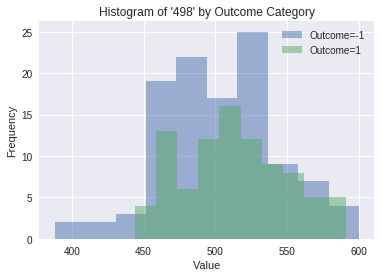

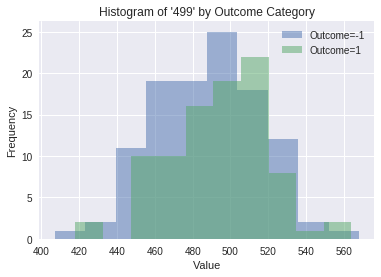

KeyError: 500

In [123]:
for n in range(0,501):
    plot_histogram_dv(sample_1_X[n],sample_1_y)

A lot of them does show more of normal distribution while some features like 332, 404, 423 showed more of noisy unbalanced distribution. With feature size with this big, not a distintive intuition was given per feature but surely there seems to be noisy features. However, skewness does not seem to be a major theme in this sample.

# Step 1: Benchmark Models

We will create 4 base naive fit models for benchmarking purpose.

 Logistic Regression
 - We will utilize high C of 10000 in order to generate benchmark model with low regularization. 

In [9]:
lr_steps = (
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(C=10000)),
)

lr_pipe = Pipeline(lr_steps)

sample_1_lr_fit = lr_pipe.fit(sample_1_X, sample_1_y)
sample_2_lr_fit = lr_pipe.fit(sample_2_X, sample_2_y)
sample_3_lr_fit = lr_pipe.fit(sample_3_X, sample_3_y)

In [10]:
lr_pipe.fit(train_data, label).score(train_data, label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.74250000000000005

In [11]:
lr_pipe.fit(test_data, test_y).score(test_data, test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

We will take the accuracy score of each sample and take the mean.

In [12]:
mean_naive_log = (lr_pipe.score(sample_1_X, sample_1_y) + lr_pipe.score(sample_2_X, sample_2_y) + lr_pipe.score(sample_3_X, sample_3_y))/3

In [13]:
'Mean score for naive Logistic Regression:{}'.format(mean_naive_log)

'Mean score for naive Logistic Regression:0.5483333333333333'

 Decision Tree

In [14]:
tree_steps = (
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier()),
)

tree_pipe = Pipeline(tree_steps)

sample_1_tree_fit = tree_pipe.fit(sample_1_X, sample_1_y)
sample_2_tree_fit = tree_pipe.fit(sample_2_X, sample_2_y)
sample_3_tree_fit = tree_pipe.fit(sample_3_X, sample_3_y)

In [15]:
mean_naive_tree = (tree_pipe.score(sample_1_X, sample_1_y) + tree_pipe.score(sample_2_X, sample_2_y) + tree_pipe.score(sample_3_X, sample_3_y))/3

In [16]:
'Mean score for naive Decision Tree:{}'.format(mean_naive_tree)

'Mean score for naive Decision Tree:0.6916666666666668'

In [17]:
tree_pipe.fit(train_data,label).score(train_data,label)

1.0

In [18]:
tree_pipe.fit(test_data, test_y).score(test_data, test_y)

1.0

K Nearest Neighboors

In [19]:
knn_steps = (
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
)

knn_pipe = Pipeline(knn_steps)

sample_1_knn_fit = knn_pipe.fit(sample_1_X, sample_1_y)
sample_2_knn_fit = knn_pipe.fit(sample_2_X, sample_2_y)
sample_3_knn_fit = knn_pipe.fit(sample_3_X, sample_3_y)

In [20]:
mean_naive_knn = (knn_pipe.score(sample_1_X, sample_1_y) + knn_pipe.score(sample_2_X, sample_2_y) + knn_pipe.score(sample_3_X, sample_3_y))/3

In [21]:
'Mean score for naive K Nearest Neighboors:{}'.format(mean_naive_knn)

'Mean score for naive K Nearest Neighboors:0.6016666666666667'

In [22]:
knn_pipe.fit(train_data, label).score(train_data, label)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.72899999999999998

In [23]:
knn_pipe.fit(test_data, test_y).score(test_data, test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.72999999999999998

Support Vector Classifier
   - we will again use C of 10000 for minimal regularization

In [148]:
svc_steps = (
    ("scaler", StandardScaler()),
    ("svc", SVC(C=10000))
)

svc_pipe = Pipeline(svc_steps)

sample_1_svc_fit = svc_pipe.fit(sample_1_X, sample_1_y)
sample_2_svc_fit = svc_pipe.fit(sample_2_X, sample_2_y)
sample_3_svc_fit = svc_pipe.fit(sample_3_X, sample_3_y)

In [25]:
mean_naive_svc = (svc_pipe.score(sample_1_X, sample_1_y) + svc_pipe.score(sample_2_X, sample_2_y) + svc_pipe.score(sample_3_X, sample_3_y))/3

In [26]:
'Mean score for naive Support Vector Classifier:{}'.format(mean_naive_svc)

'Mean score for naive Support Vector Classifier:0.7416666666666667'

In [27]:
svc_pipe.fit(train_data, label).score(train_data,label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

In [28]:
svc_pipe.fit(test_data, test_y).score(test_data, test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1.0

# Step 2: Identify the noise in the data through feature selection

- Utilize various feature selection methods to identify salient features.

### Method #1: Select K Best feature selection with f_classif scoring

In [9]:
k_steps = (
    ("scaler", StandardScaler()),
    ("feature_select", SelectKBest()),   
)

k_pipe = Pipeline(k_steps)

sample_1_k_pipe_fit = k_pipe.fit(sample_1_X, sample_1_y)
sample_2_k_pipe_fit = k_pipe.fit(sample_2_X, sample_2_y)
sample_3_k_pipe_fit = k_pipe.fit(sample_3_X, sample_3_y)

Let's find the features with less than 0.05 of p-value. The p-value here indicates the probability that this feature and target has no indication of interaction. 


In [10]:
sample_1_under_5 = (sample_1_k_pipe_fit.named_steps["feature_select"].pvalues_< 0.05)

sample_1_under_list=[]
for i, value in enumerate(sample_1_under_5):
    if value == True:
        sample_1_under_list.append(i)

In [11]:
sample_2_under_5 = (sample_2_k_pipe_fit.named_steps["feature_select"].pvalues_< 0.05)

sample_2_under_list=[]
for i, value in enumerate(sample_2_under_5):
    if value == True:
        sample_2_under_list.append(i)

In [12]:
sample_3_under_5 = (sample_3_k_pipe_fit.named_steps["feature_select"].pvalues_< 0.05)

sample_3_under_list=[]
for i, value in enumerate(sample_3_under_5):
    if value == True:
        sample_3_under_list.append(i)

We will create a table to check with the results were consistent across the samples.

In [13]:
k_best_results={}

In [14]:
k_best_results['sample1']=sample_1_under_list
k_best_results['sample2']=sample_2_under_list
k_best_results['sample3']=sample_3_under_list

In [15]:
k_best_results_df = pd.DataFrame(k_best_results)
k_best_results_df.T

0   1   2   3   4    5    6    7    8    9  ...    16   17   18   19  \
sample1  35  49  53  55  64  129  141  152  155  168 ...   302  316  317  336   
sample2  35  49  53  55  64  129  141  152  155  168 ...   302  316  317  336   
sample3  35  49  53  55  64  129  141  152  155  168 ...   302  316  317  336   

          20   21   22   23   24   25  
sample1  352  354  365  373  380  475  
sample2  352  354  365  373  380  475  
sample3  352  354  365  373  380  475  

[3 rows x 26 columns]

In [16]:
sample_1_under_list == sample_2_under_list == sample_3_under_list

True

Indeed, the results were indentical.

### Method #2: Feature selection through Lasso penalty ( l1 )

#### Parameters to be used:
- l1 for Lasso penalty
- 100 for number of different regularization strenghts.
- 10 for number of cross-validation folds
- 'liblinear' for solver as it is required for the Lasso penalty

In [17]:
logiscv_steps = (
    ("scaler", StandardScaler()),
    ("feature_select", LogisticRegressionCV(Cs= 100 , cv=10, penalty='l1', solver ='liblinear'))
)

logiscv_pipe = Pipeline(logiscv_steps)

sample_1_logiscv_pipe_fit = logiscv_pipe.fit(sample_1_X, sample_1_y)
sample_2_logiscv_pipe_fit = logiscv_pipe.fit(sample_2_X, sample_2_y)
sample_3_logiscv_pipe_fit = logiscv_pipe.fit(sample_3_X, sample_3_y)

We are going to take absolute value of coefficient for each feature and rank them. We are going to pick top 30 of them and compare the results with Select K Best results.

In [18]:
sample_1_logiscv_coef = sample_1_logiscv_pipe_fit.named_steps['feature_select'].coef_
sample_2_logiscv_coef = sample_2_logiscv_pipe_fit.named_steps['feature_select'].coef_
sample_3_logiscv_coef = sample_3_logiscv_pipe_fit.named_steps['feature_select'].coef_

We will store these values in the dataframe and sort out top 30 of the strongest logistic regression coefficients. 

In [19]:
sample_1_coef_df = pd.DataFrame(sample_1_logiscv_coef, columns=sample_1_X.columns)
sample_1_coef_df_t = sample_1_coef_df.transpose()
sample_1_coef_df_t.columns = ['absolute_coef']
sample_1_lasso_df = sample_1_coef_df_t.abs().sort_values('absolute_coef',ascending = False)
sample_1_lasso_columns = sample_1_lasso_df.transpose().columns[:30]

In [20]:
sample_1_lasso_columns

Index([ 49, 302,  34,  80, 129, 373, 365, 333, 155, 380, 102, 264, 262, 492,
       133,  31,  55, 316, 170, 315, 434, 317, 322, 210, 141, 286, 138, 205,
       132, 402],
      dtype='object')

In [21]:
sample_1_lasso_df

absolute_coef
49        0.661749
302       0.659064
34        0.616381
80        0.598038
129       0.579375
373       0.563103
365       0.551978
333       0.535686
155       0.472118
380       0.433799
102       0.415850
264       0.414365
262       0.402087
492       0.391772
133       0.375296
31        0.373369
55        0.361117
316       0.360786
170       0.333325
315       0.328342
434       0.327664
317       0.318134
322       0.289643
210       0.266221
141       0.266037
286       0.265614
138       0.261726
205       0.259480
132       0.253035
402       0.248063
..             ...
160       0.000000
157       0.000000
156       0.000000
188       0.000000
189       0.000000
191       0.000000
206       0.000000
217       0.000000
216       0.000000
215       0.000000
214       0.000000
213       0.000000
212       0.000000
211       0.000000
209       0.000000
208       0.000000
207       0.000000
204       0.000000
193       0.000000
203       0.000000
202       0.000000
201       0.000000
200       0.000000
199       0.000000
198       0.000000
197       0.000000
196       0.000000
195       0.000000
194       0.000000
250       0.000000

[500 rows x 1 columns]

In [22]:
sample_2_coef_df = pd.DataFrame(sample_2_logiscv_coef, columns=train_data.columns)
sample_2_coef_df_t = sample_2_coef_df.transpose()
sample_2_coef_df_t.columns = ['absolute_coef']
sample_2_lasso_df = sample_2_coef_df_t.abs().sort_values('absolute_coef',ascending = False)
sample_2_lasso_columns = sample_2_lasso_df.transpose().columns[:30]

In [23]:
sample_2_lasso_columns

Int64Index([ 49, 302,  34,  80, 129, 373, 365, 333, 155, 380, 102, 264, 262,
            492, 133,  31,  55, 316, 170, 315, 434, 317, 322, 210, 141, 286,
            138, 205, 132, 402],
           dtype='int64')

In [23]:
sample_2_lasso_df

absolute_coef
49        0.663035
302       0.659764
34        0.616569
80        0.597773
129       0.579117
373       0.563276
365       0.550036
333       0.536962
155       0.472527
380       0.433974
102       0.415587
264       0.413681
262       0.402566
492       0.392359
133       0.374588
31        0.374443
55        0.361664
316       0.359530
170       0.332404
315       0.328568
434       0.327710
317       0.318661
322       0.290449
141       0.266293
210       0.266275
286       0.265948
138       0.262258
205       0.258631
132       0.252633
402       0.247182
..             ...
160       0.000000
157       0.000000
156       0.000000
188       0.000000
189       0.000000
191       0.000000
206       0.000000
217       0.000000
216       0.000000
215       0.000000
214       0.000000
213       0.000000
212       0.000000
211       0.000000
209       0.000000
208       0.000000
207       0.000000
204       0.000000
193       0.000000
203       0.000000
202       0.000000
201       0.000000
200       0.000000
199       0.000000
198       0.000000
197       0.000000
196       0.000000
195       0.000000
194       0.000000
250       0.000000

[500 rows x 1 columns]

In [24]:
sample_3_coef_df = pd.DataFrame(sample_3_logiscv_coef, columns=train_data.columns)
sample_3_coef_df_t = sample_3_coef_df.transpose()
sample_3_coef_df_t.columns = ['absolute_coef']
sample_3_lasso_df = sample_3_coef_df_t.abs().sort_values('absolute_coef',ascending = False)
sample_3_lasso_columns = sample_3_lasso_df.transpose().columns[:30]

In [25]:
sample_3_lasso_columns

Int64Index([ 49, 302,  34,  80, 129, 373, 365, 333, 155, 380, 102, 264, 262,
            492, 133,  31,  55, 316, 170, 315, 434, 317, 322, 141, 210, 286,
            138, 205, 132, 402],
           dtype='int64')

In [26]:
sample_3_lasso_df

absolute_coef
49        0.663035
302       0.659764
34        0.616569
80        0.597773
129       0.579117
373       0.563276
365       0.550036
333       0.536962
155       0.472527
380       0.433974
102       0.415587
264       0.413681
262       0.402566
492       0.392359
133       0.374588
31        0.374443
55        0.361664
316       0.359530
170       0.332404
315       0.328568
434       0.327710
317       0.318661
322       0.290449
141       0.266293
210       0.266275
286       0.265948
138       0.262258
205       0.258631
132       0.252633
402       0.247182
..             ...
160       0.000000
157       0.000000
156       0.000000
188       0.000000
189       0.000000
191       0.000000
206       0.000000
217       0.000000
216       0.000000
215       0.000000
214       0.000000
213       0.000000
212       0.000000
211       0.000000
209       0.000000
208       0.000000
207       0.000000
204       0.000000
193       0.000000
203       0.000000
202       0.000000
201       0.000000
200       0.000000
199       0.000000
198       0.000000
197       0.000000
196       0.000000
195       0.000000
194       0.000000
250       0.000000

[500 rows x 1 columns]

In [27]:
lasso_best_results = {}
lasso_best_results['sample1']=sample_1_lasso_columns
lasso_best_results['sample2']=sample_2_lasso_columns
lasso_best_results['sample3']=sample_3_lasso_columns

lasso_best_results_df = pd.DataFrame(lasso_best_results)
lasso_best_results_df

sample1  sample2  sample3
0       49       49       49
1      302      302      302
2       34       34       34
3       80       80       80
4      129      129      129
5      373      373      373
6      365      365      365
7      333      333      333
8      155      155      155
9      380      380      380
10     102      102      102
11     264      264      264
12     262      262      262
13     492      492      492
14     133      133      133
15      31       31       31
16      55       55       55
17     316      316      316
18     170      170      170
19     315      315      315
20     434      434      434
21     317      317      317
22     322      322      322
23     141      141      141
24     210      210      210
25     286      286      286
26     138      138      138
27     205      205      205
28     132      132      132
29     402      402      402

In [28]:
lasso_best_results_df.T

0    1   2   3    4    5    6    7    8    9  ...    20   21   22  \
sample1  49  302  34  80  129  373  365  333  155  380 ...   434  317  322   
sample2  49  302  34  80  129  373  365  333  155  380 ...   434  317  322   
sample3  49  302  34  80  129  373  365  333  155  380 ...   434  317  322   

          23   24   25   26   27   28   29  
sample1  141  210  286  138  205  132  402  
sample2  141  210  286  138  205  132  402  
sample3  141  210  286  138  205  132  402  

[3 rows x 30 columns]

Let's sort the features in the order of their index for comparison purpose

In [29]:
lasso_best_results_s = {}
lasso_best_results_s['sample1']=sample_1_lasso_columns.sort_values()
lasso_best_results_s['sample2']=sample_2_lasso_columns.sort_values()
lasso_best_results_s['sample3']=sample_3_lasso_columns.sort_values()

lasso_best_results_s_df = pd.DataFrame(lasso_best_results_s)
lasso_best_results_s_df

sample1  sample2  sample3
0       31       31       31
1       34       34       34
2       49       49       49
3       55       55       55
4       80       80       80
5      102      102      102
6      129      129      129
7      132      132      132
8      133      133      133
9      138      138      138
10     141      141      141
11     155      155      155
12     170      170      170
13     205      205      205
14     210      210      210
15     262      262      262
16     264      264      264
17     286      286      286
18     302      302      302
19     315      315      315
20     316      316      316
21     317      317      317
22     322      322      322
23     333      333      333
24     365      365      365
25     373      373      373
26     380      380      380
27     402      402      402
28     434      434      434
29     492      492      492

### Method #3 Select from model using LogisticRegression

In [24]:
sfm_log_steps = (
    ("scaler", StandardScaler()),
    ("sfm", SelectFromModel(estimator= LogisticRegression(), threshold='mean'))
)

sfm_log_pipe = Pipeline(sfm_log_steps)

sample_1_sfm_log_fit = sfm_log_pipe.fit(sample_1_X, sample_1_y)
sample_2_sfm_log_fit = sfm_log_pipe.fit(sample_2_X, sample_2_y)
sample_3_sfm_log_fit = sfm_log_pipe.fit(sample_3_X, sample_3_y)

In [25]:
sample_1_sfm_log_feature = np.where(sample_1_sfm_log_fit.named_steps['sfm'].get_support())[0]

In [26]:
sample_2_sfm_log_feature = np.where(sample_2_sfm_log_fit.named_steps['sfm'].get_support())[0]

In [27]:
sample_3_sfm_log_feature = np.where(sample_3_sfm_log_fit.named_steps['sfm'].get_support())[0]

In [28]:
sfm_log_best_results = {}
sfm_log_best_results['sample1']= sample_1_sfm_log_feature
sfm_log_best_results['sample2']= sample_2_sfm_log_feature
sfm_log_best_results['sample3']= sample_3_sfm_log_feature

sfm_log_best_results_df = pd.DataFrame(sfm_log_best_results)
sfm_log_best_results_df

sample1  sample2  sample3
0          4        4        4
1          5        5        5
2          6        6        6
3         10       10       10
4         12       12       12
5         13       13       13
6         16       16       16
7         18       18       18
8         21       21       21
9         25       25       25
10        29       29       29
11        31       31       31
12        32       32       32
13        33       33       33
14        34       34       34
15        35       35       35
16        36       36       36
17        37       37       37
18        38       38       38
19        46       46       46
20        49       49       49
21        51       51       51
22        52       52       52
23        53       53       53
24        54       54       54
25        55       55       55
26        56       56       56
27        61       61       61
28        63       63       63
29        64       64       64
..       ...      ...      ...
186      423      423      423
187      424      424      424
188      434      434      434
189      438      438      438
190      441      441      441
191      443      443      443
192      445      445      445
193      446      446      446
194      450      450      450
195      454      454      454
196      457      457      457
197      460      460      460
198      462      462      462
199      465      465      465
200      467      467      467
201      470      470      470
202      474      474      474
203      475      475      475
204      477      477      477
205      481      481      481
206      483      483      483
207      486      486      486
208      487      487      487
209      492      492      492
210      494      494      494
211      495      495      495
212      496      496      496
213      497      497      497
214      498      498      498
215      499      499      499

[216 rows x 3 columns]

In [35]:
sfm_log_best_results_df.T

0    1    2    3    4    5    6    7    8    9   ...   206  207  208  \
sample1    4    5    6   10   12   13   16   18   21   25 ...   483  486  487   
sample2    4    5    6   10   12   13   16   18   21   25 ...   483  486  487   
sample3    4    5    6   10   12   13   16   18   21   25 ...   483  486  487   

         209  210  211  212  213  214  215  
sample1  492  494  495  496  497  498  499  
sample2  492  494  495  496  497  498  499  
sample3  492  494  495  496  497  498  499  

[3 rows x 216 columns]

### Method #4 Select From Model using Decision Tree Classifier

In [29]:
sfm_tree_steps = (
    ("scaler", StandardScaler()),
    ("sfm", SelectFromModel(estimator= DecisionTreeClassifier()))
)

sfm_tree_pipe = Pipeline(sfm_tree_steps)


sample_1_sfm_tree_fit = sfm_tree_pipe.fit(sample_1_X, sample_1_y)
sample_2_sfm_tree_fit = sfm_tree_pipe.fit(sample_2_X, sample_2_y)
sample_3_sfm_tree_fit = sfm_tree_pipe.fit(sample_3_X, sample_3_y)

In [30]:
sample_1_sfm_tree_feature = np.where(sample_1_sfm_tree_fit.named_steps['sfm'].get_support())[0]

In [31]:
sample_2_sfm_tree_feature = np.where(sample_2_sfm_tree_fit.named_steps['sfm'].get_support())[0]

In [32]:
sample_3_sfm_tree_feature = np.where(sample_3_sfm_tree_fit.named_steps['sfm'].get_support())[0]

In [33]:
sfm_tree_best_results = {}
sfm_tree_best_results['sample1']= sample_1_sfm_tree_feature
sfm_tree_best_results['sample2']= sample_2_sfm_tree_feature
sfm_tree_best_results['sample3']= sample_3_sfm_tree_feature

sfm_tree_best_results_df = pd.DataFrame(sfm_tree_best_results)
sfm_tree_best_results_df

sample1  sample2  sample3
0         2        2        2
1        46       46       46
2        48       48       48
3        64       64       64
4        72       72       72
5        83       83       83
6       146      146      146
7       159      159      159
8       170      170      170
9       184      184      184
10      191      191      191
11      197      197      197
12      223      223      223
13      254      254      254
14      256      256      256
15      302      302      302
16      306      306      306
17      341      341      341
18      345      345      345
19      365      365      365
20      415      415      415

In [41]:
sfm_tree_best_results_df.T

0   1   2    3    4    5    6    7    8    9  ...    11   12   13  \
sample1  64  84  92  146  170  181  184  197  218  223 ...   256  261  302   
sample2  64  84  92  146  170  181  184  197  218  223 ...   256  261  302   
sample3  64  84  92  146  170  181  184  197  218  223 ...   256  261  302   

          14   15   16   17   18   19   20  
sample1  305  306  352  361  365  391  415  
sample2  305  306  352  361  365  391  415  
sample3  305  306  352  361  365  391  415  

[3 rows x 21 columns]

### Method #5 Select from Model using Support Vector Classifier

In [34]:
sfm_svc_steps = (
    ("scaler", StandardScaler()),
    ("sfm", SelectFromModel(estimator= SVC(C=0.001, kernel='linear', random_state=42)))
)

sfm_svc_pipe = Pipeline(sfm_svc_steps)


sample_1_sfm_svc_fit = sfm_svc_pipe.fit(sample_1_X, sample_1_y)
sample_2_sfm_svc_fit = sfm_svc_pipe.fit(sample_2_X, sample_2_y)
sample_3_sfm_svc_fit = sfm_svc_pipe.fit(sample_3_X, sample_3_y)

In [35]:
sfm_svc_1 = sample_1_sfm_svc_fit.named_steps['sfm']

In [37]:
sample_1_sfm_svc_feature = np.where(sample_1_sfm_svc_fit.named_steps['sfm'].get_support())[0]

In [38]:
sample_2_sfm_svc_feature = np.where(sample_2_sfm_svc_fit.named_steps['sfm'].get_support())[0]

In [39]:
sample_3_sfm_svc_feature = np.where(sample_3_sfm_svc_fit.named_steps['sfm'].get_support())[0]

In [40]:
sfm_svc_best_results = {}
sfm_svc_best_results['sample1']= sample_1_sfm_svc_feature
sfm_svc_best_results['sample2']= sample_2_sfm_svc_feature
sfm_svc_best_results['sample3']= sample_3_sfm_svc_feature

sfm_svc_results_df = pd.DataFrame(sfm_svc_best_results)
sfm_svc_results_df

sample1  sample2  sample3
0          0        0        0
1          3        3        3
2          4        4        4
3          5        5        5
4          6        6        6
5         10       10       10
6         12       12       12
7         16       16       16
8         17       17       17
9         18       18       18
10        20       20       20
11        21       21       21
12        24       24       24
13        29       29       29
14        31       31       31
15        32       32       32
16        34       34       34
17        35       35       35
18        43       43       43
19        46       46       46
20        49       49       49
21        51       51       51
22        53       53       53
23        54       54       54
24        55       55       55
25        56       56       56
26        57       57       57
27        58       58       58
28        61       61       61
29        64       64       64
..       ...      ...      ...
184      424      424      424
185      425      425      425
186      426      426      426
187      431      431      431
188      434      434      434
189      443      443      443
190      446      446      446
191      448      448      448
192      450      450      450
193      453      453      453
194      454      454      454
195      455      455      455
196      460      460      460
197      461      461      461
198      462      462      462
199      465      465      465
200      466      466      466
201      467      467      467
202      468      468      468
203      473      473      473
204      475      475      475
205      477      477      477
206      481      481      481
207      486      486      486
208      491      491      491
209      492      492      492
210      493      493      493
211      495      495      495
212      496      496      496
213      499      499      499

[214 rows x 3 columns]

In [49]:
sfm_svc_results_df.T

0    1    2    3    4    5    6    7    8    9   ...   204  205  206  \
sample1    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   
sample2    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   
sample3    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   

         207  208  209  210  211  212  213  
sample1  486  491  492  493  495  496  499  
sample2  486  491  492  493  495  496  499  
sample3  486  491  492  493  495  496  499  

[3 rows x 214 columns]

### Method #6 Select from Model using K Nearest Neighbor Classifier

In [41]:
sfm_knn_steps = (
    ("scaler", StandardScaler()),
    ("sfm", SelectFromModel(estimator= KNeighborsClassifier())))

sfm_knn_pipe = Pipeline(sfm_svc_steps)


sample_1_sfm_knn_fit = sfm_knn_pipe.fit(sample_1_X, sample_1_y)
sample_2_sfm_knn_fit = sfm_knn_pipe.fit(sample_2_X, sample_2_y)
sample_3_sfm_knn_fit = sfm_knn_pipe.fit(sample_3_X, sample_3_y)

In [42]:
sample_1_sfm_knn_feature = np.where(sample_1_sfm_knn_fit.named_steps['sfm'].get_support())[0]
sample_2_sfm_knn_feature = np.where(sample_2_sfm_knn_fit.named_steps['sfm'].get_support())[0]
sample_3_sfm_knn_feature = np.where(sample_3_sfm_knn_fit.named_steps['sfm'].get_support())[0]

In [43]:
sfm_knn_best_results = {}
sfm_knn_best_results['sample1']= sample_1_sfm_knn_feature
sfm_knn_best_results['sample2']= sample_2_sfm_knn_feature
sfm_knn_best_results['sample3']= sample_3_sfm_knn_feature

sfm_knn_results_df = pd.DataFrame(sfm_knn_best_results)
sfm_knn_results_df

sample1  sample2  sample3
0          0        0        0
1          3        3        3
2          4        4        4
3          5        5        5
4          6        6        6
5         10       10       10
6         12       12       12
7         16       16       16
8         17       17       17
9         18       18       18
10        20       20       20
11        21       21       21
12        24       24       24
13        29       29       29
14        31       31       31
15        32       32       32
16        34       34       34
17        35       35       35
18        43       43       43
19        46       46       46
20        49       49       49
21        51       51       51
22        53       53       53
23        54       54       54
24        55       55       55
25        56       56       56
26        57       57       57
27        58       58       58
28        61       61       61
29        64       64       64
..       ...      ...      ...
184      424      424      424
185      425      425      425
186      426      426      426
187      431      431      431
188      434      434      434
189      443      443      443
190      446      446      446
191      448      448      448
192      450      450      450
193      453      453      453
194      454      454      454
195      455      455      455
196      460      460      460
197      461      461      461
198      462      462      462
199      465      465      465
200      466      466      466
201      467      467      467
202      468      468      468
203      473      473      473
204      475      475      475
205      477      477      477
206      481      481      481
207      486      486      486
208      491      491      491
209      492      492      492
210      493      493      493
211      495      495      495
212      496      496      496
213      499      499      499

[214 rows x 3 columns]

In [44]:
sfm_knn_results_df.T

0    1    2    3    4    5    6    7    8    9   ...   204  205  206  \
sample1    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   
sample2    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   
sample3    0    3    4    5    6   10   12   16   17   18 ...   475  477  481   

         207  208  209  210  211  212  213  
sample1  486  491  492  493  495  496  499  
sample2  486  491  492  493  495  496  499  
sample3  486  491  492  493  495  496  499  

[3 rows x 214 columns]

### Method #7 Recursive Feature Elimination using Logistic Regression

In [45]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe_steps = (
    ("scaler", StandardScaler()),
    ("feature_select", RFECV(LogisticRegression(), step=1,cv=5))
)

rfe_pipe = Pipeline(rfe_steps)

sample_1_rfe_pipe_fit = rfe_pipe.fit(sample_1_X, sample_1_y)
sample_2_rfe_pipe_fit = rfe_pipe.fit(sample_2_X, sample_2_y)
sample_3_rfe_pipe_fit = rfe_pipe.fit(sample_3_X, sample_3_y)

In [46]:
sample_1_rfe_feats = np.where(sample_1_rfe_pipe_fit.named_steps["feature_select"].get_support())[0]

In [47]:
sample_2_rfe_feats = np.where(sample_2_rfe_pipe_fit.named_steps["feature_select"].get_support())[0]

In [48]:
sample_3_rfe_feats = np.where(sample_3_rfe_pipe_fit.named_steps["feature_select"].get_support())[0]

In [49]:
rfe_best_results = {}
rfe_best_results['sample1']= sample_1_rfe_feats
rfe_best_results['sample2']= sample_2_rfe_feats
rfe_best_results['sample3']= sample_3_rfe_feats

rfe_results_df = pd.DataFrame(rfe_best_results)
rfe_results_df

sample1  sample2  sample3
0        31       31       31
1        34       34       34
2        49       49       49
3        55       55       55
4        61       61       61
5        64       64       64
6        85       85       85
7       129      129      129
8       132      132      132
9       133      133      133
10      138      138      138
11      141      141      141
12      155      155      155
13      164      164      164
14      210      210      210
15      220      220      220
16      262      262      262
17      264      264      264
18      302      302      302
19      316      316      316
20      333      333      333
21      348      348      348
22      351      351      351
23      365      365      365
24      373      373      373
25      380      380      380
26      390      390      390
27      467      467      467
28      487      487      487
29      492      492      492

In [59]:
rfe_results_df.T

0   1   2   3   4   5   6    7    8    9  ...    20   21   22   23  \
sample1  31  34  49  55  61  64  85  129  132  133 ...   333  348  351  365   
sample2  31  34  49  55  61  64  85  129  132  133 ...   333  348  351  365   
sample3  31  34  49  55  61  64  85  129  132  133 ...   333  348  351  365   

          24   25   26   27   28   29  
sample1  373  380  390  467  487  492  
sample2  373  380  390  467  487  492  
sample3  373  380  390  467  487  492  

[3 rows x 30 columns]

Through seven different methods on these samples, we were able to obtain features with more indicative importance to the target. Each methods gave different kinds and number of features. I will go ahead and count the frequency of feature that were selected in this step. One thing to take note is that although not all samples have same data points, the feature selections came out indentical all across the samples.

Let's add selected features together and count them. We will only use features that got selected at least 6 times out of 7 methods.

In [50]:
feats_list= np.concatenate((np.array(sample_1_under_list) ,
np.array(sample_1_lasso_columns) ,
np.array(sample_1_sfm_log_feature) ,
np.array(sample_1_sfm_tree_feature),
np.array(sample_1_sfm_svc_feature) ,
np.array(sample_1_rfe_feats),
np.array(sample_1_sfm_knn_feature)                           ), axis=0)

In [51]:
feats_count_df = pd.value_counts(feats_list).to_frame()
feats_count_df.columns=['count']
top_10 = feats_count_df[:10].index

In [54]:
display(feats_count_df[:23].T)
print(final_features)

302  365  380  373  316  64   55   129  155  49  ...   184  210  31   \
count    7    7    6    6    6    6    6    6    6    6 ...     5    5    5   

       138  262  264  492  317  133  132  
count    5    5    5    5    5    5    5  

[1 rows x 23 columns]

Int64Index([302, 365, 380, 373, 316,  64,  55, 129, 155,  49, 170, 141, 333,
            184, 210,  31, 138, 262, 264, 492, 317, 133, 132],
           dtype='int64')


In [53]:

final_features = feats_count_df[:23].index
X_train_sample_1 = sample_1_X[final_features]
X_train_sample_2 = sample_2_X[final_features]
X_train_sample_3 = sample_3_X[final_features]

In [183]:
top_10_X_1 = sample_1_X[top_10]
top_10_X_2 = sample_2_X[top_10]
top_10_X_3 = sample_3_X[top_10]

### Demention Reduction through Principal Component Analysis

We found that 23 features were selected at least 5 times through seven diiferent feature selection process. Let's use these features on the whole dataset to conduct PCA and see how many components would give us the most variance percentage. 

After PCA, we will extract PCA components and utilize them as the train data to fit into our model. We will gridsearch for optimal parametes in our models and compare the accuracy score.

In [56]:
from sklearn.decomposition import PCA

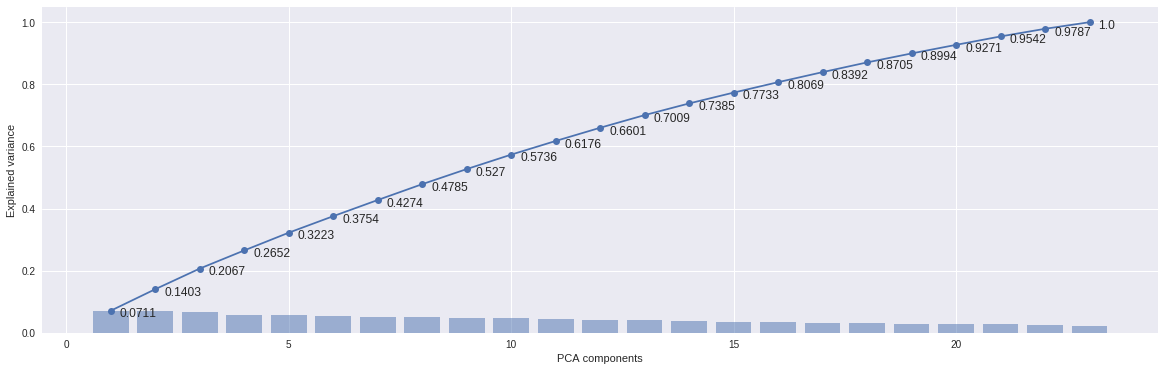

In [118]:


pca = PCA()
scaler = StandardScaler()
X_train_sc_sample_1 = scaler.fit_transform(X_train_sample_1)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_sc_sample_1))


plt.figure(figsize=(20,6))

X = np.arange(1,24)
cumulative_explained_variance_uci = np.cumsum(pca.explained_variance_ratio_)

plt.plot(X, cumulative_explained_variance_uci, '-o')
plt.bar(X, pca.explained_variance_ratio_, align='center', alpha=0.5)

for i, j in zip(X, np.cumsum(pca.explained_variance_ratio_)):
    plt.annotate(str(j.round(4)), xy=(i+.2,j-.02))
    
plt.xlabel('PCA components')
plt.ylabel('Explained variance')

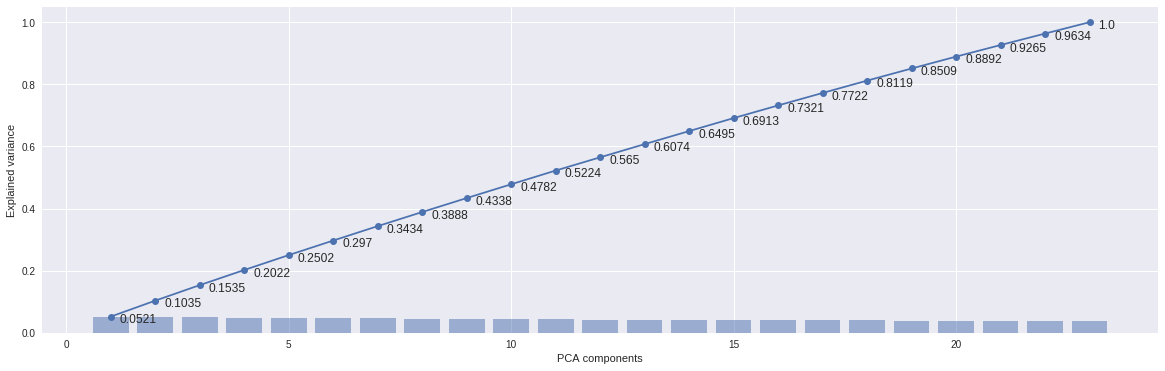

In [81]:
pca = PCA()
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(train_data[final_features])
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_sc))


plt.figure(figsize=(20,6))

X = np.arange(1,24)
cumulative_explained_variance_uci = np.cumsum(pca.explained_variance_ratio_)

plt.plot(X, cumulative_explained_variance_uci, '-o')
plt.bar(X, pca.explained_variance_ratio_, align='center', alpha=0.5)

for i, j in zip(X, np.cumsum(pca.explained_variance_ratio_)):
    plt.annotate(str(j.round(4)), xy=(i+.2,j-.02))
    
plt.xlabel('PCA components')
plt.ylabel('Explained variance')

### PCA with LogisticRegression

In [82]:
pca_steps = (
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("model", LogisticRegression())
)

pca_pipe = Pipeline(pca_steps)


sample_1_pca_pipe_fit = pca_pipe.fit(X_train_sample_1, sample_1_y)
sample_2_pca_pipe_fit = pca_pipe.fit(X_train_sample_2, sample_2_y)
sample_3_pca_pipe_fit = pca_pipe.fit(X_train_sample_3, sample_3_y)

In [83]:
sample_1_pca_pipe_fit.score(X_train_sample_1, sample_1_y)

0.505

In [84]:
sample_2_pca_pipe_fit.score(X_train_sample_2, sample_2_y)

0.51000000000000001

In [85]:
sample_3_pca_pipe_fit.score(X_train_sample_3, sample_3_y)

0.82499999999999996

In [86]:
(sample_1_pca_pipe_fit.score(X_train_sample_1, sample_1_y) + sample_2_pca_pipe_fit.score(X_train_sample_2, sample_2_y) +sample_3_pca_pipe_fit.score(X_train_sample_3, sample_3_y) )/3

0.6133333333333334

In [87]:
pca_pipe.fit(train_data[final_features], label).score(train_data[final_features], label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.58450000000000002

In [88]:
pca_pipe.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.61166666666666669

Grid Search CV for optimal parameters 

In [89]:
lr_grid_steps = (
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("logreg", LogisticRegression()),
)

lr_grid_pipe = Pipeline(lr_grid_steps)

lr_param_grid = {
    "pca__n_components" : range(1,11),
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": np.logspace(-4, 4, 10)
}


lr_grid = GridSearchCV(lr_grid_pipe, param_grid = lr_param_grid)


sample_1_lr_grid_fit = lr_grid.fit(X_train_sample_1, sample_1_y)
sample_2_lr_grid_fit = lr_grid.fit(X_train_sample_2, sample_2_y)
sample_3_lr_grid_fit = lr_grid.fit(X_train_sample_3, sample_3_y)

In [90]:
(sample_1_lr_grid_fit.score(X_train_sample_1, sample_1_y) + sample_2_lr_grid_fit.score(X_train_sample_2, sample_2_y) + sample_3_lr_grid_fit.score(X_train_sample_3, sample_3_y) )/3

0.61166666666666669

In [91]:
sample_2_lr_grid_fit.best_params_

{'logreg__C': 2.7825594022071258,
 'logreg__penalty': 'l1',
 'pca__n_components': 10}

In [92]:
sample_3_lr_grid_fit.best_params_

{'logreg__C': 2.7825594022071258,
 'logreg__penalty': 'l1',
 'pca__n_components': 10}

In [93]:
lr_grid.fit(train_data[final_features], label).score(train_data[final_features], label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.55800000000000005

In [94]:
lr_grid.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.60166666666666668

#### Decision Tree with PCA and GridSearchCV

In [95]:
tree_steps = (
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("tree", DecisionTreeClassifier()),
)

tree_pipe = Pipeline(tree_steps)


tree_param_grid = {
    "pca__n_components" : range(1,11),
    "tree__criterion": ["gini", "entropy"],
}

tree_grid = GridSearchCV(tree_pipe, param_grid = tree_param_grid)




sample_1_tree_grid_fit = tree_grid.fit(X_train_sample_1, sample_1_y)
sample_2_tree_grid_fit = tree_grid.fit(X_train_sample_2, sample_2_y)
sample_3_tree_grid_fit = tree_grid.fit(X_train_sample_3, sample_3_y)

In [96]:
sample_1_tree_grid_fit.score(X_train_sample_1, sample_1_y)

0.52500000000000002

In [97]:
sample_2_tree_grid_fit.score(X_train_sample_2, sample_2_y)

0.52000000000000002

In [98]:
sample_3_tree_grid_fit.score(X_train_sample_3, sample_3_y)

1.0

In [99]:
(sample_1_tree_grid_fit.score(X_train_sample_1, sample_1_y) + sample_2_tree_grid_fit.score(X_train_sample_2, sample_2_y) + sample_3_tree_grid_fit.score(X_train_sample_3, sample_3_y))/3

0.68166666666666664

In [100]:
sample_1_tree_grid_fit.best_params_

{'pca__n_components': 9, 'tree__criterion': 'gini'}

In [101]:
tree_grid.fit(train_data[final_features], label).score(train_data[final_features], label)

0.86299999999999999

In [102]:
tree_grid.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

0.875

In [184]:
tree_grid.fit(train_data[top_10], label).score(train_data[top_10], label)

1.0

In [185]:
tree_grid.fit(test_data[top_10], test_y).score(test_data[top_10], test_y)

1.0

In [ ]:
model_tree_steps = (
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(criterion = 'gini', max_depth=None, max_leaf_nodes=None, min_samples_leaf=1,min_samples_split=2)),
)

model_tree_pipe = Pipeline(tree_steps)

sample_1_model_tree_fit = model_tree_pipe.fit(X_train_sample_1, sample_1_y)
sample_2_model_tree_fit = model_tree_pipe.fit(X_train_sample_2, sample_2_y)
sample_3_model_tree_fit = model_tree_pipe.fit(X_train_sample_3, sample_3_y)

In [ ]:
mean_model_tree_score = (sample_1_model_tree_fit.score(X_train_sample_1, sample_1_y) + sample_2_model_tree_fit.score(X_train_sample_2, sample_2_y) + sample_3_model_tree_fit.score(X_train_sample_3, sample_3_y) )/3

In [ ]:
mean_model_tree_score

In [ ]:
model_tree_train_score = model_tree_pipe.fit(train_data[final_features], label).score(train_data[final_features], label)

In [ ]:
model_tree_test_score = model_tree_pipe.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

In [ ]:
model_tree_test_score 

#### K Nearest Neighbor with PCA and GridSearchCV

In [103]:
knn_steps = (
    ("scaler", StandardScaler()),
    ('pca', PCA()),
    ("knn", KNeighborsClassifier())
)

knn_pipe = Pipeline(knn_steps)

knn_param_grid ={
    "pca__n_components" : range(1,11),
    "knn__n_neighbors" : range(3,6),
    "knn__weights": ['uniform','distance']
}

knn_grid = GridSearchCV(knn_pipe, param_grid = knn_param_grid)


sample_1_knn_grid_fit = knn_grid.fit(X_train_sample_1, sample_1_y)
sample_2_knn_grid_fit = knn_grid.fit(X_train_sample_2, sample_2_y)
sample_3_knn_grid_fit = knn_grid.fit(X_train_sample_3, sample_3_y)

In [104]:
sample_1_knn_grid_fit.best_params_

{'knn__n_neighbors': 4, 'knn__weights': 'uniform', 'pca__n_components': 10}

In [105]:
sample_1_knn_grid_fit.score(X_train_sample_1, sample_1_y)

0.53500000000000003

In [106]:
sample_2_knn_grid_fit.score(X_train_sample_2, sample_2_y)

0.48999999999999999

In [107]:
sample_3_knn_grid_fit.score(X_train_sample_3, sample_3_y)

0.79500000000000004

In [108]:
(sample_1_knn_grid_fit.score(X_train_sample_1, sample_1_y) + sample_2_knn_grid_fit.score(X_train_sample_2, sample_2_y) + sample_3_knn_grid_fit.score(X_train_sample_3, sample_3_y) )/3

0.60666666666666658

In [109]:
knn_grid.fit(train_data[final_features], label).score(train_data[final_features], label)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.97699999999999998

In [110]:
knn_grid.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

0.99833333333333329

In [ ]:
sample_3_knn_grid_fit.best_params_

In [ ]:
model_knn_steps = (
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=8, weights = 'uniform'))
)

model_knn_pipe = Pipeline(model_knn_steps)


sample_1_model_knn_fit = model_knn_pipe.fit(X_train_sample_1, sample_1_y)
sample_2_model_knn_fit = model_knn_pipe.fit(X_train_sample_2, sample_2_y)
sample_3_model_knn_fit = model_knn_pipe.fit(X_train_sample_3, sample_3_y)

In [ ]:
model_knn_pipe.fit(train_data[final_features],label).score(train_data[final_features],label)

In [ ]:
model_knn_pipe.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)

In [ ]:
sample_1_model_knn_fit.score(X_train_sample_1, sample_1_y)

In [ ]:
sample_2_model_knn_fit.score(X_train_sample_2, sample_1_y)

In [ ]:
sample_3_model_knn_fit.score(X_train_sample_3, sample_1_y)

In [ ]:
(sample_1_model_knn_fit.score(X_train_sample_1, sample_1_y) + sample_2_model_knn_fit.score(X_train_sample_2, sample_1_y) + sample_3_model_knn_fit.score(X_train_sample_3, sample_1_y) )/3

#### Support Vector Machine with PCA and GridSearchCV

In [74]:
model_svc_steps = (
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=10)),
    ("svc", SVC(C=0.0059948425031894088, kernel='rbf'))
)

model_svc_pipe = Pipeline(model_svc_steps)

model_svc_fit = model_svc_pipe.fit(train_data[final_features], label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
model_svc_fit.score(train_data[final_features], label)

0.58199999999999996

In [57]:
svc_steps = (
    ("scaler", StandardScaler()),
    ('pca', PCA(n_components=10)),
    ("svc", SVC())
)

svc_pipe = Pipeline(svc_steps)

svc_param_grid ={
    "pca__n_components":range(7,11),
    "svc__C" : np.logspace(-4, 4, 3),
    "svc__kernel" : ['rbf','poly']
}

svc_grid = GridSearchCV(svc_pipe, param_grid = svc_param_grid)

sample_1_svc_grid_fit = svc_grid.fit(X_train_sample_1, sample_1_y)
sample_2_svc_grid_fit = svc_grid.fit(X_train_sample_2, sample_2_y)
sample_3_svc_grid_fit = svc_grid.fit(X_train_sample_3, sample_3_y)

In [68]:
sample_1_svc_grid_fit.score(X_train_sample_1, sample_1_y)

0.51500000000000001

In [60]:
sample_3_svc_grid_fit.score(X_train_sample_3, sample_3_y)

0.91000000000000003

In [61]:
(sample_1_svc_grid_fit.score(X_train_sample_1, sample_1_y) + sample_2_svc_grid_fit.score(X_train_sample_2, sample_2_y) +sample_3_svc_grid_fit.score(X_train_sample_3, sample_3_y) )/3

0.64833333333333343

In [ ]:
svc_grid.fit(train_data[final_features], label).score(train_data[final_features], label)

In [193]:
sample_1_svc_grid_fit.best_params_

{'pca__n_components': 10, 'svc__C': 1.0, 'svc__kernel': 'linear'}

In [ ]:
sample_2_svc_grid_fit.best_params_

In [ ]:
sample_3_svc_grid_fit.best_params_

In [ ]:
model_svc_steps = (
    ("scaler", StandardScaler()),
    ("svc", SVC(C=0.0059948425031894088, kernel='linear'))
)

model_svc_pipe = Pipeline(model_svc_steps)


sample_1_model_svc_fit = model_svc_pipe.fit(X_train_sample_1, sample_1_y)
sample_2_model_svc_fit = model_svc_pipe.fit(X_train_sample_2, sample_2_y)
sample_3_model_svc_fit = model_svc_pipe.fit(X_train_sample_3, sample_3_y)

In [ ]:
sample_1_model_svc_fit.score(X_train_sample_1, sample_1_y)

In [ ]:
sample_2_model_svc_fit.score(X_train_sample_2, sample_2_y)

In [ ]:
sample_3_model_svc_fit.score(X_train_sample_3, sample_1_y)

In [ ]:
(sample_1_model_svc_fit.score(X_train_sample_1, sample_1_y) + sample_2_model_svc_fit.score(X_train_sample_2, sample_2_y) +sample_3_model_svc_fit.score(X_train_sample_3, sample_1_y) )/3

In [ ]:
model_svc_pipe.fit(train_data[final_features],label).score(train_data[final_features],label)

In [ ]:
model_svc_pipe.fit(test_data[final_features], test_y).score(test_data[final_features], test_y)